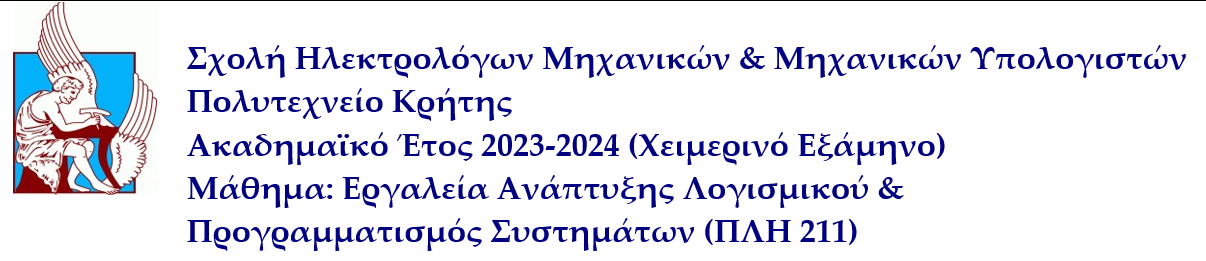

### Στοιχεία Φοιτητών Ομάδας
---
#### Φοιτητής 1
##### Αριθμός Μητρώου: 2021030008
##### Όνοματεπώνυμο: Πισιμίσης Κωνσταντίνος
##### Phases στα οποία εργάστηκε:Development και Logging Phase
---
#### Φοιτητής 2
##### Αριθμός Μητρώου: 2019030128
##### Όνοματεπώνυμο: Ρήγα Βαρβάρα
##### Phases στα οποία εργάστηκε: Profiling
---
#### Φοιτητής 3
##### Αριθμός Μητρώου: 2020030064
##### Όνοματεπώνυμο: Πάνου Αθανάσιος
##### Phases στα οποία εργάστηκε: Refactoring Phase & Unit Testing Phase
---



# Εργασία 1 - Θέμα: Ανάπτυξη Λογισμικού Aggregative News Analyzer

---
⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰
# ΔΕΝ προχωράμε παρακάτω σε αυτό το notebook αν δεν έχουμε διαβάσει και είμαστε έτοιμοι να εφαρμόσουμε ακριβώς τις οδηγίες που διανέμονται μαζί με αυτή την εργασία στο PLH211_Project1_2023_2024_Directions.docx.
---
⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰

<font color='red'> Στα πλαίσια της εργασίας δεν μπορείτε να υποθέσετε ότι τα news και άρα τα αρχεία που σας δίδονται δεν αλλάζουν ποτέ. Το αρχείο με τα news θεωρείται μεταβλητό καθώς σε ένα πραγματικό σενάριο τα news ανανεώνονται σε τακτά χρονικά διαστήματα. Άρα δεν μπορείτε να προ-υπολογίσετε το Jaccard Index και όσα άλλα ζητούνται μόνο μια φορά και να τα σώσετε μια μόνο φορά σε αρχείο.</font>  

# Development Phase

## ⏩ Κώδικας Development Phase
Γράψτε στο παρακάτω code cell όλο τον κώδικα που υλοποιεί τον Aggregative News Analyzer σας.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import annotations
from openpyxl.styles import Font
from math import floor
from random import randint
import os
import json
import openpyxl


###########################################BplustreeStart##############################################
class Node:
    """
    Base node object.

    Attributes:
        order (int): The maximum number of keys each node can hold (branching factor).
    """
    uidCounter = 0

    def __init__(self, order):
        self.order = order
        self.parent: Node = None
        self.keys = []
        self.values = []

        #  This is for Debugging purposes only!
        Node.uidCounter += 1
        self.uid = self.uidCounter

    def split(self) -> Node:  # Split a full Node to two new ones.
        left = Node(self.order)
        right = Node(self.order)
        mid = int(self.order // 2)

        left.parent = right.parent = self

        left.keys = self.keys[:mid]
        left.values = self.values[:mid + 1]

        right.keys = self.keys[mid + 1:]
        right.values = self.values[mid + 1:]

        self.values = [left, right]  # Setup the pointers to child nodes.

        self.keys = [self.keys[mid]]  # Hold the first element from the right subtree.

        # Setup correct parent for each child node.
        for child in left.values:
            if isinstance(child, Node):
                child.parent = left

        for child in right.values:
            if isinstance(child, Node):
                child.parent = right

        return self  # Return the 'top node'

    def getSize(self) -> int:
        return len(self.keys)

    def isEmpty(self) -> bool:
        return len(self.keys) == 0

    def isFull(self) -> bool:
        return len(self.keys) == self.order - 1

    def isNearlyUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2)

    def isUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2) - 1

    def isRoot(self) -> bool:
        return self.parent is None


class LeafNode(Node):
    def __init__(self, order):
        super().__init__(order)

        self.prevLeaf: LeafNode = None
        self.nextLeaf: LeafNode = None

    # TODO: Implement an improved version
    def add(self, key, value):
        if not self.keys:  # Insert key if it doesn't exist
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):  # Otherwise, search key and append value.
            if key == item:  # Key found => Append Value
                self.values[i].append(value)  # Remember, this is a list of data. Not nodes!
                break

            elif key < item:  # Key not found && key < item => Add key before item.
                self.keys = self.keys[:i] + [key] + self.keys[i:]
                self.values = self.values[:i] + [[value]] + self.values[i:]
                break

            elif i + 1 == len(self.keys):  # Key not found here. Append it after.
                self.keys.append(key)
                self.values.append([value])
                break

    def split(self) -> Node:  # Split a full leaf node. (Different method used than before!)
        top = Node(self.order)
        right = LeafNode(self.order)
        mid = int(self.order // 2)

        self.parent = right.parent = top

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]
        right.prevLeaf = self
        right.nextLeaf = self.nextLeaf

        top.keys = [right.keys[0]]
        top.values = [self, right]  # Setup the pointers to child nodes.

        self.keys = self.keys[:mid]
        self.values = self.values[:mid]
        self.nextLeaf = right  # Setup pointer to next leaf

        return top  # Return the 'top node'


class BPlusTree(object):
    def __init__(self, order=5):
        self.root: Node = LeafNode(order)  # First node must be leaf (to store data).
        self.order: int = order

    @staticmethod
    def _find(node: Node, key):
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
            elif i + 1 == len(node.keys):
                return node.values[i + 1], i + 1  # return right-most node/pointer.

    @staticmethod
    def _mergeUp(parent: Node, child: Node, index):
        parent.values.pop(index)
        pivot = child.keys[0]

        for c in child.values:
            if isinstance(c, Node):
                c.parent = parent

        for i, item in enumerate(parent.keys):
            if pivot < item:
                parent.keys = parent.keys[:i] + [pivot] + parent.keys[i:]
                parent.values = parent.values[:i] + child.values + parent.values[i:]
                break

            elif i + 1 == len(parent.keys):
                parent.keys += [pivot]
                parent.values += child.values
                break

    def insert(self, key, value):
        node = self.root

        while not isinstance(node, LeafNode):  # While we are in internal nodes... search for leafs.
            node, index = self._find(node, key)

        # Node is now guaranteed a LeafNode!
        node.add(key, value)

        while len(node.keys) == node.order:  # 1 over full
            if not node.isRoot():
                parent = node.parent
                node = node.split()  # Split & Set node as the 'top' node.
                jnk, index = self._find(parent, node.keys[0])
                self._mergeUp(parent, node, index)
                node = parent
            else:
                node = node.split()  # Split & Set node as the 'top' node.
                self.root = node  # Re-assign (first split must change the root!)

    def retrieve(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, index = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]

        return None

    def delete(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, parentIndex = self._find(node, key)

        if key not in node.keys:
            return False

        index = node.keys.index(key)
        node.values[index].pop()  # Remove the last inserted data.

        if len(node.values[index]) == 0:
            node.values.pop(index)  # Remove the list element.
            node.keys.pop(index)

            while node.isUnderflow() and not node.isRoot():
                # Borrow attempt:
                prevSibling = BPlusTree.getPrevSibling(node)
                nextSibling = BPlusTree.getNextSibling(node)
                jnk, parentIndex = self._find(node.parent, key)

                if prevSibling and not prevSibling.isNearlyUnderflow():
                    self._borrowLeft(node, prevSibling, parentIndex)
                elif nextSibling and not nextSibling.isNearlyUnderflow():
                    self._borrowRight(node, nextSibling, parentIndex)
                elif prevSibling and prevSibling.isNearlyUnderflow():
                    self._mergeOnDelete(prevSibling, node)
                elif nextSibling and nextSibling.isNearlyUnderflow():
                    self._mergeOnDelete(node, nextSibling)

                node = node.parent

            if node.isRoot() and not isinstance(node, LeafNode) and len(node.values) == 1:
                self.root = node.values[0]
                self.root.parent = None

    @staticmethod
    def _borrowLeft(node: Node, sibling: Node, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(-1)
            data = sibling.values.pop(-1)
            node.keys.insert(0, key)
            node.values.insert(0, data)

            node.parent.keys[parentIndex - 1] = key  # Update Parent (-1 is important!)
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(-1)
            sibling_key = sibling.keys.pop(-1)
            data: Node = sibling.values.pop(-1)
            data.parent = node

            node.parent.keys.insert(0, sibling_key)
            node.keys.insert(0, parent_key)
            node.values.insert(0, data)

    @staticmethod
    def _borrowRight(node: LeafNode, sibling: LeafNode, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(0)
            data = sibling.values.pop(0)
            node.keys.append(key)
            node.values.append(data)
            node.parent.keys[parentIndex] = sibling.keys[0]  # Update Parent
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(0)
            sibling_key = sibling.keys.pop(0)
            data: Node = sibling.values.pop(0)
            data.parent = node

            node.parent.keys.append(sibling_key)
            node.keys.append(parent_key)
            node.values.append(data)

    @staticmethod
    def _mergeOnDelete(l_node: Node, r_node: Node):
        parent = l_node.parent

        jnk, index = BPlusTree._find(parent, l_node.keys[0])  # Reset pointer to child
        parent_key = parent.keys.pop(index)
        parent.values.pop(index)
        parent.values[index] = l_node

        if isinstance(l_node, LeafNode) and isinstance(r_node, LeafNode):
            l_node.nextLeaf = r_node.nextLeaf  # Change next leaf pointer
        else:
            l_node.keys.append(parent_key)  # TODO Verify this
            for r_node_child in r_node.values:
                r_node_child.parent = l_node

        l_node.keys += r_node.keys
        l_node.values += r_node.values

    @staticmethod
    def getPrevSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])
        return node.parent.values[index - 1] if index - 1 >= 0 else None

    @staticmethod
    def getNextSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])

        return node.parent.values[index + 1] if index + 1 < len(node.parent.values) else None

    def printTree(self):
        if self.root.isEmpty():
            print('The bpt+ Tree is empty!')
            return
        queue = [self.root, 0]  # Node, Height... Not systematic but it works

        while len(queue) > 0:
            node = queue.pop(0)
            height = queue.pop(0)

            if not isinstance(node, LeafNode):
                queue += self.intersperse(node.values, height + 1)
            print('Level ' + str(height), '|'.join(map(str, node.keys)), ' -->\t current -> ', node.uid,
                  '\t parent -> ',
                  node.parent.uid if node.parent else None)

    def getLeftmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[0]

        return node

    def getRightmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[-1]

    def showAllData(self):
        node = self.getLeftmostLeaf()
        if not node:
            return None

        while node:
            for node_data in node.values:
                print('[{}]'.format(', '.join(map(str, node_data))), end=' -> ')

            node = node.nextLeaf
        print('Last node')

    def showAllDataReverse(self):
        node = self.getRightmostLeaf()
        if not node:
            return None

        while node:
            for node_data in reversed(node.values):
                print('[{}]'.format(', '.join(map(str, node_data))), end=' <- ')

            node = node.prevLeaf
        print()

    @staticmethod
    def intersperse(lst, item):
        result = [item] * (len(lst) * 2)
        result[0::2] = lst
        return result

#############################################BplustreeEnd##############################################

#################################################MainStart#############################################

class read_files:
    @staticmethod
    def read_pairs_from_file(file_name, bpt_instance):
        """
        Reads pairs from a file and stores them in the keys dictionary.
        """
        keys = {}
        already_inserted = set()
        bplus_set = set()
        try:
            if not isinstance(file_name, str):
                raise ValueError("file_name must be a string.")
            if not os.path.isfile(file_name):
                raise ValueError(f"File {file_name} does not exist.")
        except Exception as e:
            print(f"An error occurred: {e}")

        try:
            with open(file_name, 'r', encoding = "latin1") as file:
                for line in file:
                    # '\n' is a newline,'\t' is a tab,'\v' is a vertical tab,'\b' is a backspace,'\0' is a null character.
                    if line[0] in ['#', '%', '^', '_', '!', '@', '$', '*', ' ' , '\n', '\t', '\v', '\b', '\0']:
                        continue
                    else:
                        elements = line.split()
                        if len(elements) >= 2:
                            if ":" in line:
                                document_id = elements[0]  # Extract document ID
                                term = []

                                for element in elements[1:]:
                                    if ':' in element:
                                        term.append(element.split(':')[0])  # Add only the term before colon to the list

                                if document_id in already_inserted:
                                    keys[document_id].update(term)
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                                else:
                                    already_inserted.add(document_id)
                                    keys[document_id] = term
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                            else:
                                key = elements[0]
                                value = elements[1]

                                if key in already_inserted:
                                    keys[key].add(value)
                                    if value in bplus_set:
                                        bpt_instance.retrieve(key).add(value)
                                    else:
                                        bpt_instance.insert(value, {key})
                                else:
                                    already_inserted.add(key)
                                    keys[key] = {value}
                                    if value in bplus_set:
                                        bpt_instance.retrieve(value).add(key)
                                    else:
                                        bpt_instance.insert(value, {key})
        except IOError:
            print(f"Could not read file: {file_name}")

        print("Files have been stored")
        return keys

class write_files:
    def __init__(self, file_name, data_to_write, type_of_file):
        try:
            if not isinstance(file_name, str):
                raise ValueError("The file name must be a string.")
            if not isinstance(data_to_write, dict):
                raise ValueError("data_to_write must be a dictionary.")
            if not isinstance(type_of_file, str):
                raise ValueError("The file type must be a string.")
            if type_of_file not in ("json", "xlsx"):
                raise ValueError("The file type  must be either json or xlsx.")

            self.file_name = file_name
            self.data_to_write = data_to_write
            self.type_of_file = type_of_file
        except Exception as e:
            print(f"An error occurred: {e}")
            return

    def write_to_file(self):
            try:
                if self.type_of_file is not  None or self.file_name is not None:
                    user_file =  f"{self.file_name}.{self.type_of_file}"
                    with open(user_file, 'w') as file:
                        if self.type_of_file == "json":
                            json_data = []
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    json_data.append({
                                        'stem': stem,
                                        'category': category,
                                        'jaccardIndex': jaccard_index
                                })
                            json.dump(json_data, file)

                        else:
                            wb = openpyxl.Workbook()
                            ws = wb.active
                            ws.title = "Jaccard Index"
                            ws.append(["Stem", "Category", "Jaccard Index"])
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    ws.append([stem, category, jaccard_index])
                            wb.save(user_file)
            except IOError:
                print(f"Could not write to file: {self.file_name}")
                return

class jaccard_index:
    def __init__(self, category, term, stem):
        self.category = category
        self.term = term
        self.stem = stem
        self.jaccard_index = {}

    def calculate_jaccard_index(self):
        """
        Calculate the jaccard index for each stem and category
        """
        for stem_key, term_value in self.stem.items():
            self.jaccard_index[stem_key] = {}
            term_docs = set(self.get_term_docs(term_value))
            category_key = None
            for category_key, category_docs in self.category.items():
                category_docs_set = set(category_docs)
                intersection = len(term_docs & category_docs_set)
                union = len(term_docs | category_docs_set)
                self.jaccard_index[stem_key][category_key] = intersection / union
        return self.jaccard_index

    def get_term_docs(self, term_value):
        """
        Get all the documents that contain at least one of the terms
        """
        term_docs = []
        term_value_set = set(term_value)
        for doc_id, terms in self.term.items():
            for term_list in terms:
                term_list_set = {term_list}
                if term_value_set & term_list_set:
                    term_docs.append(doc_id)
        return set(term_docs)  # remove duplicates

    def get_most_relevant_stems_for_category(self, category, k):
        """
        Get the top k stems for the given category
        """
        # Create a dictionary for the category
        category_jaccard_index = {}

        # Iterate over the jaccard_index dictionary
        for stem, categories in self.jaccard_index.items():
            # If the category exists in the inner dictionary, add it to the category_jaccard_index dictionary
            if category in categories:
                category_jaccard_index[stem] = categories[category]

        # If the category_jaccard_index dictionary is empty, the category was not found
        if not category_jaccard_index:
            print(f"Category {category} not found in jaccard_index.")
            return []

        # Sort the stems by their jaccard index in descending order
        sorted_stems = sorted(category_jaccard_index.items(), key=lambda item: item[1], reverse = True)

        # Get the top k stems
        top_k_stems = [stem for stem, _ in sorted_stems[:k]]

        return top_k_stems

    def get_most_relevant_categories_for_stem(self, stem, k):
        """
        Get the top k categories for the given stem
        """
        # Check if the stem exists in the jaccard_index
        if stem not in self.jaccard_index:
            print(f"Stem {stem} not found in jaccard_index.")
            return []

        # Get the jaccard index for the stem
        stem_jaccard_index = self.jaccard_index[stem]

        # Sort the categories by their jaccard index in descending order
        sorted_categories = sorted(stem_jaccard_index.items(), key = lambda item: item[1], reverse=True)

        # Get the top k categories
        top_k_categories = [category for category, _ in sorted_categories[:k]]

        return top_k_categories



class MainConsole:
    @staticmethod
    def main():
        print("Welcome to our application!")

        #Change this!!!!!!!!!!!!!!!!
        ######################################################################################################################
        #Colab paths ---Personal use
        file_to_read_categories = "/content/drive/MyDrive/Colab Notebooks/TestData/category_docId.txt"
        file_to_read_term = "/content/drive/MyDrive/Colab Notebooks/TestData/docID_term.txt"
        file_to_read_stems = "/content/drive/MyDrive/Colab Notebooks/TestData/stem_term.txt"
        ######################################################################################################################

        order_of_tree = 10
        bpt_categories = BPlusTree(order_of_tree)
        bpt__term = BPlusTree(order_of_tree)
        bpt_stems = BPlusTree(order_of_tree)

        returned_data_categories = read_files.read_pairs_from_file(file_to_read_categories, bpt_categories) # Calling the method and storing the return value
        returned_data_term = read_files.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = read_files.read_pairs_from_file(file_to_read_stems, bpt_stems)
        jaccard_instance =jaccard_index(returned_data_categories, returned_data_term, returned_data_stems)
        jaccard_index_value = jaccard_instance.calculate_jaccard_index()
        print("Jaccard Index has been calculated")

        while True:
            print("\n")
            MainConsole.print_menu()
            user_input = input("Please enter your choice: ")
            parsed_input = user_input.split()
            try:
                operation = parsed_input[0]
            except IndexError:
                print("Error: Empty input. Please enter a valid command.") # If the user enters an empty input, the program will not crash
                continue
            parameters = parsed_input[1:]
            if operation == '@':
                category = parameters[0]
                k = int(parameters[1])
                most_relevant_stems = jaccard_instance.get_most_relevant_stems_for_category(category, k)
                print(f"The top {k} stems for category {category} are: {most_relevant_stems}")
            elif operation == '#':
                    stem = parameters[0]
                    k = int(parameters[1])
                    most_relevant_categories = jaccard_instance.get_most_relevant_categories_for_stem(stem, k)
                    print(f"The top {k} categories for stem {stem} are: {most_relevant_categories}")
            elif operation == '$':
                    stem = parameters[0]
                    category = parameters[1]
                    print(f"The Jaccard Index for the pair ({stem}, {category}) is: {jaccard_index_value[stem][category]}")
            elif operation == '*':
                    try:
                        filename = parameters[0]
                        filename, file_type = filename.split('.')
                        writer = write_files(filename, jaccard_index_value, file_type)
                        writer.write_to_file()
                        print(f"Data has been written to file: {filename}.{file_type}")
                    except Exception as e:
                        print(f"An error occurred: {e}")
            elif operation == 'P':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        continue
                    else:
                        if option == '-c':
                            if bpt_categories.retrieve(did) is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The categories for document {did} are: {bpt_categories.retrieve(did)}")
                        else:
                            stem_collection = []
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for term in result:
                                if isinstance(term, list): #This if statement is used to handle the case where a document has more than one term
                                    for sub_term in term:
                                        stem_to_print = bpt_stems.retrieve(sub_term)
                                        if stem_to_print is not None:
                                            stem_collection.extend(stem_to_print)
                                else:
                                    stem_to_print = bpt_stems.retrieve(term)
                                    if stem_to_print is not None:
                                        stem_collection.extend(stem_to_print)
                            print(f"The stems for document {did} are: {stem_collection}")
            elif operation == 'C':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        continue
                    else:
                        if option == '-c':
                            #Remove dupliates by using set
                            stem_collection = set()
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for stem in result:
                                stem_collection.update(stem)
                            print(f"The count of unique terms for document {did} is: {len(stem_collection)}")
                        else:
                            categories_set = bpt_categories.retrieve(did)
                            if categories_set is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The count of categories for document {did} is: {len(categories_set)}")
            elif operation == 'Q': # Exit the program.Not available to the user but its a nice feature to have
                    print("So you found my little secret....Terminating the program....")
                    print("Thank you for using our application!")
                    print("Goodbye!")
                    break
            else:
                    print("Invalid operation")


    @staticmethod
    def print_menu():
        print("Enter the operation you want to perform: \n" +
              "@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category. \n" +
              "# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem. \n" +
              "$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category). \n" +
              "* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file\n" +
              "P <did> -c : Display all the categories associated with the document identified by the code id.\n" +
              "P <did> -t : Fetch all the stems present in the document linked to a specific code id.\n" +
              "C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.\n" +
              "C <did> -t : Calculate and display the count of categories assigned to the document with the code id")

if __name__ == "__main__":
    MainConsole.main()

#################################################MainEnd#############################################

Welcome to our application!
An error occurred: File /content/drive/MyDrive/Colab Notebooks/TestData/category_docId.txt does not exist.
Could not read file: /content/drive/MyDrive/Colab Notebooks/TestData/category_docId.txt
Files have been stored
An error occurred: File /content/drive/MyDrive/Colab Notebooks/TestData/docID_term.txt does not exist.
Could not read file: /content/drive/MyDrive/Colab Notebooks/TestData/docID_term.txt
Files have been stored
An error occurred: File /content/drive/MyDrive/Colab Notebooks/TestData/stem_term.txt does not exist.
Could not read file: /content/drive/MyDrive/Colab Notebooks/TestData/stem_term.txt
Files have been stored
Jaccard Index has been calculated


Enter the operation you want to perform: 
@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category. 
# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem. 
$ <stem> <category>: Provides the Ja

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Developement Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Development Phase στο προηγούμενο code cell (H τεκμηρίωση βαθμολογείται).

# Σχολιασμός Κώδικα:
Το πρόγραμμα ξεκινάει και καλείται η μέθοδος main της κλάσης MainConsole που υλοποιεί το μενού του χρήστη και κάνει τις απαιτούμενες ενέργειες.

*Λειτουργικότητα*\
 Αρχικά ορίζουμε την διεύθυνση (path) των αρχείων που θα επεξεργαστούμε και κατόπιν καλούμε την static μέθοδο *read_pairs_from_file* η οποία δέχεται σαν όρισμα το όνομα του αρχείου, καθώς και ένα instace της κλάσης BplusTree ώστε να μπορούμε να αποθηκεύσουμε τα δεδομενα μας σε μια δομή BplusTree. Η μέθοδος *read_pairs_from_file* διαβάζει τα αρχεία μας κατάλληλα και επιστρέφει ένα dict() με τις ζητούμενες πληροφορίες.

Κατόπιν, υπολογίζεται ο δείκτης σχετικότητας (Jaccard Index) για κάθε term, category και στην συνέχεια εισερχόμαστε σε έναν ατέρμονο βρόχο (*while True*) και  τυπώνονται στην κονσόλα του χρήστη οι διαθέσιμες επιλογές προς αυτόν.

Οι διαθέσιμες εντολές και ο τρόπος που υλοποιούνται από τον κώδικα είναι οι εξής:


1. * _@ category k:_ \\
Με την εντολή *@ categoty k* τυπώνονται τα k πιο σχετικά, βάσει JaccardIndex, stems για το category. Σε επίπεδο κώδικα, καλόυμε την μέθοδο *get_most_relevant_stems_for_category*  της κλάσης JaccardIndex και τυπώνονται τα ζητούμενα stems.
2.  * _# stem k_: \\
Με την εντολή *# stem k*, τυπώνουμε στην κονσόλα τα *k* πιο σχετικά,βάσει JaccardIndex, categories για το συγκεκριμένο stem. Και σε αυτήν την περίπτωση, σε επίπεδο κώδικα, καλόυμε την μέθοδο *jaccard_instance.get_most_relevant_categories_for_stem(stem, k)*
3.  *  _\$ stem, category_ :  
Με την εντολή *$ stem category*, τυπώνουμε στην κονσόλα το συγκεκριμένο ζεύγος stem, category με το JaccardIndex τους. Στην περίπτωση που δεν υπάρχει, ένα σχετικό μήνυμα τυπώνεται στον χρήστη.
4. * _\*filename filetype_ : \\
Με την εντολή αυτή, ο χρήστης μπορεί να σώσει είτε σε xlsx είτε σε json αρχεία όλα τα ζεύγη category, stem μαζί με τον JaccardIndex τους. Σε επίπεδο κώδικα, δημιουργούμε ένα νέο instance της κλάσης *write_files* όπου περνάμε τα κατάλληλα ορίσματα. Κατόπιν, καλούμε την μέθοδο *write_to_file()* η οποία εγγράφει τα δεδομένα στο κατάλληλο αρχείο.
Αν η εγγραφή είναι αποτυχυμένη ή επιτυχυμένη, ένα σχετικό μήνυμα τυπώνεται για ενημέρωση του χρήστη.
5. * *P did -c | -t :*  \
Όταν χρησιμοποείται η εντολή με το switch -t τότε τυπώνουμε στην κονσόλα όλα τα stem που περιέχει το document με κωδικό did. Σε επίπεδο κώδικα,αναζητάμε στο BplusTree δέντρο μας το value για το αντίστοιχο document. Κατόπιν, μέσω του for loop για κάθε στοιχείο της λίστας κάνουμε μια δεύτερη αναζήτηση στο BplusTree που περιέχει τα stems και τα values. Εφόσον η αναζήτηση είναι επιτυχής, τότε προσθέτουμε τα stems που βρήκαμε σε μια list και την τυπώνουμε.\
Όταν χρησιμοποείται η εντολή με το switch -c τότε τυπώνουμε όλες τις κατηγορίες που έχουν ανατεθεί στο document με κωδικό did. Σε επίπεδο κώδικα, αρκεί να κάνουμε μια αναζήτηση στο BplusTree με τον κωδικό did και τυπώνουμε το αποτέλεσμα.
6. * *C did -c | -t:* \
Όταν χρησιμοποείται αυτή η εντολή με το switch -t μετράμε και τυπώνουμε τα μοναδικά terms που περιέχει το document με κωδικό did. Σε επίπεδο κώδικα, πραγματοποιούμε μια αναζήτηση στο BplusTree με το κλειδί did και περνάμε το value μέσα από ένα set φιλτράροντας κατά αυτό τον τρόπο τυχόν διπλοτυπα terms. \
Όταν τώρα χρησιμοποείται η εντολή με το switch -c μετράμε και τυπώνουμε πόσες κατηγορίες έχουν ανατεθεί στο document με κωδικό did. Σε επίπεδο κώδικα, κάνουμε μια αναζήτηση στο BplusTree και τυπώνουμε το μήκος του value.

Για όλα τα παραπάνω ενδεχόμενα, τυπώνεται κατάλληλο μήνυμα σφάλματος ενώ έχει προστεθεί και μια "κρυφή" επιλογή για τον τερματισμό του προγράμματος ώστε να αποφύγουμε το key interrupt. \
Αναφορικά με το BplusTree, εκτός των βασικών χαρακτηριστικών λειτουργιών όπως η εισαγωγή, διαγραφή και αναζήτηση, περιέχει και επιπλέον μεθόδους για λόγους αποσφαλμάτωσης. Ολοκληρώνοντας, επιλέχθηκε η συγκεκριμένη δομή γιατί έχει εγγυημένη λογαριθμική πολυπλοκότητα $O(log_N(M))$ όπου Ν η τάξη του δέντρου και Μ το πλήθάριθμος του dataset.
O παράγοντας διάσπασης είναι στο Ν+1.




# Logging Phase


## ⏩ Κώδικας Logging Phase
Γράψτε στο παρακάτω code cell όλο τον κώδικα που φτιάχνει το myeditorlog.conf αρχείο με το configuration (loggers, handlers, formatters) του logger σας.

`format=%(asctime)s - %(name)s - %(levelname)s - %(message)s `

In [ ]:
%%file myeditorlog.conf

[loggers]
keys=root

[logger_root]
handlers=file
level=NOTSET

[formatters]
keys=simple

[formatter_simple]
format=%(asctime)s - %(name)s - %(levelname)s - %(message)s

[handlers]
keys=file

[handler_file]
class=FileHandler
interval=midnight
formatter=simple
level=INFO
args=('logme.txt','w')


Writing myeditorlog.conf


Γράψτε στο παρακάτω code cell τον κώδικα του Aggregative News Analyzer όπως ήταν στο Developement phase ΑΛΛΑ εδώ θα έχει και εισαγωγή των κατάλληλων εντολών που δημιουργούν τα LogRecords ώστε αυτά να γράφονται σε ένα αρχείο logme.txt .

In [ ]:
from __future__ import annotations
from openpyxl.styles import Font
from math import floor
from random import randint
import os
import json
import openpyxl
import logging
import logging.config

logging.config.fileConfig(fname='myeditorlog.conf', disable_existing_loggers = False)

# Get the logger specified in the file
logger = logging.getLogger(__name__)


###########################################BplustreeStart##############################################
class Node:
    """
    Base node object.

    Attributes:
        order (int): The maximum number of keys each node can hold (branching factor).
    """
    uidCounter = 0

    def __init__(self, order):
        self.order = order
        self.parent: Node = None
        self.keys = []
        self.values = []

        #  This is for Debugging purposes only!
        Node.uidCounter += 1
        self.uid = self.uidCounter

    def split(self) -> Node:  # Split a full Node to two new ones.
        left = Node(self.order)
        right = Node(self.order)
        mid = int(self.order // 2)

        left.parent = right.parent = self

        left.keys = self.keys[:mid]
        left.values = self.values[:mid + 1]

        right.keys = self.keys[mid + 1:]
        right.values = self.values[mid + 1:]

        self.values = [left, right]  # Setup the pointers to child nodes.

        self.keys = [self.keys[mid]]  # Hold the first element from the right subtree.

        # Setup correct parent for each child node.
        for child in left.values:
            if isinstance(child, Node):
                child.parent = left

        for child in right.values:
            if isinstance(child, Node):
                child.parent = right

        return self  # Return the 'top node'

    def getSize(self) -> int:
        return len(self.keys)

    def isEmpty(self) -> bool:
        return len(self.keys) == 0

    def isFull(self) -> bool:
        return len(self.keys) == self.order - 1

    def isNearlyUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2)

    def isUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2) - 1

    def isRoot(self) -> bool:
        return self.parent is None


class LeafNode(Node):
    def __init__(self, order):
        super().__init__(order)

        self.prevLeaf: LeafNode = None
        self.nextLeaf: LeafNode = None

    # TODO: Implement an improved version
    def add(self, key, value):
        if not self.keys:  # Insert key if it doesn't exist
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):  # Otherwise, search key and append value.
            if key == item:  # Key found => Append Value
                self.values[i].append(value)  # Remember, this is a list of data. Not nodes!
                break

            elif key < item:  # Key not found && key < item => Add key before item.
                self.keys = self.keys[:i] + [key] + self.keys[i:]
                self.values = self.values[:i] + [[value]] + self.values[i:]
                break

            elif i + 1 == len(self.keys):  # Key not found here. Append it after.
                self.keys.append(key)
                self.values.append([value])
                break

    def split(self) -> Node:  # Split a full leaf node. (Different method used than before!)
        top = Node(self.order)
        right = LeafNode(self.order)
        mid = int(self.order // 2)

        self.parent = right.parent = top

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]
        right.prevLeaf = self
        right.nextLeaf = self.nextLeaf

        top.keys = [right.keys[0]]
        top.values = [self, right]  # Setup the pointers to child nodes.

        self.keys = self.keys[:mid]
        self.values = self.values[:mid]
        self.nextLeaf = right  # Setup pointer to next leaf

        return top  # Return the 'top node'


class BPlusTree(object):
    def __init__(self, order=5):
        self.root: Node = LeafNode(order)  # First node must be leaf (to store data).
        self.order: int = order

    @staticmethod
    def _find(node: Node, key):
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
            elif i + 1 == len(node.keys):
                return node.values[i + 1], i + 1  # return right-most node/pointer.

    @staticmethod
    def _mergeUp(parent: Node, child: Node, index):
        parent.values.pop(index)
        pivot = child.keys[0]

        for c in child.values:
            if isinstance(c, Node):
                c.parent = parent

        for i, item in enumerate(parent.keys):
            if pivot < item:
                parent.keys = parent.keys[:i] + [pivot] + parent.keys[i:]
                parent.values = parent.values[:i] + child.values + parent.values[i:]
                break

            elif i + 1 == len(parent.keys):
                parent.keys += [pivot]
                parent.values += child.values
                break

    def insert(self, key, value):
        node = self.root

        while not isinstance(node, LeafNode):  # While we are in internal nodes... search for leafs.
            node, index = self._find(node, key)

        # Node is now guaranteed a LeafNode!
        node.add(key, value)

        while len(node.keys) == node.order:  # 1 over full
            if not node.isRoot():
                parent = node.parent
                node = node.split()  # Split & Set node as the 'top' node.
                jnk, index = self._find(parent, node.keys[0])
                self._mergeUp(parent, node, index)
                node = parent
            else:
                node = node.split()  # Split & Set node as the 'top' node.
                self.root = node  # Re-assign (first split must change the root!)

    def retrieve(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, index = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]

        return None

    def delete(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, parentIndex = self._find(node, key)

        if key not in node.keys:
            return False

        index = node.keys.index(key)
        node.values[index].pop()  # Remove the last inserted data.

        if len(node.values[index]) == 0:
            node.values.pop(index)  # Remove the list element.
            node.keys.pop(index)

            while node.isUnderflow() and not node.isRoot():
                # Borrow attempt:
                prevSibling = BPlusTree.getPrevSibling(node)
                nextSibling = BPlusTree.getNextSibling(node)
                jnk, parentIndex = self._find(node.parent, key)

                if prevSibling and not prevSibling.isNearlyUnderflow():
                    self._borrowLeft(node, prevSibling, parentIndex)
                elif nextSibling and not nextSibling.isNearlyUnderflow():
                    self._borrowRight(node, nextSibling, parentIndex)
                elif prevSibling and prevSibling.isNearlyUnderflow():
                    self._mergeOnDelete(prevSibling, node)
                elif nextSibling and nextSibling.isNearlyUnderflow():
                    self._mergeOnDelete(node, nextSibling)

                node = node.parent

            if node.isRoot() and not isinstance(node, LeafNode) and len(node.values) == 1:
                self.root = node.values[0]
                self.root.parent = None

    @staticmethod
    def _borrowLeft(node: Node, sibling: Node, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(-1)
            data = sibling.values.pop(-1)
            node.keys.insert(0, key)
            node.values.insert(0, data)

            node.parent.keys[parentIndex - 1] = key  # Update Parent (-1 is important!)
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(-1)
            sibling_key = sibling.keys.pop(-1)
            data: Node = sibling.values.pop(-1)
            data.parent = node

            node.parent.keys.insert(0, sibling_key)
            node.keys.insert(0, parent_key)
            node.values.insert(0, data)

    @staticmethod
    def _borrowRight(node: LeafNode, sibling: LeafNode, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(0)
            data = sibling.values.pop(0)
            node.keys.append(key)
            node.values.append(data)
            node.parent.keys[parentIndex] = sibling.keys[0]  # Update Parent
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(0)
            sibling_key = sibling.keys.pop(0)
            data: Node = sibling.values.pop(0)
            data.parent = node

            node.parent.keys.append(sibling_key)
            node.keys.append(parent_key)
            node.values.append(data)

    @staticmethod
    def _mergeOnDelete(l_node: Node, r_node: Node):
        parent = l_node.parent

        jnk, index = BPlusTree._find(parent, l_node.keys[0])  # Reset pointer to child
        parent_key = parent.keys.pop(index)
        parent.values.pop(index)
        parent.values[index] = l_node

        if isinstance(l_node, LeafNode) and isinstance(r_node, LeafNode):
            l_node.nextLeaf = r_node.nextLeaf  # Change next leaf pointer
        else:
            l_node.keys.append(parent_key)  # TODO Verify this
            for r_node_child in r_node.values:
                r_node_child.parent = l_node

        l_node.keys += r_node.keys
        l_node.values += r_node.values

    @staticmethod
    def getPrevSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])
        return node.parent.values[index - 1] if index - 1 >= 0 else None

    @staticmethod
    def getNextSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])

        return node.parent.values[index + 1] if index + 1 < len(node.parent.values) else None

    def printTree(self):
        if self.root.isEmpty():
            print('The bpt+ Tree is empty!')
            return
        queue = [self.root, 0]  # Node, Height... Not systematic but it works

        while len(queue) > 0:
            node = queue.pop(0)
            height = queue.pop(0)

            if not isinstance(node, LeafNode):
                queue += self.intersperse(node.values, height + 1)
            print('Level ' + str(height), '|'.join(map(str, node.keys)), ' -->\t current -> ', node.uid,
                  '\t parent -> ',
                  node.parent.uid if node.parent else None)

    def getLeftmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[0]

        return node

    def getRightmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[-1]

    def showAllData(self):
        node = self.getLeftmostLeaf()
        if not node:
            return None

        while node:
            for node_data in node.values:
                print('[{}]'.format(', '.join(map(str, node_data))), end=' -> ')

            node = node.nextLeaf
        print('Last node')

    def showAllDataReverse(self):
        node = self.getRightmostLeaf()
        if not node:
            return None

        while node:
            for node_data in reversed(node.values):
                print('[{}]'.format(', '.join(map(str, node_data))), end=' <- ')

            node = node.prevLeaf
        print()

    @staticmethod
    def intersperse(lst, item):
        result = [item] * (len(lst) * 2)
        result[0::2] = lst
        return result

#############################################BplustreeEnd##############################################

#################################################MainStart#############################################

class read_files:

    @staticmethod
    def read_pairs_from_file(file_name, bpt_instance):
        """
        Reads pairs from a file and stores them in the keys dictionary.
        """
        keys = {}
        already_inserted = set()
        bplus_set = set()
        try:
            if not isinstance(file_name, str):
                raise ValueError("file_name must be a string.")
            if not os.path.isfile(file_name):
                raise ValueError(f"File {file_name} does not exist.")
        except Exception as e:
            print(f"An error occurred: {e}")

        try:
            with open(file_name, 'r', encoding = "latin1") as file:
                for line in file:
                    # '\n' is a newline,'\t' is a tab,'\v' is a vertical tab,'\b' is a backspace,'\0' is a null character.
                    if line[0] in ['#', '%', '^', '_', '!', '@', '$', '*', ' ' , '\n', '\t', '\v', '\b', '\0']:
                        continue
                    else:
                        elements = line.split()
                        if len(elements) >= 2:
                            if ":" in line:
                                document_id = elements[0]  # Extract document ID
                                term = []

                                for element in elements[1:]:
                                    if ':' in element:
                                        term.append(element.split(':')[0])  # Add only the term before colon to the list

                                if document_id in already_inserted:
                                    keys[document_id].update(term)
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                                else:
                                    already_inserted.add(document_id)
                                    keys[document_id] = term
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                            else:
                                key = elements[0]
                                value = elements[1]

                                if key in already_inserted:
                                    keys[key].add(value)
                                    if value in bplus_set:
                                        bpt_instance.retrieve(key).add(value)
                                    else:
                                        bpt_instance.insert(value, {key})
                                else:
                                    already_inserted.add(key)
                                    keys[key] = {value}
                                    if value in bplus_set:
                                        bpt_instance.retrieve(value).add(key)
                                    else:
                                        bpt_instance.insert(value, {key})
        except IOError:
            print(f"Could not read file: {file_name}")

        print("Files have been stored")
        return keys

class write_files:
    def __init__(self, file_name, data_to_write, type_of_file):
        try:
            if not isinstance(file_name, str):
                raise ValueError("The file name must be a string.")
            if not isinstance(data_to_write, dict):
                raise ValueError("data_to_write must be a dictionary.")
            if not isinstance(type_of_file, str):
                raise ValueError("The file type must be a string.")
            if type_of_file not in ("json", "xlsx"):
                raise ValueError("The file type  must be either json or xlsx.")

            self.file_name = file_name
            self.data_to_write = data_to_write
            self.type_of_file = type_of_file
        except Exception as e:
            print(f"An error occurred: {e}")
            return

    def write_to_file(self):
            try:
                if self.type_of_file is not  None or self.file_name is not None:
                    user_file =  f"{self.file_name}.{self.type_of_file}"
                    with open(user_file, 'w') as file:
                        if self.type_of_file == "json":
                            json_data = []
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    json_data.append({
                                        'stem': stem,
                                        'category': category,
                                        'jaccardIndex': jaccard_index
                                })
                            json.dump(json_data, file)

                        else:
                            wb = openpyxl.Workbook()
                            ws = wb.active
                            ws.title = "Jaccard Index"
                            ws.append(["Stem", "Category", "Jaccard Index"])
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    ws.append([stem, category, jaccard_index])
                            wb.save(user_file)
            except IOError:
                print(f"Could not write to file: {self.file_name}")
                return

class jaccard_index:
    def __init__(self, category, term, stem):
        self.category = category
        self.term = term
        self.stem = stem
        self.jaccard_index = {}

    def calculate_jaccard_index(self):
        """
        Calculate the jaccard index for each stem and category
        """
        for stem_key, term_value in self.stem.items():
            self.jaccard_index[stem_key] = {}
            term_docs = set(self.get_term_docs(term_value))
            category_key = None
            for category_key, category_docs in self.category.items():
                category_docs_set = set(category_docs)
                intersection = len(term_docs & category_docs_set)
                union = len(term_docs | category_docs)
                self.jaccard_index[stem_key][category_key] = intersection / union
        return self.jaccard_index

    def get_term_docs(self, term_value):
        """
        Get all the documents that contain at least one of the terms
        """
        term_docs = []
        term_value_set = set(term_value)
        for doc_id, terms in self.term.items():
            for term_list in terms:
                term_list_set = {term_list}
                if term_value_set & term_list_set:
                    term_docs.append(doc_id)
        return set(term_docs)  # remove duplicates

    def get_most_relevant_stems_for_category(self, category, k):
        """
        Get the top k stems for the given category
        """
        # Create a dictionary for the category
        category_jaccard_index = {}

        # Iterate over the jaccard_index dictionary
        for stem, categories in self.jaccard_index.items():
            # If the category exists in the inner dictionary, add it to the category_jaccard_index dictionary
            if category in categories:
                category_jaccard_index[stem] = categories[category]

        # If the category_jaccard_index dictionary is empty, the category was not found
        if not category_jaccard_index:
            print(f"Category {category} not found in jaccard_index.")
            return []

        # Sort the stems by their jaccard index in descending order
        sorted_stems = sorted(category_jaccard_index.items(), key=lambda item: item[1], reverse = True)

        # Get the top k stems
        top_k_stems = [stem for stem, _ in sorted_stems[:k]]

        return top_k_stems

    def get_most_relevant_categories_for_stem(self, stem, k):
        """
        Get the top k categories for the given stem
        """
        # Check if the stem exists in the jaccard_index
        if stem not in self.jaccard_index:
            print(f"Stem {stem} not found in jaccard_index.")
            return []

        # Get the jaccard index for the stem
        stem_jaccard_index = self.jaccard_index[stem]

        # Sort the categories by their jaccard index in descending order
        sorted_categories = sorted(stem_jaccard_index.items(), key = lambda item: item[1], reverse=True)

        # Get the top k categories
        top_k_categories = [category for category, _ in sorted_categories[:k]]

        return top_k_categories



class MainConsole:
    @staticmethod
    def main():
        print("Welcome to our application!")

        file_to_read_categories = "/content/drive/MyDrive/Colab Notebooks/TestData/category_docId.txt"
        file_to_read_term = "/content/drive/MyDrive/Colab Notebooks/TestData/docID_term.txt"
        file_to_read_stems = "/content/drive/MyDrive/Colab Notebooks/TestData/stem_term.txt"

        order_of_tree = 10
        bpt_categories = BPlusTree(order_of_tree)
        bpt__term = BPlusTree(order_of_tree)
        bpt_stems = BPlusTree(order_of_tree)

        returned_data_categories = read_files.read_pairs_from_file(file_to_read_categories, bpt_categories) # Calling the method and storing the return value
        returned_data_term = read_files.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = read_files.read_pairs_from_file(file_to_read_stems, bpt_stems)
        jaccard_instance =jaccard_index(returned_data_categories, returned_data_term, returned_data_stems)
        jaccard_index_value = jaccard_instance.calculate_jaccard_index()
        print("Jaccard Index has been calculated")

        while True:
            print("\n")
            MainConsole.print_menu()
            user_input = input("Please enter your choice: ")
            parsed_input = user_input.split()
            try:
                operation = parsed_input[0]
            except IndexError:
                print("Error: Empty input. Please enter a valid command.") # If the user enters an empty input, the program will not crash
                continue
            parameters = parsed_input[1:]
            if operation == '@':
                category = parameters[0]
                k = int(parameters[1])
                most_relevant_stems = jaccard_instance.get_most_relevant_stems_for_category(category, k)
                print(f"The top {k} stems for category {category} are: {most_relevant_stems}")
                logger.info(user_input)
            elif operation == '#':
                    stem = parameters[0]
                    k = int(parameters[1])
                    most_relevant_categories = jaccard_instance.get_most_relevant_categories_for_stem(stem, k)
                    print(f"The top {k} categories for stem {stem} are: {most_relevant_categories}")
                    logger.info(user_input)
            elif operation == '$':
                    stem = parameters[0]
                    category = parameters[1]
                    print(f"The Jaccard Index for the pair ({stem}, {category}) is: {jaccard_index_value[stem][category]}")
                    logger.info(user_input)
            elif operation == '*':
                    try:
                        filename = parameters[0]
                        filename, file_type = filename.split('.')
                        writer = write_files(filename, jaccard_index_value, file_type)
                        writer.write_to_file()
                        print(f"Data has been written to file: {filename}.{file_type}")
                        logger.info(user_input)
                    except Exception as e:
                        print(f"An error occurred: {e}")
            elif operation == 'P':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            if bpt_categories.retrieve(did) is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The categories for document {did} are: {bpt_categories.retrieve(did)}")
                            logger.info(user_input)
                        else:
                            stem_collection = []
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for term in result:
                                if isinstance(term, list): #This if statement is used to handle the case where a document has more than one term
                                    for sub_term in term:
                                        stem_to_print = bpt_stems.retrieve(sub_term)
                                        if stem_to_print is not None:
                                            stem_collection.extend(stem_to_print)
                                else:
                                    stem_to_print = bpt_stems.retrieve(term)
                                    if stem_to_print is not None:
                                        stem_collection.extend(stem_to_print)
                            print(f"The stems for document {did} are: {stem_collection}")
                            logger.info(user_input)
            elif operation == 'C':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            #Remove dupliates by using set
                            stem_collection = set()
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for stem in result:
                                stem_collection.update(stem)
                            print(f"The count of unique terms for document {did} is: {len(stem_collection)}")
                            logger.info(user_input)
                        else:
                            categories_set = bpt_categories.retrieve(did)
                            if categories_set is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The count of categories for document {did} is: {len(categories_set)}")
                            logger.info(user_input)
            elif operation == 'Q': # Exit the program.Not available to the user but its a nice feature to have
                    print("So you found my little secret....Terminating the program....")
                    print("Thank you for using our application!")
                    print("Goodbye!")
                    logger.info(user_input)
                    break
            else:
                    print("Invalid operation")
                    logger.info(user_input)


    @staticmethod
    def print_menu():
        print("Enter the operation you want to perform: \n" +
              "@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category. \n" +
              "# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem. \n" +
              "$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category). \n" +
              "* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file\n" +
              "P <did> -c : Display all the categories associated with the document identified by the code id.\n" +
              "P <did> -t : Fetch all the stems present in the document linked to a specific code id.\n" +
              "C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.\n" +
              "C <did> -t : Calculate and display the count of categories assigned to the document with the code id")

if __name__ == "__main__":
    MainConsole.main()

#################################################MainEnd#############################################

Welcome to our application!
An error occurred: File /content/drive/MyDrive/Colab Notebooks/TestData/category_docId.txt does not exist.
Could not read file: /content/drive/MyDrive/Colab Notebooks/TestData/category_docId.txt
Files have been stored
An error occurred: File /content/drive/MyDrive/Colab Notebooks/TestData/docID_term.txt does not exist.
Could not read file: /content/drive/MyDrive/Colab Notebooks/TestData/docID_term.txt
Files have been stored
An error occurred: File /content/drive/MyDrive/Colab Notebooks/TestData/stem_term.txt does not exist.
Could not read file: /content/drive/MyDrive/Colab Notebooks/TestData/stem_term.txt
Files have been stored
Jaccard Index has been calculated


Enter the operation you want to perform: 
@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category. 
# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem. 
$ <stem> <category>: Provides the Ja

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Logging Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Logging Phase στο προηγούμενο code cell (H τεκμηρίωση βαθμολογείται).

Αρχικά δημιουργουμε ένα configuration αρχείο το οποίο περιέχει το 1 logger,το 1 handlers και το 1 formatters που μας χρειάστηκαν για την υλοποίηση του loggin.

Ύστερα στον κώδικα του developemt εισάγαμε το configuration αρχείο μέσω της εντολής logging.config.fileConfig και μέτα μέσω των εντολων παραδείγματος χάριν logger.info(user_input) καταγράφουμε τις εντολές του χρήστη σε ένα txt file και συγκεκριμένα στο logme.txt file.

Τέλος για να ειναι άδειο το logme.txt αρχειο κατα την πραγματοποίησης του προγράματος μας, χρησημοποιύυμε της εντολη args=('logme.txt','w') που με όρισμα w πανωγράφει το τυχόν υπάρχον σρχείο

# Profiling Phase

## ⏩ Κώδικας Profiling Phase

Γράψτε σε ένα ή περισσότερο code cells τον κώδικα του Aggregative News Analyzer με τις εντολές που προσθέσατε για profiling.

*Υπόδειξη: Θα σας είναι πιο εύκολο να το κάνετε αυτό συμβουλευόμενοι την ενότητα Beyond Interactive Notebooks - Profiling in IDEs της αντίστοιχης διάλεξης και το line profiler ή/και το cProfiler, memory_profiler. Αυτή τη φάση μπορείτε και συστήνεται να τη δουλέψετε σε loops με το refactoring. Δλδ μπορείτε εδώ να δοκιμάσετε εναλλακτικές υλοποιήσεις, να μετρήσετε την απόδοσή τους ώστε να επιχειρηματολογήσετε στην επόμενη φάση για το πως κάνατε refactor των κώδικά σας.*

Για τον έλεγχο της αποδοτικότητας, καθώς και τον εντοπισμό τυχών υπαρχόντων bottlenecks στον πηγαίο κώδικα, χρησιμοποιήθηκε η τεχνική Profiling. Συγκεκριμένα, μετρήθηκαν οι χρόνοι εκτέλεσης των operation που παρέχει το πρόγραμμα στο χρήστη, όπως επίσης και ορισμένες συναρτήσεις των οποίων η εκτέλεσή τους παρατηρήθηκε πως απαιτούσε αρκετό χρόνο. Τέλος, χρησιμοποιήθηκε το cProfile σε συγκεκριμένα section του κώδικα, μέσω των εντολών:

import cProfile  
----Code----  
profiler = cProfiler.Profile()  
profiler.enable()  
----Code----  
profiler.disable()  
profiler.print_stats()  



Σε αυτό το απόσπασμα πραγματοποιείται Profiling στην ανάγνωση των αρχείων που παρέχονται για το σκοπό της εργασίας και συγκεκριμένα στη συνάρτηση read_files. Έχει αφαιρεθεί η απεικόνιση του μενού και ο Jaccard Index calculation, ώστε να απεικονίζονται αποκλειστικά τα αποτελέσματα του Profiling για τη read_files.

In [ ]:
from __future__ import annotations
from openpyxl.styles import Font
from math import floor
from random import randint
import logging
import logging.config
import os
import json
import openpyxl
import logging
import logging.config
import cProfile #Trying this method for profiling
import pstats #we need this to save the profiling results


logging.config.fileConfig(fname='myeditorlog.conf', disable_existing_loggers = False)

# Get the logger specified in the file
logger = logging.getLogger(__name__)

###########################################BplustreeStart##############################################
class Node:
    """
    Base node object.

    Attributes:
        order (int): The maximum number of keys each node can hold (branching factor).
    """
    uidCounter = 0

    def __init__(self, order):
        self.order = order
        self.parent: Node = None
        self.keys = []
        self.values = []

        #  This is for Debugging purposes only!
        Node.uidCounter += 1
        self.uid = self.uidCounter


    def split(self) -> Node:  # Split a full Node to two new ones.
        left = Node(self.order)
        right = Node(self.order)
        mid = int(self.order // 2)

        left.parent = right.parent = self

        left.keys = self.keys[:mid]
        left.values = self.values[:mid + 1]

        right.keys = self.keys[mid + 1:]
        right.values = self.values[mid + 1:]

        self.values = [left, right]  # Setup the pointers to child nodes.

        self.keys = [self.keys[mid]]  # Hold the first element from the right subtree.

        # Setup correct parent for each child node.
        for child in left.values:
            if isinstance(child, Node):
                child.parent = left

        for child in right.values:
            if isinstance(child, Node):
                child.parent = right

        return self  # Return the 'top node'

    def getSize(self) -> int:
        return len(self.keys)

    def isEmpty(self) -> bool:
        return len(self.keys) == 0

    def isFull(self) -> bool:
        return len(self.keys) == self.order - 1

    def isNearlyUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2)

    def isUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2) - 1

    def isRoot(self) -> bool:
        return self.parent is None


class LeafNode(Node):
    def __init__(self, order):
        super().__init__(order)

        self.prevLeaf: LeafNode = None
        self.nextLeaf: LeafNode = None

    # TODO: Implement an improved version
    def add(self, key, value):
        if not self.keys:  # Insert key if it doesn't exist
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):  # Otherwise, search key and append value.
            if key == item:  # Key found => Append Value
                self.values[i].append(value)  # Remember, this is a list of data. Not nodes!
                break

            elif key < item:  # Key not found && key < item => Add key before item.
                self.keys = self.keys[:i] + [key] + self.keys[i:]
                self.values = self.values[:i] + [[value]] + self.values[i:]
                break

            elif i + 1 == len(self.keys):  # Key not found here. Append it after.
                self.keys.append(key)
                self.values.append([value])
                break

    def split(self) -> Node:  # Split a full leaf node. (Different method used than before!)
        top = Node(self.order)
        right = LeafNode(self.order)
        mid = int(self.order // 2)

        self.parent = right.parent = top

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]
        right.prevLeaf = self
        right.nextLeaf = self.nextLeaf

        top.keys = [right.keys[0]]
        top.values = [self, right]  # Setup the pointers to child nodes.

        self.keys = self.keys[:mid]
        self.values = self.values[:mid]
        self.nextLeaf = right  # Setup pointer to next leaf

        return top  # Return the 'top node'


class BPlusTree(object):
    def __init__(self, order=5):
        self.root: Node = LeafNode(order)  # First node must be leaf (to store data).
        self.order: int = order

    @staticmethod
    def _find(node: Node, key):
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
            elif i + 1 == len(node.keys):
                return node.values[i + 1], i + 1  # return right-most node/pointer.

    @staticmethod
    def _mergeUp(parent: Node, child: Node, index):
        parent.values.pop(index)
        pivot = child.keys[0]

        for c in child.values:
            if isinstance(c, Node):
                c.parent = parent

        for i, item in enumerate(parent.keys):
            if pivot < item:
                parent.keys = parent.keys[:i] + [pivot] + parent.keys[i:]
                parent.values = parent.values[:i] + child.values + parent.values[i:]
                break

            elif i + 1 == len(parent.keys):
                parent.keys += [pivot]
                parent.values += child.values
                break

    def insert(self, key, value):
        node = self.root

        while not isinstance(node, LeafNode):  # While we are in internal nodes... search for leafs.
            node, index = self._find(node, key)

        # Node is now guaranteed a LeafNode!
        node.add(key, value)

        while len(node.keys) == node.order:  # 1 over full
            if not node.isRoot():
                parent = node.parent
                node = node.split()  # Split & Set node as the 'top' node.
                jnk, index = self._find(parent, node.keys[0])
                self._mergeUp(parent, node, index)
                node = parent
            else:
                node = node.split()  # Split & Set node as the 'top' node.
                self.root = node  # Re-assign (first split must change the root!)

    def retrieve(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, index = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]

        return None

    def delete(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, parentIndex = self._find(node, key)

        if key not in node.keys:
            return False

        index = node.keys.index(key)
        node.values[index].pop()  # Remove the last inserted data.

        if len(node.values[index]) == 0:
            node.values.pop(index)  # Remove the list element.
            node.keys.pop(index)

            while node.isUnderflow() and not node.isRoot():
                # Borrow attempt:
                prevSibling = BPlusTree.getPrevSibling(node)
                nextSibling = BPlusTree.getNextSibling(node)
                jnk, parentIndex = self._find(node.parent, key)

                if prevSibling and not prevSibling.isNearlyUnderflow():
                    self._borrowLeft(node, prevSibling, parentIndex)
                elif nextSibling and not nextSibling.isNearlyUnderflow():
                    self._borrowRight(node, nextSibling, parentIndex)
                elif prevSibling and prevSibling.isNearlyUnderflow():
                    self._mergeOnDelete(prevSibling, node)
                elif nextSibling and nextSibling.isNearlyUnderflow():
                    self._mergeOnDelete(node, nextSibling)

                node = node.parent

            if node.isRoot() and not isinstance(node, LeafNode) and len(node.values) == 1:
                self.root = node.values[0]
                self.root.parent = None

    @staticmethod
    def _borrowLeft(node: Node, sibling: Node, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(-1)
            data = sibling.values.pop(-1)
            node.keys.insert(0, key)
            node.values.insert(0, data)

            node.parent.keys[parentIndex - 1] = key  # Update Parent (-1 is important!)
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(-1)
            sibling_key = sibling.keys.pop(-1)
            data: Node = sibling.values.pop(-1)
            data.parent = node

            node.parent.keys.insert(0, sibling_key)
            node.keys.insert(0, parent_key)
            node.values.insert(0, data)

    @staticmethod
    def _borrowRight(node: LeafNode, sibling: LeafNode, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(0)
            data = sibling.values.pop(0)
            node.keys.append(key)
            node.values.append(data)
            node.parent.keys[parentIndex] = sibling.keys[0]  # Update Parent
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(0)
            sibling_key = sibling.keys.pop(0)
            data: Node = sibling.values.pop(0)
            data.parent = node

            node.parent.keys.append(sibling_key)
            node.keys.append(parent_key)
            node.values.append(data)

    @staticmethod
    def _mergeOnDelete(l_node: Node, r_node: Node):
        parent = l_node.parent

        jnk, index = BPlusTree._find(parent, l_node.keys[0])  # Reset pointer to child
        parent_key = parent.keys.pop(index)
        parent.values.pop(index)
        parent.values[index] = l_node

        if isinstance(l_node, LeafNode) and isinstance(r_node, LeafNode):
            l_node.nextLeaf = r_node.nextLeaf  # Change next leaf pointer
        else:
            l_node.keys.append(parent_key)  # TODO Verify this
            for r_node_child in r_node.values:
                r_node_child.parent = l_node

        l_node.keys += r_node.keys
        l_node.values += r_node.values

    @staticmethod
    def getPrevSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])
        return node.parent.values[index - 1] if index - 1 >= 0 else None

    @staticmethod
    def getNextSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])

        return node.parent.values[index + 1] if index + 1 < len(node.parent.values) else None

    def printTree(self):
        if self.root.isEmpty():
            print('The bpt+ Tree is empty!')
            return
        queue = [self.root, 0]  # Node, Height... Not systematic but it works

        while len(queue) > 0:
            node = queue.pop(0)
            height = queue.pop(0)

            if not isinstance(node, LeafNode):
                queue += self.intersperse(node.values, height + 1)
            print('Level ' + str(height), '|'.join(map(str, node.keys)), ' -->\t current -> ', node.uid,
                  '\t parent -> ',
                  node.parent.uid if node.parent else None)

    def getLeftmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[0]

        return node

    def getRightmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[-1]

    def showAllData(self):
        node = self.getLeftmostLeaf()
        if not node:
            return None

        while node:
            for node_data in node.values:
                print('[{}]'.format(', '.join(map(str, node_data))), end=' -> ')

            node = node.nextLeaf
        print('Last node')

    def showAllDataReverse(self):
        node = self.getRightmostLeaf()
        if not node:
            return None

        while node:
            for node_data in reversed(node.values):
                print('[{}]'.format(', '.join(map(str, node_data))), end=' <- ')

            node = node.prevLeaf
        print()

    @staticmethod
    def intersperse(lst, item):
        result = [item] * (len(lst) * 2)
        result[0::2] = lst
        return result

#############################################BplustreeEnd##############################################

#################################################MainStart#############################################

class read_files:
    @staticmethod
    def is_utf8(line):
        try:
            line.encode('utf-8')
            return True
        except UnicodeDecodeError:
            return False

    @staticmethod
    def read_pairs_from_file(file_name, bpt_instance):
        """
        Reads pairs from a file and stores them in the keys dictionary.
        """
        keys = {}
        already_inserted = set()
        bplus_set = set()
        try:
            if not isinstance(file_name, str):
                raise ValueError("file_name must be a string.")
            if not os.path.isfile(file_name):
                raise ValueError(f"File {file_name} does not exist.")
        except Exception as e:
            print(f"An error occurred: {e}")

        try:
            with open(file_name, 'r', encoding = "latin1") as file:
                for line in file:
                    # '\n' is a newline,'\t' is a tab,'\v' is a vertical tab,'\b' is a backspace,'\0' is a null character.
                    if line[0] in ['#', '%', '^', '_', '!', '@', '$', '*', ' ' , '\n', '\t', '\v', '\b', '\0']:
                        continue
                    else:
                        elements = line.split()
                        if len(elements) >= 2:
                            if ":" in line:
                                document_id = elements[0]  # Extract document ID
                                term = []

                                for element in elements[1:]:
                                    if ':' in element:
                                        term.append(element.split(':')[0])  # Add only the term before colon to the list

                                if document_id in already_inserted:
                                    keys[document_id].update(term)
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                                else:
                                    already_inserted.add(document_id)
                                    keys[document_id] = term
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                            else:
                                key = elements[0]
                                value = elements[1]

                                if key in already_inserted:
                                    keys[key].add(value)
                                    if value in bplus_set:
                                        bpt_instance.retrieve(key).add(value)
                                    else:
                                        bpt_instance.insert(value, {key})
                                else:
                                    already_inserted.add(key)
                                    keys[key] = {value}
                                    if value in bplus_set:
                                        bpt_instance.retrieve(value).add(key)
                                    else:
                                        bpt_instance.insert(value, {key})
        except IOError:
            print(f"Could not read file: {file_name}")

        print("Files have been stored")
        return keys

class MainConsole:
    @staticmethod
    def main():
        print("Welcome to our application!")

        file_to_read_categories = "/content/rcv1-v2.topics.qrels.txt"
        file_to_read_term = "/content/lyrl2004_vectors_train.dat.txt"
        file_to_read_stems = "/content/stem.termid.idf.map.txt"

        order_of_tree = 10
        bpt_categories = BPlusTree(order_of_tree)
        bpt__term = BPlusTree(order_of_tree)
        bpt_stems = BPlusTree(order_of_tree)

        #Profiling specific sections
        profile = cProfile.Profile()
        profile.enable()

        returned_data_categories = read_files.read_pairs_from_file(file_to_read_categories, bpt_categories) # Calling the method and storing the return value
        returned_data_term = read_files.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = read_files.read_pairs_from_file(file_to_read_stems, bpt_stems)

        profile.disable()
        print("\nThose are the results of profiling in read_files method: \n")
        profile.print_stats()

if __name__ == "__main__":
    MainConsole.main()
#################################################MainEnd#############################################

Welcome to our application!
Files have been stored
Files have been stored
Files have been stored

Those are the results of profiling in read_files method: 

         2167520 function calls in 1.594 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    47531    0.435    0.000    0.457    0.000 <ipython-input-8-05ec935d2b3a>:101(add)
     9466    0.040    0.000    0.083    0.000 <ipython-input-8-05ec935d2b3a>:122(split)
   231163    0.438    0.000    0.517    0.000 <ipython-input-8-05ec935d2b3a>:149(_find)
    11228    0.065    0.000    0.075    0.000 <ipython-input-8-05ec935d2b3a>:157(_mergeUp)
    47531    0.197    0.000    1.395    0.000 <ipython-input-8-05ec935d2b3a>:177(insert)
    22474    0.032    0.000    0.032    0.000 <ipython-input-8-05ec935d2b3a>:35(__init__)
        3    0.161    0.054    1.594    0.531 <ipython-input-8-05ec935d2b3a>:394(read_pairs_from_file)
     1771    0.014    0.000    0.021    0.000 <ipython-i

Σε αυτό το απόσπασμα του κώδικα γίνεται profiling στον υπολογισμό του Jaccard Index. Έχει αφαιρεθεί η εκτύπωση του μενού για λόγους συντόμευσης του κώδικα και απεικόνισης μόνο του αποτελέσματος του profiling για το συγκεκριμένο section.

In [ ]:
from __future__ import annotations
from openpyxl.styles import Font
from math import floor
from random import randint
import logging
import logging.config
import os
import json
import openpyxl
import logging
import logging.config
import cProfile #Trying this method for profiling
import pstats #we need this to save the profiling results


logging.config.fileConfig(fname='myeditorlog.conf', disable_existing_loggers = False)

# Get the logger specified in the file
logger = logging.getLogger(__name__)

###########################################BplustreeStart##############################################
class Node:
    """
    Base node object.

    Attributes:
        order (int): The maximum number of keys each node can hold (branching factor).
    """
    uidCounter = 0

    def __init__(self, order):
        self.order = order
        self.parent: Node = None
        self.keys = []
        self.values = []

        #  This is for Debugging purposes only!
        Node.uidCounter += 1
        self.uid = self.uidCounter


    def split(self) -> Node:  # Split a full Node to two new ones.
        left = Node(self.order)
        right = Node(self.order)
        mid = int(self.order // 2)

        left.parent = right.parent = self

        left.keys = self.keys[:mid]
        left.values = self.values[:mid + 1]

        right.keys = self.keys[mid + 1:]
        right.values = self.values[mid + 1:]

        self.values = [left, right]  # Setup the pointers to child nodes.

        self.keys = [self.keys[mid]]  # Hold the first element from the right subtree.

        # Setup correct parent for each child node.
        for child in left.values:
            if isinstance(child, Node):
                child.parent = left

        for child in right.values:
            if isinstance(child, Node):
                child.parent = right

        return self  # Return the 'top node'

    def getSize(self) -> int:
        return len(self.keys)

    def isEmpty(self) -> bool:
        return len(self.keys) == 0

    def isFull(self) -> bool:
        return len(self.keys) == self.order - 1

    def isNearlyUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2)

    def isUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2) - 1

    def isRoot(self) -> bool:
        return self.parent is None


class LeafNode(Node):
    def __init__(self, order):
        super().__init__(order)

        self.prevLeaf: LeafNode = None
        self.nextLeaf: LeafNode = None

    # TODO: Implement an improved version
    def add(self, key, value):
        if not self.keys:  # Insert key if it doesn't exist
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):  # Otherwise, search key and append value.
            if key == item:  # Key found => Append Value
                self.values[i].append(value)  # Remember, this is a list of data. Not nodes!
                break

            elif key < item:  # Key not found && key < item => Add key before item.
                self.keys = self.keys[:i] + [key] + self.keys[i:]
                self.values = self.values[:i] + [[value]] + self.values[i:]
                break

            elif i + 1 == len(self.keys):  # Key not found here. Append it after.
                self.keys.append(key)
                self.values.append([value])
                break

    def split(self) -> Node:  # Split a full leaf node. (Different method used than before!)
        top = Node(self.order)
        right = LeafNode(self.order)
        mid = int(self.order // 2)

        self.parent = right.parent = top

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]
        right.prevLeaf = self
        right.nextLeaf = self.nextLeaf

        top.keys = [right.keys[0]]
        top.values = [self, right]  # Setup the pointers to child nodes.

        self.keys = self.keys[:mid]
        self.values = self.values[:mid]
        self.nextLeaf = right  # Setup pointer to next leaf

        return top  # Return the 'top node'


class BPlusTree(object):
    def __init__(self, order=5):
        self.root: Node = LeafNode(order)  # First node must be leaf (to store data).
        self.order: int = order

    @staticmethod
    def _find(node: Node, key):
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
            elif i + 1 == len(node.keys):
                return node.values[i + 1], i + 1  # return right-most node/pointer.

    @staticmethod
    def _mergeUp(parent: Node, child: Node, index):
        parent.values.pop(index)
        pivot = child.keys[0]

        for c in child.values:
            if isinstance(c, Node):
                c.parent = parent

        for i, item in enumerate(parent.keys):
            if pivot < item:
                parent.keys = parent.keys[:i] + [pivot] + parent.keys[i:]
                parent.values = parent.values[:i] + child.values + parent.values[i:]
                break

            elif i + 1 == len(parent.keys):
                parent.keys += [pivot]
                parent.values += child.values
                break

    def insert(self, key, value):
        node = self.root

        while not isinstance(node, LeafNode):  # While we are in internal nodes... search for leafs.
            node, index = self._find(node, key)

        # Node is now guaranteed a LeafNode!
        node.add(key, value)

        while len(node.keys) == node.order:  # 1 over full
            if not node.isRoot():
                parent = node.parent
                node = node.split()  # Split & Set node as the 'top' node.
                jnk, index = self._find(parent, node.keys[0])
                self._mergeUp(parent, node, index)
                node = parent
            else:
                node = node.split()  # Split & Set node as the 'top' node.
                self.root = node  # Re-assign (first split must change the root!)

    def retrieve(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, index = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]

        return None

    def delete(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, parentIndex = self._find(node, key)

        if key not in node.keys:
            return False

        index = node.keys.index(key)
        node.values[index].pop()  # Remove the last inserted data.

        if len(node.values[index]) == 0:
            node.values.pop(index)  # Remove the list element.
            node.keys.pop(index)

            while node.isUnderflow() and not node.isRoot():
                # Borrow attempt:
                prevSibling = BPlusTree.getPrevSibling(node)
                nextSibling = BPlusTree.getNextSibling(node)
                jnk, parentIndex = self._find(node.parent, key)

                if prevSibling and not prevSibling.isNearlyUnderflow():
                    self._borrowLeft(node, prevSibling, parentIndex)
                elif nextSibling and not nextSibling.isNearlyUnderflow():
                    self._borrowRight(node, nextSibling, parentIndex)
                elif prevSibling and prevSibling.isNearlyUnderflow():
                    self._mergeOnDelete(prevSibling, node)
                elif nextSibling and nextSibling.isNearlyUnderflow():
                    self._mergeOnDelete(node, nextSibling)

                node = node.parent

            if node.isRoot() and not isinstance(node, LeafNode) and len(node.values) == 1:
                self.root = node.values[0]
                self.root.parent = None

    @staticmethod
    def _borrowLeft(node: Node, sibling: Node, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(-1)
            data = sibling.values.pop(-1)
            node.keys.insert(0, key)
            node.values.insert(0, data)

            node.parent.keys[parentIndex - 1] = key  # Update Parent (-1 is important!)
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(-1)
            sibling_key = sibling.keys.pop(-1)
            data: Node = sibling.values.pop(-1)
            data.parent = node

            node.parent.keys.insert(0, sibling_key)
            node.keys.insert(0, parent_key)
            node.values.insert(0, data)

    @staticmethod
    def _borrowRight(node: LeafNode, sibling: LeafNode, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(0)
            data = sibling.values.pop(0)
            node.keys.append(key)
            node.values.append(data)
            node.parent.keys[parentIndex] = sibling.keys[0]  # Update Parent
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(0)
            sibling_key = sibling.keys.pop(0)
            data: Node = sibling.values.pop(0)
            data.parent = node

            node.parent.keys.append(sibling_key)
            node.keys.append(parent_key)
            node.values.append(data)

    @staticmethod
    def _mergeOnDelete(l_node: Node, r_node: Node):
        parent = l_node.parent

        jnk, index = BPlusTree._find(parent, l_node.keys[0])  # Reset pointer to child
        parent_key = parent.keys.pop(index)
        parent.values.pop(index)
        parent.values[index] = l_node

        if isinstance(l_node, LeafNode) and isinstance(r_node, LeafNode):
            l_node.nextLeaf = r_node.nextLeaf  # Change next leaf pointer
        else:
            l_node.keys.append(parent_key)  # TODO Verify this
            for r_node_child in r_node.values:
                r_node_child.parent = l_node

        l_node.keys += r_node.keys
        l_node.values += r_node.values

    @staticmethod
    def getPrevSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])
        return node.parent.values[index - 1] if index - 1 >= 0 else None

    @staticmethod
    def getNextSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])

        return node.parent.values[index + 1] if index + 1 < len(node.parent.values) else None

    def printTree(self):
        if self.root.isEmpty():
            print('The bpt+ Tree is empty!')
            return
        queue = [self.root, 0]  # Node, Height... Not systematic but it works

        while len(queue) > 0:
            node = queue.pop(0)
            height = queue.pop(0)

            if not isinstance(node, LeafNode):
                queue += self.intersperse(node.values, height + 1)
            print('Level ' + str(height), '|'.join(map(str, node.keys)), ' -->\t current -> ', node.uid,
                  '\t parent -> ',
                  node.parent.uid if node.parent else None)

    def getLeftmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[0]

        return node

    def getRightmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[-1]

    def showAllData(self):
        node = self.getLeftmostLeaf()
        if not node:
            return None

        while node:
            for node_data in node.values:
                print('[{}]'.format(', '.join(map(str, node_data))), end=' -> ')

            node = node.nextLeaf
        print('Last node')

    def showAllDataReverse(self):
        node = self.getRightmostLeaf()
        if not node:
            return None

        while node:
            for node_data in reversed(node.values):
                print('[{}]'.format(', '.join(map(str, node_data))), end=' <- ')

            node = node.prevLeaf
        print()

    @staticmethod
    def intersperse(lst, item):
        result = [item] * (len(lst) * 2)
        result[0::2] = lst
        return result

#############################################BplustreeEnd##############################################

#################################################MainStart#############################################

class read_files:
    @staticmethod
    def is_utf8(line):
        try:
            line.encode('utf-8')
            return True
        except UnicodeDecodeError:
            return False

    @staticmethod
    def read_pairs_from_file(file_name, bpt_instance):
        """
        Reads pairs from a file and stores them in the keys dictionary.
        """
        keys = {}
        already_inserted = set()
        bplus_set = set()
        try:
            if not isinstance(file_name, str):
                raise ValueError("file_name must be a string.")
            if not os.path.isfile(file_name):
                raise ValueError(f"File {file_name} does not exist.")
        except Exception as e:
            print(f"An error occurred: {e}")

        try:
            with open(file_name, 'r', encoding = "latin1") as file:
                for line in file:
                    # '\n' is a newline,'\t' is a tab,'\v' is a vertical tab,'\b' is a backspace,'\0' is a null character.
                    if line[0] in ['#', '%', '^', '_', '!', '@', '$', '*', ' ' , '\n', '\t', '\v', '\b', '\0']:
                        continue
                    else:
                        elements = line.split()
                        if len(elements) >= 2:
                            if ":" in line:
                                document_id = elements[0]  # Extract document ID
                                term = set()

                                for element in elements[1:]:
                                    if ':' in element:
                                        term.add(element.split(':')[0])  # Add only the term before colon to the set

                                if document_id in already_inserted:
                                    keys[document_id].update(term)
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).add(term)
                                    else:
                                        bpt_instance.insert(document_id, term)
                                else:
                                    already_inserted.add(document_id)
                                    keys[document_id] = term
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).add(term)
                                    else:
                                        bpt_instance.insert(document_id, term)
                            else:
                                key = elements[0]
                                value = elements[1]

                                if key in already_inserted:
                                    if value in bplus_set:
                                        keys[key].add(value)
                                        bpt_instance.retrieve(key).add(value)
                                    else:
                                        keys[key].add(value)
                                        bpt_instance.insert(value, {key})
                                else:
                                    already_inserted.add(key)
                                    keys[key] = {value}
                                    if value in bplus_set:
                                        bpt_instance.retrieve(value).add(key)
                                    else:
                                        bpt_instance.insert(value, {key})
        except IOError:
            print(f"Could not read file: {file_name}")

        print("Files have been stored")
        return keys

class write_files:
    def __init__(self, file_name, data_to_write, type_of_file):
        try:
            if not isinstance(file_name, str):
                raise ValueError("The file name must be a string.")
            if not isinstance(data_to_write, dict):
                raise ValueError("data_to_write must be a dictionary.")
            if not isinstance(type_of_file, str):
                raise ValueError("The file type must be a string.")
            if type_of_file not in ("json", "xlsx"):
                raise ValueError("The file type  must be either json or xlsx.")

            self.file_name = file_name
            self.data_to_write = data_to_write
            self.type_of_file = type_of_file
        except Exception as e:
            print(f"An error occurred: {e}")
            return

    def write_to_file(self):
            try:
                if self.type_of_file is not  None or self.file_name is not None:
                    user_file =  f"{self.file_name}.{self.type_of_file}"
                    with open(user_file, 'w') as file:
                        if self.type_of_file == "json":
                            json_data = []
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    json_data.append({
                                        'stem': stem,
                                        'category': category,
                                        'jaccardIndex': jaccard_index
                                })
                            json.dump(json_data, file)

                        else:
                            wb = openpyxl.Workbook()
                            ws = wb.active
                            ws.title = "Jaccard Index"
                            ws.append(["Stem", "Category", "Jaccard Index"])
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    ws.append([stem, category, jaccard_index])
                            wb.save(user_file)
            except IOError:
                print(f"Could not write to file: {self.file_name}")
                return

class jaccard_index:
    def __init__(self, category, term, stem):
        self.category = category
        self.term = term
        self.stem = stem
        self.jaccard_index = {}

    def calculate_jaccard_index(self):
        """
        Calculate the jaccard index for each stem and category
        """
        for stem_key, term_value in self.stem.items():
            self.jaccard_index[stem_key] = {}
            term_docs = set(self.get_term_docs(term_value))
            category_key = None
            for category_key, category_docs in self.category.items():
                category_docs_set = set(category_docs)
                intersection = len(term_docs & category_docs_set)
                union = len(term_docs | category_docs)
                self.jaccard_index[stem_key][category_key] = intersection / union
        return self.jaccard_index

    def get_term_docs(self, term_value):

       ##This is a method used to find documents which match the terms we want (term_value).
        term_docs = []
        term_value_set = set(term_value)

        for doc_id, terms in self.term.items():
            for term_list in terms:
                term_list_set = {term_list}
                if term_value_set & term_list_set:
                  term_docs.append(doc_id)
                 # break
        return set(term_docs) # remove duplicates

    def get_most_relevant_stems_for_category(self, category, k):
        """
        Get the top k stems for the given category
        """
        # Create a dictionary for the category
        category_jaccard_index = {}

        # Iterate over the jaccard_index dictionary
        for stem, categories in self.jaccard_index.items():
            # If the category exists in the inner dictionary, add it to the category_jaccard_index dictionary
            if category in categories:
                category_jaccard_index[stem] = categories[category]

        # If the category_jaccard_index dictionary is empty, the category was not found
        if not category_jaccard_index:
            print(f"Category {category} not found in jaccard_index.")
            return []

        # Sort the stems by their jaccard index in descending order
        sorted_stems = sorted(category_jaccard_index.items(), key=lambda item: item[1], reverse = True)

        # Get the top k stems
        top_k_stems = [stem for stem, _ in sorted_stems[:k]]

        return top_k_stems

    def get_most_relevant_categories_for_stem(self, stem, k):
        """
        Get the top k categories for the given stem
        """
        # Check if the stem exists in the jaccard_index
        if stem not in self.jaccard_index:
            print(f"Stem {stem} not found in jaccard_index.")
            return []

        # Get the jaccard index for the stem
        stem_jaccard_index = self.jaccard_index[stem]

        # Sort the categories by their jaccard index in descending order
        sorted_categories = sorted(stem_jaccard_index.items(), key = lambda item: item[1], reverse=True)

        # Get the top k categories
        top_k_categories = [category for category, _ in sorted_categories[:k]]

        return top_k_categories

class MainConsole:
    @staticmethod
    def main():
        print("Welcome to our application!")

        file_to_read_categories = "/content/rcv1-v2.topics.qrels.txt"
        file_to_read_term = "/content/lyrl2004_vectors_train.dat.txt"
        file_to_read_stems = "/content/stem.termid.idf.map.txt"

        order_of_tree = 10
        bpt_categories = BPlusTree(order_of_tree)
        bpt__term = BPlusTree(order_of_tree)
        bpt_stems = BPlusTree(order_of_tree)

        returned_data_categories = read_files.read_pairs_from_file(file_to_read_categories, bpt_categories) # Calling the method and storing the return value
        returned_data_term = read_files.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = read_files.read_pairs_from_file(file_to_read_stems, bpt_stems)

        #Profiling specific sections
        profile = cProfile.Profile()
        profile.enable()

        jaccard_instance =jaccard_index(returned_data_categories, returned_data_term, returned_data_stems)
        jaccard_index_value = jaccard_instance.calculate_jaccard_index()
        print("Jaccard Index has been calculated")

        profile.disable()
        print("\nThose are the results of profiling in Jaccard Index calculation method: \n")
        profile.print_stats()

if __name__ == "__main__":
    MainConsole.main()
#################################################MainEnd#############################################

Welcome to our application!
Files have been stored
Files have been stored
Files have been stored
Jaccard Index has been calculated

Those are the results of profiling in Jaccard Index calculation method: 

         4871161 function calls in 86.229 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-9-30c77003f09f>:513(__init__)
        1    4.188    4.188   86.229   86.229 <ipython-input-9-30c77003f09f>:519(calculate_jaccard_index)
    47230   81.500    0.002   81.511    0.002 <ipython-input-9-30c77003f09f>:534(get_term_docs)
        3    0.000    0.000    0.000    0.000 iostream.py:195(schedule)
        2    0.000    0.000    0.000    0.000 iostream.py:308(_is_master_process)
        2    0.000    0.000    0.000    0.000 iostream.py:321(_schedule_flush)
        2    0.000    0.000    0.000    0.000 iostream.py:384(write)
        3    0.000    0.000    0.000    0.000 

Για να μπορείτε να δείτε τα αποτελέσματα του Profiling σε όλα τα operations, θα πρέπει να τρέξετε όλες τις λειτουργίες που παρέχονται προς χρήση και στο τέλος να τερματίσετε το πρόγραμμα με την εντολή 'Q' ή 'Cltr + C' . Να σημειωθεί ότι εδώ παρατηρείται μεγάλη καθυστέρηση (7 με 8 λεπτά, ανάλογα τον υπολογιστή και τη σύνδεση στο διαδίκτυο), οπότε παρακαλείσθε να περιμένετε υπομονετικά για τα αποτελέσματα.

Παρακάτω, σας δίνονται κάποιες επιλογές για να μπορείτε να τρέξετε τις λειτουργίες:   
@ E11 2   
\# adolf 3  
$ adolf E11  
P 2287 -c  
P 2287 -t  
C 2287 -c  
C 2287 -t  
\* testOne.json  
\* testOne. xlsx  
Q


In [ ]:
from __future__ import annotations
from openpyxl.styles import Font
from math import floor
from random import randint
import logging
import logging.config
import os
import json
import openpyxl
import logging
import logging.config
import cProfile #Trying this method for profiling
import pstats #we need this to save the profiling results


logging.config.fileConfig(fname='myeditorlog.conf', disable_existing_loggers = False)

# Get the logger specified in the file
logger = logging.getLogger(__name__)

###########################################BplustreeStart##############################################
class Node:
    """
    Base node object.

    Attributes:
        order (int): The maximum number of keys each node can hold (branching factor).
    """
    uidCounter = 0

    def __init__(self, order):
        self.order = order
        self.parent: Node = None
        self.keys = []
        self.values = []

        #  This is for Debugging purposes only!
        Node.uidCounter += 1
        self.uid = self.uidCounter


    def split(self) -> Node:  # Split a full Node to two new ones.
        left = Node(self.order)
        right = Node(self.order)
        mid = int(self.order // 2)

        left.parent = right.parent = self

        left.keys = self.keys[:mid]
        left.values = self.values[:mid + 1]

        right.keys = self.keys[mid + 1:]
        right.values = self.values[mid + 1:]

        self.values = [left, right]  # Setup the pointers to child nodes.

        self.keys = [self.keys[mid]]  # Hold the first element from the right subtree.

        # Setup correct parent for each child node.
        for child in left.values:
            if isinstance(child, Node):
                child.parent = left

        for child in right.values:
            if isinstance(child, Node):
                child.parent = right

        return self  # Return the 'top node'

    def getSize(self) -> int:
        return len(self.keys)

    def isEmpty(self) -> bool:
        return len(self.keys) == 0

    def isFull(self) -> bool:
        return len(self.keys) == self.order - 1

    def isNearlyUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2)

    def isUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2) - 1

    def isRoot(self) -> bool:
        return self.parent is None


class LeafNode(Node):
    def __init__(self, order):
        super().__init__(order)

        self.prevLeaf: LeafNode = None
        self.nextLeaf: LeafNode = None

    # TODO: Implement an improved version
    def add(self, key, value):
        if not self.keys:  # Insert key if it doesn't exist
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):  # Otherwise, search key and append value.
            if key == item:  # Key found => Append Value
                self.values[i].append(value)  # Remember, this is a list of data. Not nodes!
                break

            elif key < item:  # Key not found && key < item => Add key before item.
                self.keys = self.keys[:i] + [key] + self.keys[i:]
                self.values = self.values[:i] + [[value]] + self.values[i:]
                break

            elif i + 1 == len(self.keys):  # Key not found here. Append it after.
                self.keys.append(key)
                self.values.append([value])
                break

    def split(self) -> Node:  # Split a full leaf node. (Different method used than before!)
        top = Node(self.order)
        right = LeafNode(self.order)
        mid = int(self.order // 2)

        self.parent = right.parent = top

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]
        right.prevLeaf = self
        right.nextLeaf = self.nextLeaf

        top.keys = [right.keys[0]]
        top.values = [self, right]  # Setup the pointers to child nodes.

        self.keys = self.keys[:mid]
        self.values = self.values[:mid]
        self.nextLeaf = right  # Setup pointer to next leaf

        return top  # Return the 'top node'


class BPlusTree(object):
    def __init__(self, order=5):
        self.root: Node = LeafNode(order)  # First node must be leaf (to store data).
        self.order: int = order

    @staticmethod
    def _find(node: Node, key):
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
            elif i + 1 == len(node.keys):
                return node.values[i + 1], i + 1  # return right-most node/pointer.

    @staticmethod
    def _mergeUp(parent: Node, child: Node, index):
        parent.values.pop(index)
        pivot = child.keys[0]

        for c in child.values:
            if isinstance(c, Node):
                c.parent = parent

        for i, item in enumerate(parent.keys):
            if pivot < item:
                parent.keys = parent.keys[:i] + [pivot] + parent.keys[i:]
                parent.values = parent.values[:i] + child.values + parent.values[i:]
                break

            elif i + 1 == len(parent.keys):
                parent.keys += [pivot]
                parent.values += child.values
                break

    def insert(self, key, value):
        node = self.root

        while not isinstance(node, LeafNode):  # While we are in internal nodes... search for leafs.
            node, index = self._find(node, key)

        # Node is now guaranteed a LeafNode!
        node.add(key, value)

        while len(node.keys) == node.order:  # 1 over full
            if not node.isRoot():
                parent = node.parent
                node = node.split()  # Split & Set node as the 'top' node.
                jnk, index = self._find(parent, node.keys[0])
                self._mergeUp(parent, node, index)
                node = parent
            else:
                node = node.split()  # Split & Set node as the 'top' node.
                self.root = node  # Re-assign (first split must change the root!)

    def retrieve(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, index = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]

        return None

    def delete(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, parentIndex = self._find(node, key)

        if key not in node.keys:
            return False

        index = node.keys.index(key)
        node.values[index].pop()  # Remove the last inserted data.

        if len(node.values[index]) == 0:
            node.values.pop(index)  # Remove the list element.
            node.keys.pop(index)

            while node.isUnderflow() and not node.isRoot():
                # Borrow attempt:
                prevSibling = BPlusTree.getPrevSibling(node)
                nextSibling = BPlusTree.getNextSibling(node)
                jnk, parentIndex = self._find(node.parent, key)

                if prevSibling and not prevSibling.isNearlyUnderflow():
                    self._borrowLeft(node, prevSibling, parentIndex)
                elif nextSibling and not nextSibling.isNearlyUnderflow():
                    self._borrowRight(node, nextSibling, parentIndex)
                elif prevSibling and prevSibling.isNearlyUnderflow():
                    self._mergeOnDelete(prevSibling, node)
                elif nextSibling and nextSibling.isNearlyUnderflow():
                    self._mergeOnDelete(node, nextSibling)

                node = node.parent

            if node.isRoot() and not isinstance(node, LeafNode) and len(node.values) == 1:
                self.root = node.values[0]
                self.root.parent = None

    @staticmethod
    def _borrowLeft(node: Node, sibling: Node, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(-1)
            data = sibling.values.pop(-1)
            node.keys.insert(0, key)
            node.values.insert(0, data)

            node.parent.keys[parentIndex - 1] = key  # Update Parent (-1 is important!)
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(-1)
            sibling_key = sibling.keys.pop(-1)
            data: Node = sibling.values.pop(-1)
            data.parent = node

            node.parent.keys.insert(0, sibling_key)
            node.keys.insert(0, parent_key)
            node.values.insert(0, data)

    @staticmethod
    def _borrowRight(node: LeafNode, sibling: LeafNode, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(0)
            data = sibling.values.pop(0)
            node.keys.append(key)
            node.values.append(data)
            node.parent.keys[parentIndex] = sibling.keys[0]  # Update Parent
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(0)
            sibling_key = sibling.keys.pop(0)
            data: Node = sibling.values.pop(0)
            data.parent = node

            node.parent.keys.append(sibling_key)
            node.keys.append(parent_key)
            node.values.append(data)

    @staticmethod
    def _mergeOnDelete(l_node: Node, r_node: Node):
        parent = l_node.parent

        jnk, index = BPlusTree._find(parent, l_node.keys[0])  # Reset pointer to child
        parent_key = parent.keys.pop(index)
        parent.values.pop(index)
        parent.values[index] = l_node

        if isinstance(l_node, LeafNode) and isinstance(r_node, LeafNode):
            l_node.nextLeaf = r_node.nextLeaf  # Change next leaf pointer
        else:
            l_node.keys.append(parent_key)  # TODO Verify this
            for r_node_child in r_node.values:
                r_node_child.parent = l_node

        l_node.keys += r_node.keys
        l_node.values += r_node.values

    @staticmethod
    def getPrevSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])
        return node.parent.values[index - 1] if index - 1 >= 0 else None

    @staticmethod
    def getNextSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])

        return node.parent.values[index + 1] if index + 1 < len(node.parent.values) else None

    def printTree(self):
        if self.root.isEmpty():
            print('The bpt+ Tree is empty!')
            return
        queue = [self.root, 0]  # Node, Height... Not systematic but it works

        while len(queue) > 0:
            node = queue.pop(0)
            height = queue.pop(0)

            if not isinstance(node, LeafNode):
                queue += self.intersperse(node.values, height + 1)
            print('Level ' + str(height), '|'.join(map(str, node.keys)), ' -->\t current -> ', node.uid,
                  '\t parent -> ',
                  node.parent.uid if node.parent else None)

    def getLeftmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[0]

        return node

    def getRightmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[-1]

    def showAllData(self):
        node = self.getLeftmostLeaf()
        if not node:
            return None

        while node:
            for node_data in node.values:
                print('[{}]'.format(', '.join(map(str, node_data))), end=' -> ')

            node = node.nextLeaf
        print('Last node')

    def showAllDataReverse(self):
        node = self.getRightmostLeaf()
        if not node:
            return None

        while node:
            for node_data in reversed(node.values):
                print('[{}]'.format(', '.join(map(str, node_data))), end=' <- ')

            node = node.prevLeaf
        print()

    @staticmethod
    def intersperse(lst, item):
        result = [item] * (len(lst) * 2)
        result[0::2] = lst
        return result

#############################################BplustreeEnd##############################################

#################################################MainStart#############################################

class read_files:
    @staticmethod
    def is_utf8(line):
        try:
            line.encode('utf-8')
            return True
        except UnicodeDecodeError:
            return False

    @staticmethod
    def read_pairs_from_file(file_name, bpt_instance):
        """
        Reads pairs from a file and stores them in the keys dictionary.
        """
        keys = {}
        already_inserted = set()
        bplus_set = set()
        try:
            if not isinstance(file_name, str):
                raise ValueError("file_name must be a string.")
            if not os.path.isfile(file_name):
                raise ValueError(f"File {file_name} does not exist.")
        except Exception as e:
            print(f"An error occurred: {e}")

        try:
            with open(file_name, 'r', encoding = "latin1") as file:
                for line in file:
                    # '\n' is a newline,'\t' is a tab,'\v' is a vertical tab,'\b' is a backspace,'\0' is a null character.
                    if line[0] in ['#', '%', '^', '_', '!', '@', '$', '*', ' ' , '\n', '\t', '\v', '\b', '\0']:
                        continue
                    else:
                        elements = line.split()
                        if len(elements) >= 2:
                            if ":" in line:
                                document_id = elements[0]  # Extract document ID
                                term = []

                                for element in elements[1:]:
                                    if ':' in element:
                                        term.append(element.split(':')[0])  # Add only the term before colon to the list

                                if document_id in already_inserted:
                                    keys[document_id].update(term)
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                                else:
                                    already_inserted.add(document_id)
                                    keys[document_id] = term
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                            else:
                                key = elements[0]
                                value = elements[1]

                                if key in already_inserted:
                                    keys[key].add(value)
                                    if value in bplus_set:
                                        bpt_instance.retrieve(key).add(value)
                                    else:
                                        bpt_instance.insert(value, {key})
                                else:
                                    already_inserted.add(key)
                                    keys[key] = {value}
                                    if value in bplus_set:
                                        bpt_instance.retrieve(value).add(key)
                                    else:
                                        bpt_instance.insert(value, {key})
        except IOError:
            print(f"Could not read file: {file_name}")

        print("Files have been stored")
        return keys

class write_files:
    def __init__(self, file_name, data_to_write, type_of_file):
        try:
            if not isinstance(file_name, str):
                raise ValueError("The file name must be a string.")
            if not isinstance(data_to_write, dict):
                raise ValueError("data_to_write must be a dictionary.")
            if not isinstance(type_of_file, str):
                raise ValueError("The file type must be a string.")
            if type_of_file not in ("json", "xlsx"):
                raise ValueError("The file type  must be either json or xlsx.")

            self.file_name = file_name
            self.data_to_write = data_to_write
            self.type_of_file = type_of_file
        except Exception as e:
            print(f"An error occurred: {e}")
            return

    def write_to_file(self):
            try:
                if self.type_of_file is not  None or self.file_name is not None:
                    user_file =  f"{self.file_name}.{self.type_of_file}"
                    with open(user_file, 'w') as file:
                        if self.type_of_file == "json":
                            json_data = []
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    json_data.append({
                                        'stem': stem,
                                        'category': category,
                                        'jaccardIndex': jaccard_index
                                })
                            json.dump(json_data, file)

                        else:
                            wb = openpyxl.Workbook()
                            ws = wb.active
                            ws.title = "Jaccard Index"
                            ws.append(["Stem", "Category", "Jaccard Index"])
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    ws.append([stem, category, jaccard_index])
                            wb.save(user_file)
            except IOError:
                print(f"Could not write to file: {self.file_name}")
                return

class jaccard_index:
    def __init__(self, category, term, stem):
        self.category = category
        self.term = term
        self.stem = stem
        self.jaccard_index = {}

    def calculate_jaccard_index(self):
        """
        Calculate the jaccard index for each stem and category
        """
        for stem_key, term_value in self.stem.items():
            self.jaccard_index[stem_key] = {}
            term_docs = set(self.get_term_docs(term_value))
            category_key = None
            for category_key, category_docs in self.category.items():
                category_docs_set = set(category_docs)
                intersection = len(term_docs & category_docs_set)
                union = len(term_docs | category_docs)
                self.jaccard_index[stem_key][category_key] = intersection / union
        return self.jaccard_index

    def get_term_docs(self, term_value):

       ##This is a method used to find documents which match the terms we want (term_value).
        term_docs = []
        term_value_set = set(term_value)

        for doc_id, terms in self.term.items():
            for term_list in terms:
                term_list_set = {term_list}
                if term_value_set & term_list_set:
                  term_docs.append(doc_id)
                 # break
        return set(term_docs) # remove duplicates

    def get_most_relevant_stems_for_category(self, category, k):
        """
        Get the top k stems for the given category
        """
        # Create a dictionary for the category
        category_jaccard_index = {}

        # Iterate over the jaccard_index dictionary
        for stem, categories in self.jaccard_index.items():
            # If the category exists in the inner dictionary, add it to the category_jaccard_index dictionary
            if category in categories:
                category_jaccard_index[stem] = categories[category]

        # If the category_jaccard_index dictionary is empty, the category was not found
        if not category_jaccard_index:
            print(f"Category {category} not found in jaccard_index.")
            return []

        # Sort the stems by their jaccard index in descending order
        sorted_stems = sorted(category_jaccard_index.items(), key=lambda item: item[1], reverse = True)

        # Get the top k stems
        top_k_stems = [stem for stem, _ in sorted_stems[:k]]

        return top_k_stems

    def get_most_relevant_categories_for_stem(self, stem, k):
        """
        Get the top k categories for the given stem
        """
        # Check if the stem exists in the jaccard_index
        if stem not in self.jaccard_index:
            print(f"Stem {stem} not found in jaccard_index.")
            return []

        # Get the jaccard index for the stem
        stem_jaccard_index = self.jaccard_index[stem]

        # Sort the categories by their jaccard index in descending order
        sorted_categories = sorted(stem_jaccard_index.items(), key = lambda item: item[1], reverse=True)

        # Get the top k categories
        top_k_categories = [category for category, _ in sorted_categories[:k]]

        return top_k_categories

class MainConsole:
    @staticmethod
    def main():
        print("Welcome to our application!")

        file_to_read_categories = "/content/rcv1-v2.topics.qrels.txt"
        file_to_read_term = "/content/lyrl2004_vectors_train.dat.txt"
        file_to_read_stems = "/content/stem.termid.idf.map.txt"

        order_of_tree = 10
        bpt_categories = BPlusTree(order_of_tree)
        bpt__term = BPlusTree(order_of_tree)
        bpt_stems = BPlusTree(order_of_tree)

        returned_data_categories = read_files.read_pairs_from_file(file_to_read_categories, bpt_categories) # Calling the method and storing the return value
        returned_data_term = read_files.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = read_files.read_pairs_from_file(file_to_read_stems, bpt_stems)

        jaccard_instance =jaccard_index(returned_data_categories, returned_data_term, returned_data_stems)
        jaccard_index_value = jaccard_instance.calculate_jaccard_index()
        print("Jaccard Index has been calculated")

        profile = cProfile.Profile()
        profile.enable()

        while True:
            print("\n")
            MainConsole.print_menu()
            user_input = input("Please enter your choice: ")
            parsed_input = user_input.split()
            try:
                operation = parsed_input[0]
            except IndexError:
                print("Error: Empty input. Please enter a valid command.") # If the user enters an empty input, the program will not crash
                continue
            parameters = parsed_input[1:]
            if operation == '@':
                category = parameters[0]
                k = int(parameters[1])
                most_relevant_stems = jaccard_instance.get_most_relevant_stems_for_category(category, k)
                print(f"The top {k} stems for category {category} are: {most_relevant_stems}")
                logger.info(user_input)
            elif operation == '#':
                    stem = parameters[0]
                    k = int(parameters[1])
                    most_relevant_categories = jaccard_instance.get_most_relevant_categories_for_stem(stem, k)
                    print(f"The top {k} categories for stem {stem} are: {most_relevant_categories}")
                    logger.info(user_input)
            elif operation == '$':
                    stem = parameters[0]
                    category = parameters[1]
                    print(f"The Jaccard Index for the pair ({stem}, {category}) is: {jaccard_index_value[stem][category]}")
                    logger.info(user_input)

            elif operation == '*':
                    # profile = cProfile.Profile()
                    # profile.enable()
                    try:
                        filename = parameters[0]
                        filename, file_type = filename.split('.')
                        writer = write_files(filename, jaccard_index_value, file_type)
                        writer.write_to_file()
                        print(f"Data has been written to file: {filename}.{file_type}")
                        logger.info(user_input)
                    except Exception as e:
                        print(f"An error occurred: {e}")
                    # profile.disable()
                    # profile.print_stats()
            elif operation == 'P':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            if bpt_categories.retrieve(did) is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The categories for document {did} are: {bpt_categories.retrieve(did)}")
                            logger.info(user_input)
                        else:
                            stem_collection = []
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for term in result:
                                if isinstance(term, list): #This if statement is used to handle the case where a document has more than one term
                                    for sub_term in term:
                                        stem_to_print = bpt_stems.retrieve(sub_term)
                                        if stem_to_print is not None:
                                            stem_collection.extend(stem_to_print)
                                else:
                                    stem_to_print = bpt_stems.retrieve(term)
                                    if stem_to_print is not None:
                                        stem_collection.extend(stem_to_print)
                            print(f"The stems for document {did} are: {stem_collection}")
                            logger.info(user_input)
            elif operation == 'C':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            #Remove dupliates by using set
                            stem_collection = set()
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for stem in result:
                                stem_collection.update(stem)
                            print(f"The count of unique terms for document {did} is: {len(stem_collection)}")
                            logger.info(user_input)
                        else:
                            categories_set = bpt_categories.retrieve(did)
                            if categories_set is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The count of categories for document {did} is: {len(categories_set)}")
                            logger.info(user_input)
            elif operation == 'Q': # Exit the program.Not available to the user but its a nice feature to have
                    print("So you found my little secret....Terminating the program....")
                    print("Thank you for using our application!")
                    print("Goodbye!")
                    logger.info(user_input)
                    break
            else:
                    print("Invalid operation")
                    logger.info(user_input)

        profile.disable()
        print("\nThose are the results of profiling the provided operations : \n")
        profile.print_stats()

    @staticmethod
    def print_menu():
        print("Enter the operation you want to perform: \n" +
              "@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category. \n" +
              "# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem. \n" +
              "$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category). \n" +
              "* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file\n" +
              "P <did> -c : Display all the categories associated with the document identified by the code id.\n" +
              "P <did> -t : Fetch all the stems present in the document linked to a specific code id.\n" +
              "C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.\n" +
              "C <did> -t : Calculate and display the count of categories assigned to the document with the code id")

if __name__ == "__main__":
    MainConsole.main()
#################################################MainEnd#############################################

Welcome to our application!
Files have been stored
Files have been stored
Files have been stored
Jaccard Index has been calculated


Enter the operation you want to perform: 
@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category. 
# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem. 
$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category). 
* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file
P <did> -c : Display all the categories associated with the document identified by the code id.
P <did> -t : Fetch all the stems present in the document linked to a specific code id.
C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.
C <did> -t : Calculate and display the count of categories assigned to the 

Από τα προηγούμενα αποτελέσματα, βλέπουμε ότι χρειάστηκε αρκετός χρόνος για την εγγραφή σε αρχείο τύπου .json και .xlsx. Για αυτό το λόγο, σε αυτό το σημείο επικεντρωνόμαστε στο profiling του operation '*' .

In [ ]:
from __future__ import annotations
from openpyxl.styles import Font
from math import floor
from random import randint
import logging
import logging.config
import os
import json
import openpyxl
import logging
import logging.config
import cProfile #Trying this method for profiling
import pstats #we need this to save the profiling results


logging.config.fileConfig(fname='myeditorlog.conf', disable_existing_loggers = False)

# Get the logger specified in the file
logger = logging.getLogger(__name__)

###########################################BplustreeStart##############################################
class Node:
    """
    Base node object.

    Attributes:
        order (int): The maximum number of keys each node can hold (branching factor).
    """
    uidCounter = 0

    def __init__(self, order):
        self.order = order
        self.parent: Node = None
        self.keys = []
        self.values = []

        #  This is for Debugging purposes only!
        Node.uidCounter += 1
        self.uid = self.uidCounter


    def split(self) -> Node:  # Split a full Node to two new ones.
        left = Node(self.order)
        right = Node(self.order)
        mid = int(self.order // 2)

        left.parent = right.parent = self

        left.keys = self.keys[:mid]
        left.values = self.values[:mid + 1]

        right.keys = self.keys[mid + 1:]
        right.values = self.values[mid + 1:]

        self.values = [left, right]  # Setup the pointers to child nodes.

        self.keys = [self.keys[mid]]  # Hold the first element from the right subtree.

        # Setup correct parent for each child node.
        for child in left.values:
            if isinstance(child, Node):
                child.parent = left

        for child in right.values:
            if isinstance(child, Node):
                child.parent = right

        return self  # Return the 'top node'

    def getSize(self) -> int:
        return len(self.keys)

    def isEmpty(self) -> bool:
        return len(self.keys) == 0

    def isFull(self) -> bool:
        return len(self.keys) == self.order - 1

    def isNearlyUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2)

    def isUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2) - 1

    def isRoot(self) -> bool:
        return self.parent is None


class LeafNode(Node):
    def __init__(self, order):
        super().__init__(order)

        self.prevLeaf: LeafNode = None
        self.nextLeaf: LeafNode = None

    # TODO: Implement an improved version
    def add(self, key, value):
        if not self.keys:  # Insert key if it doesn't exist
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):  # Otherwise, search key and append value.
            if key == item:  # Key found => Append Value
                self.values[i].append(value)  # Remember, this is a list of data. Not nodes!
                break

            elif key < item:  # Key not found && key < item => Add key before item.
                self.keys = self.keys[:i] + [key] + self.keys[i:]
                self.values = self.values[:i] + [[value]] + self.values[i:]
                break

            elif i + 1 == len(self.keys):  # Key not found here. Append it after.
                self.keys.append(key)
                self.values.append([value])
                break

    def split(self) -> Node:  # Split a full leaf node. (Different method used than before!)
        top = Node(self.order)
        right = LeafNode(self.order)
        mid = int(self.order // 2)

        self.parent = right.parent = top

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]
        right.prevLeaf = self
        right.nextLeaf = self.nextLeaf

        top.keys = [right.keys[0]]
        top.values = [self, right]  # Setup the pointers to child nodes.

        self.keys = self.keys[:mid]
        self.values = self.values[:mid]
        self.nextLeaf = right  # Setup pointer to next leaf

        return top  # Return the 'top node'


class BPlusTree(object):
    def __init__(self, order=5):
        self.root: Node = LeafNode(order)  # First node must be leaf (to store data).
        self.order: int = order

    @staticmethod
    def _find(node: Node, key):
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
            elif i + 1 == len(node.keys):
                return node.values[i + 1], i + 1  # return right-most node/pointer.

    @staticmethod
    def _mergeUp(parent: Node, child: Node, index):
        parent.values.pop(index)
        pivot = child.keys[0]

        for c in child.values:
            if isinstance(c, Node):
                c.parent = parent

        for i, item in enumerate(parent.keys):
            if pivot < item:
                parent.keys = parent.keys[:i] + [pivot] + parent.keys[i:]
                parent.values = parent.values[:i] + child.values + parent.values[i:]
                break

            elif i + 1 == len(parent.keys):
                parent.keys += [pivot]
                parent.values += child.values
                break

    def insert(self, key, value):
        node = self.root

        while not isinstance(node, LeafNode):  # While we are in internal nodes... search for leafs.
            node, index = self._find(node, key)

        # Node is now guaranteed a LeafNode!
        node.add(key, value)

        while len(node.keys) == node.order:  # 1 over full
            if not node.isRoot():
                parent = node.parent
                node = node.split()  # Split & Set node as the 'top' node.
                jnk, index = self._find(parent, node.keys[0])
                self._mergeUp(parent, node, index)
                node = parent
            else:
                node = node.split()  # Split & Set node as the 'top' node.
                self.root = node  # Re-assign (first split must change the root!)

    def retrieve(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, index = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]

        return None

    def delete(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, parentIndex = self._find(node, key)

        if key not in node.keys:
            return False

        index = node.keys.index(key)
        node.values[index].pop()  # Remove the last inserted data.

        if len(node.values[index]) == 0:
            node.values.pop(index)  # Remove the list element.
            node.keys.pop(index)

            while node.isUnderflow() and not node.isRoot():
                # Borrow attempt:
                prevSibling = BPlusTree.getPrevSibling(node)
                nextSibling = BPlusTree.getNextSibling(node)
                jnk, parentIndex = self._find(node.parent, key)

                if prevSibling and not prevSibling.isNearlyUnderflow():
                    self._borrowLeft(node, prevSibling, parentIndex)
                elif nextSibling and not nextSibling.isNearlyUnderflow():
                    self._borrowRight(node, nextSibling, parentIndex)
                elif prevSibling and prevSibling.isNearlyUnderflow():
                    self._mergeOnDelete(prevSibling, node)
                elif nextSibling and nextSibling.isNearlyUnderflow():
                    self._mergeOnDelete(node, nextSibling)

                node = node.parent

            if node.isRoot() and not isinstance(node, LeafNode) and len(node.values) == 1:
                self.root = node.values[0]
                self.root.parent = None

    @staticmethod
    def _borrowLeft(node: Node, sibling: Node, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(-1)
            data = sibling.values.pop(-1)
            node.keys.insert(0, key)
            node.values.insert(0, data)

            node.parent.keys[parentIndex - 1] = key  # Update Parent (-1 is important!)
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(-1)
            sibling_key = sibling.keys.pop(-1)
            data: Node = sibling.values.pop(-1)
            data.parent = node

            node.parent.keys.insert(0, sibling_key)
            node.keys.insert(0, parent_key)
            node.values.insert(0, data)

    @staticmethod
    def _borrowRight(node: LeafNode, sibling: LeafNode, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(0)
            data = sibling.values.pop(0)
            node.keys.append(key)
            node.values.append(data)
            node.parent.keys[parentIndex] = sibling.keys[0]  # Update Parent
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(0)
            sibling_key = sibling.keys.pop(0)
            data: Node = sibling.values.pop(0)
            data.parent = node

            node.parent.keys.append(sibling_key)
            node.keys.append(parent_key)
            node.values.append(data)

    @staticmethod
    def _mergeOnDelete(l_node: Node, r_node: Node):
        parent = l_node.parent

        jnk, index = BPlusTree._find(parent, l_node.keys[0])  # Reset pointer to child
        parent_key = parent.keys.pop(index)
        parent.values.pop(index)
        parent.values[index] = l_node

        if isinstance(l_node, LeafNode) and isinstance(r_node, LeafNode):
            l_node.nextLeaf = r_node.nextLeaf  # Change next leaf pointer
        else:
            l_node.keys.append(parent_key)  # TODO Verify this
            for r_node_child in r_node.values:
                r_node_child.parent = l_node

        l_node.keys += r_node.keys
        l_node.values += r_node.values

    @staticmethod
    def getPrevSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])
        return node.parent.values[index - 1] if index - 1 >= 0 else None

    @staticmethod
    def getNextSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])

        return node.parent.values[index + 1] if index + 1 < len(node.parent.values) else None

    def printTree(self):
        if self.root.isEmpty():
            print('The bpt+ Tree is empty!')
            return
        queue = [self.root, 0]  # Node, Height... Not systematic but it works

        while len(queue) > 0:
            node = queue.pop(0)
            height = queue.pop(0)

            if not isinstance(node, LeafNode):
                queue += self.intersperse(node.values, height + 1)
            print('Level ' + str(height), '|'.join(map(str, node.keys)), ' -->\t current -> ', node.uid,
                  '\t parent -> ',
                  node.parent.uid if node.parent else None)

    def getLeftmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[0]

        return node

    def getRightmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[-1]

    def showAllData(self):
        node = self.getLeftmostLeaf()
        if not node:
            return None

        while node:
            for node_data in node.values:
                print('[{}]'.format(', '.join(map(str, node_data))), end=' -> ')

            node = node.nextLeaf
        print('Last node')

    def showAllDataReverse(self):
        node = self.getRightmostLeaf()
        if not node:
            return None

        while node:
            for node_data in reversed(node.values):
                print('[{}]'.format(', '.join(map(str, node_data))), end=' <- ')

            node = node.prevLeaf
        print()

    @staticmethod
    def intersperse(lst, item):
        result = [item] * (len(lst) * 2)
        result[0::2] = lst
        return result

#############################################BplustreeEnd##############################################

#################################################MainStart#############################################

class read_files:
    @staticmethod
    def is_utf8(line):
        try:
            line.encode('utf-8')
            return True
        except UnicodeDecodeError:
            return False

    @staticmethod
    def read_pairs_from_file(file_name, bpt_instance):
        """
        Reads pairs from a file and stores them in the keys dictionary.
        """
        keys = {}
        already_inserted = set()
        bplus_set = set()
        try:
            if not isinstance(file_name, str):
                raise ValueError("file_name must be a string.")
            if not os.path.isfile(file_name):
                raise ValueError(f"File {file_name} does not exist.")
        except Exception as e:
            print(f"An error occurred: {e}")

        try:
            with open(file_name, 'r', encoding = "latin1") as file:
                for line in file:
                    # '\n' is a newline,'\t' is a tab,'\v' is a vertical tab,'\b' is a backspace,'\0' is a null character.
                    if line[0] in ['#', '%', '^', '_', '!', '@', '$', '*', ' ' , '\n', '\t', '\v', '\b', '\0']:
                        continue
                    else:
                        elements = line.split()
                        if len(elements) >= 2:
                            if ":" in line:
                                document_id = elements[0]  # Extract document ID
                                term = []

                                for element in elements[1:]:
                                    if ':' in element:
                                        term.append(element.split(':')[0])  # Add only the term before colon to the list

                                if document_id in already_inserted:
                                    keys[document_id].update(term)
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                                else:
                                    already_inserted.add(document_id)
                                    keys[document_id] = term
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                            else:
                                key = elements[0]
                                value = elements[1]

                                if key in already_inserted:
                                    keys[key].add(value)
                                    if value in bplus_set:
                                        bpt_instance.retrieve(key).add(value)
                                    else:
                                        bpt_instance.insert(value, {key})
                                else:
                                    already_inserted.add(key)
                                    keys[key] = {value}
                                    if value in bplus_set:
                                        bpt_instance.retrieve(value).add(key)
                                    else:
                                        bpt_instance.insert(value, {key})
        except IOError:
            print(f"Could not read file: {file_name}")

        print("Files have been stored")
        return keys

class write_files:
    def __init__(self, file_name, data_to_write, type_of_file):
        try:
            if not isinstance(file_name, str):
                raise ValueError("The file name must be a string.")
            if not isinstance(data_to_write, dict):
                raise ValueError("data_to_write must be a dictionary.")
            if not isinstance(type_of_file, str):
                raise ValueError("The file type must be a string.")
            if type_of_file not in ("json", "xlsx"):
                raise ValueError("The file type  must be either json or xlsx.")

            self.file_name = file_name
            self.data_to_write = data_to_write
            self.type_of_file = type_of_file
        except Exception as e:
            print(f"An error occurred: {e}")
            return

    def write_to_file(self):
            try:
                if self.type_of_file is not  None or self.file_name is not None:
                    user_file =  f"{self.file_name}.{self.type_of_file}"
                    with open(user_file, 'w') as file:
                        if self.type_of_file == "json":
                            json_data = []
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    json_data.append({
                                        'stem': stem,
                                        'category': category,
                                        'jaccardIndex': jaccard_index
                                })
                            json.dump(json_data, file)

                        else:
                            wb = openpyxl.Workbook()
                            ws = wb.active
                            ws.title = "Jaccard Index"
                            ws.append(["Stem", "Category", "Jaccard Index"])
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    ws.append([stem, category, jaccard_index])
                            wb.save(user_file)
            except IOError:
                print(f"Could not write to file: {self.file_name}")
                return

class jaccard_index:
    def __init__(self, category, term, stem):
        self.category = category
        self.term = term
        self.stem = stem
        self.jaccard_index = {}

    def calculate_jaccard_index(self):
        """
        Calculate the jaccard index for each stem and category
        """
        for stem_key, term_value in self.stem.items():
            self.jaccard_index[stem_key] = {}
            term_docs = set(self.get_term_docs(term_value))
            category_key = None
            for category_key, category_docs in self.category.items():
                category_docs_set = set(category_docs)
                intersection = len(term_docs & category_docs_set)
                union = len(term_docs | category_docs)
                self.jaccard_index[stem_key][category_key] = intersection / union
        return self.jaccard_index

    def get_term_docs(self, term_value):

       ##This is a method used to find documents which match the terms we want (term_value).
        term_docs = []
        term_value_set = set(term_value)

        for doc_id, terms in self.term.items():
            for term_list in terms:
                term_list_set = {term_list}
                if term_value_set & term_list_set:
                  term_docs.append(doc_id)
                 # break
        return set(term_docs) # remove duplicates

    def get_most_relevant_stems_for_category(self, category, k):
        """
        Get the top k stems for the given category
        """
        # Create a dictionary for the category
        category_jaccard_index = {}

        # Iterate over the jaccard_index dictionary
        for stem, categories in self.jaccard_index.items():
            # If the category exists in the inner dictionary, add it to the category_jaccard_index dictionary
            if category in categories:
                category_jaccard_index[stem] = categories[category]

        # If the category_jaccard_index dictionary is empty, the category was not found
        if not category_jaccard_index:
            print(f"Category {category} not found in jaccard_index.")
            return []

        # Sort the stems by their jaccard index in descending order
        sorted_stems = sorted(category_jaccard_index.items(), key=lambda item: item[1], reverse = True)

        # Get the top k stems
        top_k_stems = [stem for stem, _ in sorted_stems[:k]]

        return top_k_stems

    def get_most_relevant_categories_for_stem(self, stem, k):
        """
        Get the top k categories for the given stem
        """
        # Check if the stem exists in the jaccard_index
        if stem not in self.jaccard_index:
            print(f"Stem {stem} not found in jaccard_index.")
            return []

        # Get the jaccard index for the stem
        stem_jaccard_index = self.jaccard_index[stem]

        # Sort the categories by their jaccard index in descending order
        sorted_categories = sorted(stem_jaccard_index.items(), key = lambda item: item[1], reverse=True)

        # Get the top k categories
        top_k_categories = [category for category, _ in sorted_categories[:k]]

        return top_k_categories

class MainConsole:
    @staticmethod
    def main():
        print("Welcome to our application!")

        file_to_read_categories = "/content/rcv1-v2.topics.qrels.txt"
        file_to_read_term = "/content/lyrl2004_vectors_train.dat.txt"
        file_to_read_stems = "/content/stem.termid.idf.map.txt"

        order_of_tree = 10
        bpt_categories = BPlusTree(order_of_tree)
        bpt__term = BPlusTree(order_of_tree)
        bpt_stems = BPlusTree(order_of_tree)

        returned_data_categories = read_files.read_pairs_from_file(file_to_read_categories, bpt_categories) # Calling the method and storing the return value
        returned_data_term = read_files.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = read_files.read_pairs_from_file(file_to_read_stems, bpt_stems)

        jaccard_instance =jaccard_index(returned_data_categories, returned_data_term, returned_data_stems)
        jaccard_index_value = jaccard_instance.calculate_jaccard_index()
        print("Jaccard Index has been calculated")

        while True:
            print("\n")
            MainConsole.print_menu()
            user_input = input("Please enter your choice: ")
            parsed_input = user_input.split()
            try:
                operation = parsed_input[0]
            except IndexError:
                print("Error: Empty input. Please enter a valid command.") # If the user enters an empty input, the program will not crash
                continue
            parameters = parsed_input[1:]
            if operation == '@':
                category = parameters[0]
                k = int(parameters[1])
                most_relevant_stems = jaccard_instance.get_most_relevant_stems_for_category(category, k)
                print(f"The top {k} stems for category {category} are: {most_relevant_stems}")
                logger.info(user_input)
            elif operation == '#':
                    stem = parameters[0]
                    k = int(parameters[1])
                    most_relevant_categories = jaccard_instance.get_most_relevant_categories_for_stem(stem, k)
                    print(f"The top {k} categories for stem {stem} are: {most_relevant_categories}")
                    logger.info(user_input)
            elif operation == '$':
                    stem = parameters[0]
                    category = parameters[1]
                    print(f"The Jaccard Index for the pair ({stem}, {category}) is: {jaccard_index_value[stem][category]}")
                    logger.info(user_input)

            elif operation == '*':
                    profile = cProfile.Profile()
                    profile.enable()
                    try:
                        filename = parameters[0]
                        filename, file_type = filename.split('.')
                        writer = write_files(filename, jaccard_index_value, file_type)
                        writer.write_to_file()
                        print(f"Data has been written to file: {filename}.{file_type}")
                        logger.info(user_input)
                    except Exception as e:
                        print(f"An error occurred: {e}")
                    profile.disable()
                    print("Those are the results of writing a .json file or an .xlsx one.")
                    profile.print_stats()
            elif operation == 'P':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            if bpt_categories.retrieve(did) is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The categories for document {did} are: {bpt_categories.retrieve(did)}")
                            logger.info(user_input)
                        else:
                            stem_collection = []
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for term in result:
                                if isinstance(term, list): #This if statement is used to handle the case where a document has more than one term
                                    for sub_term in term:
                                        stem_to_print = bpt_stems.retrieve(sub_term)
                                        if stem_to_print is not None:
                                            stem_collection.extend(stem_to_print)
                                else:
                                    stem_to_print = bpt_stems.retrieve(term)
                                    if stem_to_print is not None:
                                        stem_collection.extend(stem_to_print)
                            print(f"The stems for document {did} are: {stem_collection}")
                            logger.info(user_input)
            elif operation == 'C':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            #Remove dupliates by using set
                            stem_collection = set()
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for stem in result:
                                stem_collection.update(stem)
                            print(f"The count of unique terms for document {did} is: {len(stem_collection)}")
                            logger.info(user_input)
                        else:
                            categories_set = bpt_categories.retrieve(did)
                            if categories_set is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The count of categories for document {did} is: {len(categories_set)}")
                            logger.info(user_input)
            elif operation == 'Q': # Exit the program.Not available to the user but its a nice feature to have
                    print("So you found my little secret....Terminating the program....")
                    print("Thank you for using our application!")
                    print("Goodbye!")
                    logger.info(user_input)
                    break
            else:
                    print("Invalid operation")
                    logger.info(user_input)



    @staticmethod
    def print_menu():
        print("Enter the operation you want to perform: \n" +
              "@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category. \n" +
              "# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem. \n" +
              "$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category). \n" +
              "* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file\n" +
              "P <did> -c : Display all the categories associated with the document identified by the code id.\n" +
              "P <did> -t : Fetch all the stems present in the document linked to a specific code id.\n" +
              "C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.\n" +
              "C <did> -t : Calculate and display the count of categories assigned to the document with the code id")

if __name__ == "__main__":
    MainConsole.main()
#################################################MainEnd#############################################

Welcome to our application!
Files have been stored
Files have been stored
Files have been stored
Jaccard Index has been calculated


Enter the operation you want to perform: 
@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category. 
# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem. 
$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category). 
* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file
P <did> -c : Display all the categories associated with the document identified by the code id.
P <did> -t : Fetch all the stems present in the document linked to a specific code id.
C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.
C <did> -t : Calculate and display the count of categories assigned to the 

Έπειτα από τη χρήση του cProfile για τη διαδικασία Profiling, χρησιμοποιήθηκε και το memory_profiling, με σκοπό να δούμε τις αυξομειώσεις σε bytes των λειτουργιών στη μνήμη κατά τη χρήση τους. Επειδή στον παραδοτέο κώδικα η επιλογή των operation στο μενού γίνεται μέσω ενός while-loop, το οποίο είναι ατέρμων βρόχος, χρειάστηκε σε αυτή τη φάση να επιλεχθεί συγκεκριμένος αριθμός επαναλήψεων, ώστε να τερματίζεται ο κώδικας. Συγκεκριμένα, χρησιμοποιήθηκαν 10 επαναλήψεις, όσες είναι δηλαδή οι λειτουργίες που μπορεί να επιλέξει ο χρήστης.

In [ ]:
!pip install memory_profiler requests

In [ ]:
%%file memProf.py
from __future__ import annotations
from memory_profiler import profile
from openpyxl.styles import Font
from math import floor
from random import randint
import os
import json
import openpyxl
import logging
import logging.config


logging.config.fileConfig(fname='myeditorlog.conf', disable_existing_loggers = False)

# Get the logger specified in the file
logger = logging.getLogger(__name__)


###########################################BplustreeStart##############################################
class Node:
    """
    Base node object.

    Attributes:
        order (int): The maximum number of keys each node can hold (branching factor).
    """
    uidCounter = 0

    def __init__(self, order):
        self.order = order
        self.parent: Node = None
        self.keys = []
        self.values = []

        #  This is for Debugging purposes only!
        Node.uidCounter += 1
        self.uid = self.uidCounter

    def split(self) -> Node:  # Split a full Node to two new ones.
        left = Node(self.order)
        right = Node(self.order)
        mid = int(self.order // 2)

        left.parent = right.parent = self

        left.keys = self.keys[:mid]
        left.values = self.values[:mid + 1]

        right.keys = self.keys[mid + 1:]
        right.values = self.values[mid + 1:]

        self.values = [left, right]  # Setup the pointers to child nodes.

        self.keys = [self.keys[mid]]  # Hold the first element from the right subtree.

        # Setup correct parent for each child node.
        for child in left.values:
            if isinstance(child, Node):
                child.parent = left

        for child in right.values:
            if isinstance(child, Node):
                child.parent = right

        return self  # Return the 'top node'

    def getSize(self) -> int:
        return len(self.keys)

    def isEmpty(self) -> bool:
        return len(self.keys) == 0

    def isFull(self) -> bool:
        return len(self.keys) == self.order - 1

    def isNearlyUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2)

    def isUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2) - 1

    def isRoot(self) -> bool:
        return self.parent is None


class LeafNode(Node):
    def __init__(self, order):
        super().__init__(order)

        self.prevLeaf: LeafNode = None
        self.nextLeaf: LeafNode = None

    # TODO: Implement an improved version
    def add(self, key, value):
        if not self.keys:  # Insert key if it doesn't exist
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):  # Otherwise, search key and append value.
            if key == item:  # Key found => Append Value
                self.values[i].append(value)  # Remember, this is a list of data. Not nodes!
                break

            elif key < item:  # Key not found && key < item => Add key before item.
                self.keys = self.keys[:i] + [key] + self.keys[i:]
                self.values = self.values[:i] + [[value]] + self.values[i:]
                break

            elif i + 1 == len(self.keys):  # Key not found here. Append it after.
                self.keys.append(key)
                self.values.append([value])
                break

    def split(self) -> Node:  # Split a full leaf node. (Different method used than before!)
        top = Node(self.order)
        right = LeafNode(self.order)
        mid = int(self.order // 2)

        self.parent = right.parent = top

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]
        right.prevLeaf = self
        right.nextLeaf = self.nextLeaf

        top.keys = [right.keys[0]]
        top.values = [self, right]  # Setup the pointers to child nodes.

        self.keys = self.keys[:mid]
        self.values = self.values[:mid]
        self.nextLeaf = right  # Setup pointer to next leaf

        return top  # Return the 'top node'


class BPlusTree(object):
    def __init__(self, order=5):
        self.root: Node = LeafNode(order)  # First node must be leaf (to store data).
        self.order: int = order

    @staticmethod
    def _find(node: Node, key):
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
            elif i + 1 == len(node.keys):
                return node.values[i + 1], i + 1  # return right-most node/pointer.

    @staticmethod
    def _mergeUp(parent: Node, child: Node, index):
        parent.values.pop(index)
        pivot = child.keys[0]

        for c in child.values:
            if isinstance(c, Node):
                c.parent = parent

        for i, item in enumerate(parent.keys):
            if pivot < item:
                parent.keys = parent.keys[:i] + [pivot] + parent.keys[i:]
                parent.values = parent.values[:i] + child.values + parent.values[i:]
                break

            elif i + 1 == len(parent.keys):
                parent.keys += [pivot]
                parent.values += child.values
                break

    def insert(self, key, value):
        node = self.root

        while not isinstance(node, LeafNode):  # While we are in internal nodes... search for leafs.
            node, index = self._find(node, key)

        # Node is now guaranteed a LeafNode!
        node.add(key, value)

        while len(node.keys) == node.order:  # 1 over full
            if not node.isRoot():
                parent = node.parent
                node = node.split()  # Split & Set node as the 'top' node.
                jnk, index = self._find(parent, node.keys[0])
                self._mergeUp(parent, node, index)
                node = parent
            else:
                node = node.split()  # Split & Set node as the 'top' node.
                self.root = node  # Re-assign (first split must change the root!)

    def retrieve(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, index = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]

        return None

    def delete(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, parentIndex = self._find(node, key)

        if key not in node.keys:
            return False

        index = node.keys.index(key)
        node.values[index].pop()  # Remove the last inserted data.

        if len(node.values[index]) == 0:
            node.values.pop(index)  # Remove the list element.
            node.keys.pop(index)

            while node.isUnderflow() and not node.isRoot():
                # Borrow attempt:
                prevSibling = BPlusTree.getPrevSibling(node)
                nextSibling = BPlusTree.getNextSibling(node)
                jnk, parentIndex = self._find(node.parent, key)

                if prevSibling and not prevSibling.isNearlyUnderflow():
                    self._borrowLeft(node, prevSibling, parentIndex)
                elif nextSibling and not nextSibling.isNearlyUnderflow():
                    self._borrowRight(node, nextSibling, parentIndex)
                elif prevSibling and prevSibling.isNearlyUnderflow():
                    self._mergeOnDelete(prevSibling, node)
                elif nextSibling and nextSibling.isNearlyUnderflow():
                    self._mergeOnDelete(node, nextSibling)

                node = node.parent

            if node.isRoot() and not isinstance(node, LeafNode) and len(node.values) == 1:
                self.root = node.values[0]
                self.root.parent = None

    @staticmethod
    def _borrowLeft(node: Node, sibling: Node, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(-1)
            data = sibling.values.pop(-1)
            node.keys.insert(0, key)
            node.values.insert(0, data)

            node.parent.keys[parentIndex - 1] = key  # Update Parent (-1 is important!)
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(-1)
            sibling_key = sibling.keys.pop(-1)
            data: Node = sibling.values.pop(-1)
            data.parent = node

            node.parent.keys.insert(0, sibling_key)
            node.keys.insert(0, parent_key)
            node.values.insert(0, data)

    @staticmethod
    def _borrowRight(node: LeafNode, sibling: LeafNode, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(0)
            data = sibling.values.pop(0)
            node.keys.append(key)
            node.values.append(data)
            node.parent.keys[parentIndex] = sibling.keys[0]  # Update Parent
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(0)
            sibling_key = sibling.keys.pop(0)
            data: Node = sibling.values.pop(0)
            data.parent = node

            node.parent.keys.append(sibling_key)
            node.keys.append(parent_key)
            node.values.append(data)

    @staticmethod
    def _mergeOnDelete(l_node: Node, r_node: Node):
        parent = l_node.parent

        jnk, index = BPlusTree._find(parent, l_node.keys[0])  # Reset pointer to child
        parent_key = parent.keys.pop(index)
        parent.values.pop(index)
        parent.values[index] = l_node

        if isinstance(l_node, LeafNode) and isinstance(r_node, LeafNode):
            l_node.nextLeaf = r_node.nextLeaf  # Change next leaf pointer
        else:
            l_node.keys.append(parent_key)  # TODO Verify this
            for r_node_child in r_node.values:
                r_node_child.parent = l_node

        l_node.keys += r_node.keys
        l_node.values += r_node.values

    @staticmethod
    def getPrevSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])
        return node.parent.values[index - 1] if index - 1 >= 0 else None

    @staticmethod
    def getNextSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])

        return node.parent.values[index + 1] if index + 1 < len(node.parent.values) else None

    def printTree(self):
        if self.root.isEmpty():
            print('The bpt+ Tree is empty!')
            return
        queue = [self.root, 0]  # Node, Height... Not systematic but it works

        while len(queue) > 0:
            node = queue.pop(0)
            height = queue.pop(0)

            if not isinstance(node, LeafNode):
                queue += self.intersperse(node.values, height + 1)
            print('Level ' + str(height), '|'.join(map(str, node.keys)), ' -->\t current -> ', node.uid,
                  '\t parent -> ',
                  node.parent.uid if node.parent else None)

    def getLeftmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[0]

        return node

    def getRightmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[-1]

    def showAllData(self):
        node = self.getLeftmostLeaf()
        if not node:
            return None

        while node:
            for node_data in node.values:
                print('[{}]'.format(', '.join(map(str, node_data))), end=' -> ')

            node = node.nextLeaf
        print('Last node')

    def showAllDataReverse(self):
        node = self.getRightmostLeaf()
        if not node:
            return None

        while node:
            for node_data in reversed(node.values):
                print('[{}]'.format(', '.join(map(str, node_data))), end=' <- ')

            node = node.prevLeaf
        print()

    @staticmethod
    def intersperse(lst, item):
        result = [item] * (len(lst) * 2)
        result[0::2] = lst
        return result

#############################################BplustreeEnd##############################################

#################################################MainStart#############################################

class read_files:

    @staticmethod
    def read_pairs_from_file(file_name, bpt_instance):
        """
        Reads pairs from a file and stores them in the keys dictionary.
        """
        keys = {}
        already_inserted = set()
        bplus_set = set()
        try:
            if not isinstance(file_name, str):
                raise ValueError("file_name must be a string.")
            if not os.path.isfile(file_name):
                raise ValueError(f"File {file_name} does not exist.")
        except Exception as e:
            print(f"An error occurred: {e}")

        try:
            with open(file_name, 'r', encoding = "latin1") as file:
                for line in file:
                    # '\n' is a newline,'\t' is a tab,'\v' is a vertical tab,'\b' is a backspace,'\0' is a null character.
                    if line[0] in ['#', '%', '^', '_', '!', '@', '$', '*', ' ' , '\n', '\t', '\v', '\b', '\0']:
                        continue
                    else:
                        elements = line.split()
                        if len(elements) >= 2:
                            if ":" in line:
                                document_id = elements[0]  # Extract document ID
                                term = []

                                for element in elements[1:]:
                                    if ':' in element:
                                        term.append(element.split(':')[0])  # Add only the term before colon to the list

                                if document_id in already_inserted:
                                    keys[document_id].update(term)
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                                else:
                                    already_inserted.add(document_id)
                                    keys[document_id] = term
                                    if document_id in bplus_set:
                                        bpt_instance.retrieve(document_id).append(term)
                                    else:
                                        bplus_set.add(document_id)
                                        bpt_instance.insert(document_id, term)
                            else:
                                key = elements[0]
                                value = elements[1]

                                if key in already_inserted:
                                    keys[key].add(value)
                                    if value in bplus_set:
                                        bpt_instance.retrieve(key).add(value)
                                    else:
                                        bpt_instance.insert(value, {key})
                                else:
                                    already_inserted.add(key)
                                    keys[key] = {value}
                                    if value in bplus_set:
                                        bpt_instance.retrieve(value).add(key)
                                    else:
                                        bpt_instance.insert(value, {key})
        except IOError:
            print(f"Could not read file: {file_name}")

        print("Files have been stored")
        return keys

class write_files:
    def __init__(self, file_name, data_to_write, type_of_file):
        try:
            if not isinstance(file_name, str):
                raise ValueError("The file name must be a string.")
            if not isinstance(data_to_write, dict):
                raise ValueError("data_to_write must be a dictionary.")
            if not isinstance(type_of_file, str):
                raise ValueError("The file type must be a string.")
            if type_of_file not in ("json", "xlsx"):
                raise ValueError("The file type  must be either json or xlsx.")

            self.file_name = file_name
            self.data_to_write = data_to_write
            self.type_of_file = type_of_file
        except Exception as e:
            print(f"An error occurred: {e}")
            return

    def write_to_file(self):
            try:
                if self.type_of_file is not  None or self.file_name is not None:
                    user_file =  f"{self.file_name}.{self.type_of_file}"
                    with open(user_file, 'w') as file:
                        if self.type_of_file == "json":
                            json_data = []
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    json_data.append({
                                        'stem': stem,
                                        'category': category,
                                        'jaccardIndex': jaccard_index
                                })
                            json.dump(json_data, file)

                        else:
                            wb = openpyxl.Workbook()
                            ws = wb.active
                            ws.title = "Jaccard Index"
                            ws.append(["Stem", "Category", "Jaccard Index"])
                            for stem, categories in self.data_to_write.items():
                                for category, jaccard_index in categories.items():
                                    ws.append([stem, category, jaccard_index])
                            wb.save(user_file)
            except IOError:
                print(f"Could not write to file: {self.file_name}")
                return

class jaccard_index:
    def __init__(self, category, term, stem):
        self.category = category
        self.term = term
        self.stem = stem
        self.jaccard_index = {}

    def calculate_jaccard_index(self):
        """
        Calculate the jaccard index for each stem and category
        """
        for stem_key, term_value in self.stem.items():
            self.jaccard_index[stem_key] = {}
            term_docs = set(self.get_term_docs(term_value))
            category_key = None
            for category_key, category_docs in self.category.items():
                category_docs_set = set(category_docs)
                intersection = len(term_docs & category_docs_set)
                union = len(term_docs | category_docs)
                self.jaccard_index[stem_key][category_key] = intersection / union
        return self.jaccard_index

    def get_term_docs(self, term_value):
        """
        Get all the documents that contain at least one of the terms
        """
        term_docs = []
        term_value_set = set(term_value)
        for doc_id, terms in self.term.items():
            for term_list in terms:
                term_list_set = {term_list}
                if term_value_set & term_list_set:
                    term_docs.append(doc_id)
        return set(term_docs)  # remove duplicates

    def get_most_relevant_stems_for_category(self, category, k):
        """
        Get the top k stems for the given category
        """
        # Create a dictionary for the category
        category_jaccard_index = {}

        # Iterate over the jaccard_index dictionary
        for stem, categories in self.jaccard_index.items():
            # If the category exists in the inner dictionary, add it to the category_jaccard_index dictionary
            if category in categories:
                category_jaccard_index[stem] = categories[category]

        # If the category_jaccard_index dictionary is empty, the category was not found
        if not category_jaccard_index:
            print(f"Category {category} not found in jaccard_index.")
            return []

        # Sort the stems by their jaccard index in descending order
        sorted_stems = sorted(category_jaccard_index.items(), key=lambda item: item[1], reverse = True)

        # Get the top k stems
        top_k_stems = [stem for stem, _ in sorted_stems[:k]]

        return top_k_stems

    def get_most_relevant_categories_for_stem(self, stem, k):
        """
        Get the top k categories for the given stem
        """
        # Check if the stem exists in the jaccard_index
        if stem not in self.jaccard_index:
            print(f"Stem {stem} not found in jaccard_index.")
            return []

        # Get the jaccard index for the stem
        stem_jaccard_index = self.jaccard_index[stem]

        # Sort the categories by their jaccard index in descending order
        sorted_categories = sorted(stem_jaccard_index.items(), key = lambda item: item[1], reverse=True)

        # Get the top k categories
        top_k_categories = [category for category, _ in sorted_categories[:k]]

        return top_k_categories



class MainConsole:
    @staticmethod
    @profile
    def main():
        print("Welcome to our application!")

        max_iter = 10

        file_to_read_categories = "/content/rcv1-v2.topics.qrels.txt"
        file_to_read_term = "/content/lyrl2004_vectors_train.dat.txt"
        file_to_read_stems = "/content/stem.termid.idf.map.txt"

        order_of_tree = 10
        bpt_categories = BPlusTree(order_of_tree)
        bpt__term = BPlusTree(order_of_tree)
        bpt_stems = BPlusTree(order_of_tree)

        returned_data_categories = read_files.read_pairs_from_file(file_to_read_categories, bpt_categories) # Calling the method and storing the return value
        returned_data_term = read_files.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = read_files.read_pairs_from_file(file_to_read_stems, bpt_stems)
        jaccard_instance =jaccard_index(returned_data_categories, returned_data_term, returned_data_stems)
        jaccard_index_value = jaccard_instance.calculate_jaccard_index()
        print("Jaccard Index has been calculated")

        for i in range(max_iter):
            print("\n")
            MainConsole.print_menu()
            user_input = input("Please enter your choice: ")
            parsed_input = user_input.split()
            try:
                operation = parsed_input[0]
            except IndexError:
                print("Error: Empty input. Please enter a valid command.") # If the user enters an empty input, the program will not crash
                continue
            parameters = parsed_input[1:]
            if operation == '@':
                category = parameters[0]
                k = int(parameters[1])
                most_relevant_stems = jaccard_instance.get_most_relevant_stems_for_category(category, k)
                print(f"The top {k} stems for category {category} are: {most_relevant_stems}")
                logger.info(user_input)
            elif operation == '#':
                    stem = parameters[0]
                    k = int(parameters[1])
                    most_relevant_categories = jaccard_instance.get_most_relevant_categories_for_stem(stem, k)
                    print(f"The top {k} categories for stem {stem} are: {most_relevant_categories}")
                    logger.info(user_input)
            elif operation == '$':
                    stem = parameters[0]
                    category = parameters[1]
                    print(f"The Jaccard Index for the pair ({stem}, {category}) is: {jaccard_index_value[stem][category]}")
                    logger.info(user_input)
            elif operation == '*':
                    try:
                        filename = parameters[0]
                        filename, file_type = filename.split('.')
                        writer = write_files(filename, jaccard_index_value, file_type)
                        writer.write_to_file()
                        print(f"Data has been written to file: {filename}.{file_type}")
                        logger.info(user_input)
                    except Exception as e:
                        print(f"An error occurred: {e}")
            elif operation == 'P':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            if bpt_categories.retrieve(did) is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The categories for document {did} are: {bpt_categories.retrieve(did)}")
                            logger.info(user_input)
                        else:
                            stem_collection = []
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for term in result:
                                if isinstance(term, list): #This if statement is used to handle the case where a document has more than one term
                                    for sub_term in term:
                                        stem_to_print = bpt_stems.retrieve(sub_term)
                                        if stem_to_print is not None:
                                            stem_collection.extend(stem_to_print)
                                else:
                                    stem_to_print = bpt_stems.retrieve(term)
                                    if stem_to_print is not None:
                                        stem_collection.extend(stem_to_print)
                            print(f"The stems for document {did} are: {stem_collection}")
                            logger.info(user_input)
            elif operation == 'C':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            #Remove dupliates by using set
                            stem_collection = set()
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for stem in result:
                                stem_collection.update(stem)
                            print(f"The count of unique terms for document {did} is: {len(stem_collection)}")
                            logger.info(user_input)
                        else:
                            categories_set = bpt_categories.retrieve(did)
                            if categories_set is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The count of categories for document {did} is: {len(categories_set)}")
                            logger.info(user_input)
            elif operation == 'Q': # Exit the program.Not available to the user but its a nice feature to have
                    print("So you found my little secret....Terminating the program....")
                    print("Thank you for using our application!")
                    print("Goodbye!")
                    logger.info(user_input)
                    break
            else:
                    print("Invalid operation")
                    logger.info(user_input)


    @staticmethod
    def print_menu():
        print("Enter the operation you want to perform: \n" +
              "@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category. \n" +
              "# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem. \n" +
              "$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category). \n" +
              "* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file\n" +
              "P <did> -c : Display all the categories associated with the document identified by the code id.\n" +
              "P <did> -t : Fetch all the stems present in the document linked to a specific code id.\n" +
              "C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.\n" +
              "C <did> -t : Calculate and display the count of categories assigned to the document with the code id")

if __name__ == "__main__":
    MainConsole.main()

#################################################MainEnd#############################################

Overwriting memProf.py


In [ ]:
!python -m memory_profiler memProf.py

Welcome to our application!
Files have been stored
Files have been stored
Files have been stored
Jaccard Index has been calculated


Enter the operation you want to perform: 
@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category. 
# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem. 
$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category). 
* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file
P <did> -c : Display all the categories associated with the document identified by the code id.
P <did> -t : Fetch all the stems present in the document linked to a specific code id.
C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.
C <did> -t : Calculate and display the count of categories assigned to the 

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Profiling Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Profiling Phase στα προηγούμενα code cell και **αναφέρατε τα συμπεράσματά σας για το που πρέπει να επικεντρωθεί το refactoring της επόμενης φάσης**.

*Γράψτε εδώ την τεκμηρίωση (Η τεκμηρίωση βαθμολογείται). Θα πρέπει να αναφέρετε νούμερα με χρόνους εκτέλεσης και χρήσης μνήμης ώστε να δικαιολογήσετε το ποια είναι τα major bottlenecks στο πρόγραμμά σας και πως θα τα βελτιώσετε στο refactoring phase. Θα εκτιμηθεί ιδιαίτερα η παρουσίαση με πινακάκια και διαγράμματα των παραπάνω αριθμών απόδοσης*

Οι μετρήσεις του κώδικα έγιναν με τις εξής γραμμές στοιχείων ανά κατηγορία:

--> Για το term, χρησιμοποιήθηκαν 55 γραμμές και 1214 στήλες από το αρχείο lyrl2004_vectors_train.dat.  

--> Για το category, χρησιμοποιήθηκαν 246 γραμμές από το αρχείο rcv1-v2.topics.qrels.  

--> Για το stem, χρησιμοποιήθηκε το πραγματικό αρχείο stem.termid.idf.map με όλες του τις γραμμές (47241).

 Με μικρότερα αρχεία, ο χρόνος είναι κατά πολύ μειωμένος.

Κατά τη διαδικασία μετρήσεων χρόνου που επιτεύχθηκε με τη χρήση του cProfile σε συγκεκριμένα sections του κώδικα, παρατηρήθηκε σημαντική καθυστέρηση στον υπολογισμό του Jaccard Index, στην εγγραφή των δεδομένων σε μορφή .json και στην εγγραφή των δεδομένων σε μορφή .xlsx.

Για τον υπολογισμό του Jaccard Index, δαπανούνται συνολικά 86.229 δευτερόλεπτα, με τη συνάρτηση get_term_docs να χρησιμοποιεί τα 81.5s από αυτά και την __init__ τα 4.188s. Αυτή η καθυστέρηση πιθανότατα συμβαίνει, γιατί καλούμαστε να επεξεργαστούμε μεγάλο όγκο δεδομένων και επειδή συμβαίνουν πολλά iterations, έχουμε πολλές κλήσεις της συγκεκριμένης συνάρτησης. Από το memory profiling, μπορεί να διαπιστωθεί ότι χρησιμοποιούνται 246.8MiΒ, δηλαδή 147.2MiB περισσότερα από το προηγούμενο βήμα.

Όσον αφορά την εγγραφή σε αρχείο με επέκταση .json, παρατηρούμε ότι ο χρόνος που δαπανείται είναι 84.247s, εκ των οποίων τα περισσότερα αφορούν τη μέθοδο write_to_file. Στην κλήση της write_to_file, χρησιμοποιούνται 1914.9MiB, δηλαδή 1628.7MiΒ περισσότερα από τον κώδικα στη γραμμή 638.

Τέλος, σχετικά με την εγγραφή σε αρχείο με επέκταση .xlsx, ο χρόνος που χρειάζεται για την εκτέλεση είναι 215.203s, σχεδόν τριπλάσιος από την εγγραφή σε αρχείο με επέκταση .json. Γενικά, συμμετέχουν πάρα πολλές συναρτήσεις για την υλοποίηση αυτής της λειτουργίας, με τις εξής μεθόδους να εντοπίζονται ως bottlenecks η μέθοδος lxlm_write_cell(66.794s), η _set_attributes(10.254s), write_row(20.886s), _bind_value(11.797s), append(14.9s), nuiltins.sorted(11.384s), finditer στα re.Pattern(10.852s), ενώ η __init__ καλείται πάνω από εκατό φορές. Η δε μνήμη που χρησιμοποιείται, είναι 1914.9MiB.










# Μέτρηση Refactored κώδικα

Παρακάτω παρατίθενται τα αποτελέσματα των μετρήσεων του βελτιστοποιημένου κώδικα, ο οποίος παρουσιάζεται αναλυτικότερα στο Refactory Phase. Αρχικά, μετρήθηκε ο υπολογισμός της Jaccard Index και έπειτα η εγγραφή των αρχείων σε τύπο .json και .xlsx, τα οποία φάνηκαν να είναι τα major bottlenecks του κώδικα.

Μέτρηση calculate_jaccard_index (22.225 seconds έναντι του αρχικού 86.229 seconds).

In [ ]:
from __future__ import annotations
from openpyxl.styles import Font
from math import floor
from random import randint
import logging
import logging.config
import os
import json
import openpyxl
import logging
import logging.config
import cProfile


logging.config.fileConfig(fname='myeditorlog.conf', disable_existing_loggers = False)

# Get the logger specified in the file
logger = logging.getLogger(__name__)


###########################################BplustreeStart##############################################
class Node:
    """
    Base node object.

    Attributes:
        order (int): The maximum number of keys each node can hold (branching factor).
    """
    uidCounter = 0

    def __init__(self, order):
        self.order = order
        self.parent: Node = None
        self.keys = []
        self.values = []

        #  This is for Debugging purposes only!
        Node.uidCounter += 1
        self.uid = self.uidCounter

    def split(self) -> Node:  # Split a full Node to two new ones.
        left = Node(self.order)
        right = Node(self.order)
        mid = int(self.order // 2)

        left.parent = right.parent = self

        left.keys = self.keys[:mid]
        left.values = self.values[:mid + 1]

        right.keys = self.keys[mid + 1:]
        right.values = self.values[mid + 1:]

        self.values = [left, right]  # Setup the pointers to child nodes.

        self.keys = [self.keys[mid]]  # Hold the first element from the right subtree.

        # Setup correct parent for each child node.
        for child in left.values:
            if isinstance(child, Node):
                child.parent = left

        for child in right.values:
            if isinstance(child, Node):
                child.parent = right

        return self  # Return the 'top node'

    def getSize(self) -> int:
        return len(self.keys)

    def isEmpty(self) -> bool:
        return len(self.keys) == 0

    def isFull(self) -> bool:
        return len(self.keys) == self.order - 1

    def isNearlyUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2)

    def isUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2) - 1

    def isRoot(self) -> bool:
        return self.parent is None


class LeafNode(Node):
    def __init__(self, order):
        super().__init__(order)

        self.prevLeaf: LeafNode = None
        self.nextLeaf: LeafNode = None

    # TODO: Implement an improved version
    def add(self, key, value):
        if not self.keys:  # Insert key if it doesn't exist
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):  # Otherwise, search key and append value.
            if key == item:  # Key found => Append Value
                self.values[i].append(value)  # Remember, this is a list of data. Not nodes!
                break

            elif key < item:  # Key not found && key < item => Add key before item.
                self.keys = self.keys[:i] + [key] + self.keys[i:]
                self.values = self.values[:i] + [[value]] + self.values[i:]
                break

            elif i + 1 == len(self.keys):  # Key not found here. Append it after.
                self.keys.append(key)
                self.values.append([value])
                break

    def split(self) -> Node:  # Split a full leaf node. (Different method used than before!)
        top = Node(self.order)
        right = LeafNode(self.order)
        mid = int(self.order // 2)

        self.parent = right.parent = top

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]
        right.prevLeaf = self
        right.nextLeaf = self.nextLeaf

        top.keys = [right.keys[0]]
        top.values = [self, right]  # Setup the pointers to child nodes.

        self.keys = self.keys[:mid]
        self.values = self.values[:mid]
        self.nextLeaf = right  # Setup pointer to next leaf

        return top  # Return the 'top node'


class BPlusTree(object):
    def __init__(self, order=5):
        self.root: Node = LeafNode(order)  # First node must be leaf (to store data).
        self.order: int = order

    @staticmethod
    def _find(node: Node, key):
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
            elif i + 1 == len(node.keys):
                return node.values[i + 1], i + 1  # return right-most node/pointer.

    @staticmethod
    def _mergeUp(parent: Node, child: Node, index):
        parent.values.pop(index)
        pivot = child.keys[0]

        for c in child.values:
            if isinstance(c, Node):
                c.parent = parent

        for i, item in enumerate(parent.keys):
            if pivot < item:
                parent.keys = parent.keys[:i] + [pivot] + parent.keys[i:]
                parent.values = parent.values[:i] + child.values + parent.values[i:]
                break

            elif i + 1 == len(parent.keys):
                parent.keys += [pivot]
                parent.values += child.values
                break

    def insert(self, key, value):
        node = self.root

        while not isinstance(node, LeafNode):  # While we are in internal nodes... search for leafs.
            node, index = self._find(node, key)

        # Node is now guaranteed a LeafNode!
        node.add(key, value)

        while len(node.keys) == node.order:  # 1 over full
            if not node.isRoot():
                parent = node.parent
                node = node.split()  # Split & Set node as the 'top' node.
                jnk, index = self._find(parent, node.keys[0])
                self._mergeUp(parent, node, index)
                node = parent
            else:
                node = node.split()  # Split & Set node as the 'top' node.
                self.root = node  # Re-assign (first split must change the root!)

    def retrieve(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, index = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]

        return None

    def delete(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, parentIndex = self._find(node, key)

        if key not in node.keys:
            return False

        index = node.keys.index(key)
        node.values[index].pop()  # Remove the last inserted data.

        if len(node.values[index]) == 0:
            node.values.pop(index)  # Remove the list element.
            node.keys.pop(index)

            while node.isUnderflow() and not node.isRoot():
                # Borrow attempt:
                prevSibling = BPlusTree.getPrevSibling(node)
                nextSibling = BPlusTree.getNextSibling(node)
                jnk, parentIndex = self._find(node.parent, key)

                if prevSibling and not prevSibling.isNearlyUnderflow():
                    self._borrowLeft(node, prevSibling, parentIndex)
                elif nextSibling and not nextSibling.isNearlyUnderflow():
                    self._borrowRight(node, nextSibling, parentIndex)
                elif prevSibling and prevSibling.isNearlyUnderflow():
                    self._mergeOnDelete(prevSibling, node)
                elif nextSibling and nextSibling.isNearlyUnderflow():
                    self._mergeOnDelete(node, nextSibling)

                node = node.parent

            if node.isRoot() and not isinstance(node, LeafNode) and len(node.values) == 1:
                self.root = node.values[0]
                self.root.parent = None

    @staticmethod
    def _borrowLeft(node: Node, sibling: Node, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(-1)
            data = sibling.values.pop(-1)
            node.keys.insert(0, key)
            node.values.insert(0, data)

            node.parent.keys[parentIndex - 1] = key  # Update Parent (-1 is important!)
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(-1)
            sibling_key = sibling.keys.pop(-1)
            data: Node = sibling.values.pop(-1)
            data.parent = node

            node.parent.keys.insert(0, sibling_key)
            node.keys.insert(0, parent_key)
            node.values.insert(0, data)

    @staticmethod
    def _borrowRight(node: LeafNode, sibling: LeafNode, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(0)
            data = sibling.values.pop(0)
            node.keys.append(key)
            node.values.append(data)
            node.parent.keys[parentIndex] = sibling.keys[0]  # Update Parent
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(0)
            sibling_key = sibling.keys.pop(0)
            data: Node = sibling.values.pop(0)
            data.parent = node

            node.parent.keys.append(sibling_key)
            node.keys.append(parent_key)
            node.values.append(data)

    @staticmethod
    def _mergeOnDelete(l_node: Node, r_node: Node):
        parent = l_node.parent

        jnk, index = BPlusTree._find(parent, l_node.keys[0])  # Reset pointer to child
        parent_key = parent.keys.pop(index)
        parent.values.pop(index)
        parent.values[index] = l_node

        if isinstance(l_node, LeafNode) and isinstance(r_node, LeafNode):
            l_node.nextLeaf = r_node.nextLeaf  # Change next leaf pointer
        else:
            l_node.keys.append(parent_key)  # TODO Verify this
            for r_node_child in r_node.values:
                r_node_child.parent = l_node

        l_node.keys += r_node.keys
        l_node.values += r_node.values

    @staticmethod
    def getPrevSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])
        return node.parent.values[index - 1] if index - 1 >= 0 else None

    @staticmethod
    def getNextSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])

        return node.parent.values[index + 1] if index + 1 < len(node.parent.values) else None

    def printTree(self):
        if self.root.isEmpty():
            print('The bpt+ Tree is empty!')
            return
        queue = [self.root, 0]  # Node, Height... Not systematic but it works

        while len(queue) > 0:
            node = queue.pop(0)
            height = queue.pop(0)

            if not isinstance(node, LeafNode):
                queue += self.intersperse(node.values, height + 1)
            print('Level ' + str(height), '|'.join(map(str, node.keys)), ' -->\t current -> ', node.uid,
                  '\t parent -> ',
                  node.parent.uid if node.parent else None)

    def getLeftmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[0]

        return node

    def getRightmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[-1]

    def showAllData(self):
        node = self.getLeftmostLeaf()
        if not node:
            return None

        while node:
            for node_data in node.values:
                print('[{}]'.format(', '.join(map(str, node_data))), end=' -> ')

            node = node.nextLeaf
        print('Last node')

    def showAllDataReverse(self):
        node = self.getRightmostLeaf()
        if not node:
            return None

        while node:
            for node_data in reversed(node.values):
                print('[{}]'.format(', '.join(map(str, node_data))), end=' <- ')

            node = node.prevLeaf
        print()

    @staticmethod
    def intersperse(lst, item):
        result = [item] * (len(lst) * 2)
        result[0::2] = lst
        return result

#############################################BplustreeEnd##############################################

#################################################MainStart#############################################

class read_files:

    @staticmethod
    def read_pairs_from_file(file_name, bpt_instance):
        """
        Reads pairs from a file and stores them in the keys dictionary.
        """

        try:
            if not isinstance(file_name, str) or not os.path.isfile(file_name):
                raise ValueError(f"The file {file_name} must be a valid string path.")
        except Exception as e:
            print(f"An error occurred: {e}")

        keys = {}
        already_inserted = set()
        bplus_set = set()

        try:
            with open(file_name, 'r', encoding = "latin1") as file:
                for line in file:
                    # '\n' is a newline,'\t' is a tab,'\v' is a vertical tab,'\b' is a backspace,'\0' is a null character.
                    if line[0] in ['#', '%', '^', '_', '!', '@', '$', '*', ' ' , '\n', '\t', '\v', '\b', '\0']:
                        continue
                    else:
                        elements = line.split()
                        if len(elements) >= 2:
                            if ":" in line:
                                document_id, *term = [elements[0]] + [element.split(':')[0] for element in elements[1:] if ':' in element]

                                if document_id in already_inserted:
                                    keys[document_id].update(term)
                                    bpt_instance.retrieve(document_id).append(term) if document_id in bplus_set \
                                    else bplus_set.add(document_id) or bpt_instance.insert(document_id, term)

                                else:
                                    already_inserted.add(document_id)
                                    keys[document_id] = term
                                    bpt_instance.retrieve(document_id).append(term) if document_id in bplus_set \
                                    else bplus_set.add(document_id) or bpt_instance.insert(document_id, term)

                            else:
                                key, value = elements[0], elements[1]

                                if key in already_inserted:
                                    keys[key].add(value)
                                    bpt_instance.retrieve(key).add(value) if value in bplus_set \
                                    else bpt_instance.insert(value, {key})

                                else:
                                    already_inserted.add(key)
                                    keys[key] = {value}
                                    bpt_instance.retrieve(value).add(key) if value in bplus_set \
                                    else bpt_instance.insert(value, {key})

        except IOError:
            print(f"Could not read file: {file_name}")

        print("Files have been stored")
        return keys

class write_files:
    def __init__(self, file_name, data_to_write, type_of_file):
        """
        Constructs an object of the write_files class.
        """
        try:
            if not isinstance(file_name, str):
                raise ValueError("The file name must be a string.")
            if not isinstance(data_to_write, dict):
                raise ValueError("data_to_write must be a dictionary.")
            if not isinstance(type_of_file, str):
                raise ValueError("The file type must be a string.")
            if type_of_file not in ("json", "xlsx"):
                raise ValueError("The file type  must be either json or xlsx.")

            self.file_name = file_name
            self.data_to_write = data_to_write
            self.type_of_file = type_of_file
        except Exception as e:
            print(f"An error occurred: {e}")
            return

    def write_json(self, user_file):
        """
        Writes the desired data in a json file.
        """
        json_data = (
            {
                'stem': stem,
                'category': category,
                'jaccardIndex': jaccard_index
            }
            for stem, categories in self.data_to_write.items()
            for category, jaccard_index in categories.items()
        )

        with open(user_file, 'w') as file:
            json.dump(list(json_data), file)

    def write_xlsx(self, user_file):
        """
        Writes the desired data in a xlsx file.
        """
        wb = openpyxl.Workbook()
        ws = wb.active
        ws.title = "Jaccard Index"
        ws.append(["Stem", "Category", "Jaccard Index"])

        for stem, categories in self.data_to_write.items():
            for category, jaccard_index in categories.items():
                ws.append([stem, category, jaccard_index])


        wb.save(user_file)

    def write_to_file(self):
        """
        Writes every (category, stem) pair with its corresponding Jaccard Index in a specified file.
        """
        if self.type_of_file is None or self.file_name is None:
            print("File type or file name is not defined.")
            return

        user_file = f"{self.file_name}.{self.type_of_file}"

        try:
            if self.type_of_file == "json":
                self.write_json(user_file)
            elif self.type_of_file == "xlsx":
                self.write_xlsx(user_file)
            else:
                print(f"Unsupported file type: {self.type_of_file}. Only json and xlsx are supported.")
        except IOError as e:
            print(f"Could not write to file: {self.file_name}. Error: {e}")



class jaccard_index:
    def __init__(self, category, term, stem):
        """
        Constructs an object of the jaccard_index class
        """
        self.category = category
        self.term = term
        self.stem = stem
        self.jaccard_index = {}

    def calculate_jaccard_index(self):
        """
        Calculates the Jaccard Index for each stem and category
        """
        term_docs_dict = {stem_key: set(self.get_term_docs(term_value)) for stem_key, term_value in self.stem.items()}
        category_docs_dict = {category_key: set(category_docs) for category_key, category_docs in self.category.items()}

        for stem_key, term_docs in term_docs_dict.items():
            self.jaccard_index[stem_key] = {}
            for category_key, category_docs_set in category_docs_dict.items():
                intersection = len(term_docs & category_docs_set)
                union = len(term_docs) + len(category_docs_set) - intersection
                self.jaccard_index[stem_key][category_key] = float(intersection) / union
        return self.jaccard_index

    def get_term_docs(self, term_value):
        """
        Gets all the documents that contain at least one of the terms
        """
        term_docs = set() # no duplicates from the beginning
        term_value_set = set(term_value)
        for doc_id, terms in self.term.items():
            if term_value_set & set(terms):
                term_docs.add(doc_id)
        return term_docs

    def get_most_relevant_stems_for_category(self, category, k):
        """
        Gets the k most relevant stems for the given category
        """
        # Create a dictionary for the category using dictionary comprehension
        category_jaccard_index = {stem: categories[category] for stem, categories in self.jaccard_index.items() if category in categories}

        # If the category_jaccard_index dictionary is empty, the category was not found
        if not category_jaccard_index:
            print(f"Category {category} not found in jaccard_index.")
            return []

        # Sort the stems by their jaccard index in descending order and get the top k stems
        top_k_stems = [stem for stem, _ in sorted(category_jaccard_index.items(), key=lambda item: item[1], reverse=True)[:k]]

        return top_k_stems

    def get_most_relevant_categories_for_stem(self, stem, k):
        """
        Gets the top k categories for the given stem
        """
        # Check if the stem exists in the jaccard_index
        if stem not in self.jaccard_index:
            print(f"Stem {stem} not found in jaccard_index.")
            return []

        # Get the jaccard index for the stem
        stem_jaccard_index = self.jaccard_index[stem]

        # Sort the categories by their jaccard index in descending order and get the top k categories
        top_k_categories = [category for category, _ in sorted(stem_jaccard_index.items(), key = lambda item: item[1], reverse=True)[:k]]

        return top_k_categories


class MainConsole:
    @staticmethod
    def main():
        print("Welcome to our application!")


        #Dont forget to change the path based on your computer
        #########################################################################################
        file_to_read_categories = "/content/rcv1-v2.topics.qrels.txt"
        file_to_read_term = "/content/lyrl2004_vectors_train.dat.txt"
        file_to_read_stems = "/content/stem.termid.idf.map.txt"
        ##########################################################################################

        order_of_tree = 10
        bpt_categories = BPlusTree(order_of_tree)
        bpt__term = BPlusTree(order_of_tree)
        bpt_stems = BPlusTree(order_of_tree)

        returned_data_categories = read_files.read_pairs_from_file(file_to_read_categories, bpt_categories) # Calling the method and storing the return value
        returned_data_term = read_files.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = read_files.read_pairs_from_file(file_to_read_stems, bpt_stems)

        profile = cProfile.Profile()
        profile.enable()

        jaccard_instance =jaccard_index(returned_data_categories, returned_data_term, returned_data_stems)
        jaccard_index_value = jaccard_instance.calculate_jaccard_index()

        profile.disable()
        print("\nThose are the results of profiling in calculate_jaccard_index method: \n")
        profile.print_stats()

        print("Jaccard Index has been calculated")

if __name__ == "__main__":
    MainConsole.main()

#################################################MainEnd#############################################

Welcome to our application!
Files have been stored
Files have been stored
Files have been stored

Those are the results of profiling in calculate_jaccard_index method: 

         7232630 function calls in 22.225 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-6-3c580597b103>:538(__init__)
        1    3.350    3.350   22.225   22.225 <ipython-input-6-3c580597b103>:547(calculate_jaccard_index)
        1    0.088    0.088   18.058   18.058 <ipython-input-6-3c580597b103>:551(<dictcomp>)
        1    0.000    0.000    0.000    0.000 <ipython-input-6-3c580597b103>:552(<dictcomp>)
    47230   17.959    0.000   17.969    0.000 <ipython-input-6-3c580597b103>:562(get_term_docs)
  7084500    0.809    0.000    0.809    0.000 {built-in method builtins.len}
     6432    0.002    0.000    0.002    0.000 {method 'add' of 'set' objects}
        1    0.000    0.000    0.000    0.0

Μέτρηση .json και .xlsx εγγραφή αρχείων, 83.710 seconds έναντι του 84.247 seconds για το .json και 215.157 seconds έναντι του 215.203 seconds για το .xlsx.

In [ ]:
from __future__ import annotations
from openpyxl.styles import Font
from math import floor
from random import randint
import logging
import logging.config
import os
import json
import openpyxl
import logging
import logging.config
import cProfile


logging.config.fileConfig(fname='myeditorlog.conf', disable_existing_loggers = False)

# Get the logger specified in the file
logger = logging.getLogger(__name__)


###########################################BplustreeStart##############################################
class Node:
    """
    Base node object.

    Attributes:
        order (int): The maximum number of keys each node can hold (branching factor).
    """
    uidCounter = 0

    def __init__(self, order):
        self.order = order
        self.parent: Node = None
        self.keys = []
        self.values = []

        #  This is for Debugging purposes only!
        Node.uidCounter += 1
        self.uid = self.uidCounter

    def split(self) -> Node:  # Split a full Node to two new ones.
        left = Node(self.order)
        right = Node(self.order)
        mid = int(self.order // 2)

        left.parent = right.parent = self

        left.keys = self.keys[:mid]
        left.values = self.values[:mid + 1]

        right.keys = self.keys[mid + 1:]
        right.values = self.values[mid + 1:]

        self.values = [left, right]  # Setup the pointers to child nodes.

        self.keys = [self.keys[mid]]  # Hold the first element from the right subtree.

        # Setup correct parent for each child node.
        for child in left.values:
            if isinstance(child, Node):
                child.parent = left

        for child in right.values:
            if isinstance(child, Node):
                child.parent = right

        return self  # Return the 'top node'

    def getSize(self) -> int:
        return len(self.keys)

    def isEmpty(self) -> bool:
        return len(self.keys) == 0

    def isFull(self) -> bool:
        return len(self.keys) == self.order - 1

    def isNearlyUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2)

    def isUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2) - 1

    def isRoot(self) -> bool:
        return self.parent is None


class LeafNode(Node):
    def __init__(self, order):
        super().__init__(order)

        self.prevLeaf: LeafNode = None
        self.nextLeaf: LeafNode = None

    # TODO: Implement an improved version
    def add(self, key, value):
        if not self.keys:  # Insert key if it doesn't exist
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):  # Otherwise, search key and append value.
            if key == item:  # Key found => Append Value
                self.values[i].append(value)  # Remember, this is a list of data. Not nodes!
                break

            elif key < item:  # Key not found && key < item => Add key before item.
                self.keys = self.keys[:i] + [key] + self.keys[i:]
                self.values = self.values[:i] + [[value]] + self.values[i:]
                break

            elif i + 1 == len(self.keys):  # Key not found here. Append it after.
                self.keys.append(key)
                self.values.append([value])
                break

    def split(self) -> Node:  # Split a full leaf node. (Different method used than before!)
        top = Node(self.order)
        right = LeafNode(self.order)
        mid = int(self.order // 2)

        self.parent = right.parent = top

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]
        right.prevLeaf = self
        right.nextLeaf = self.nextLeaf

        top.keys = [right.keys[0]]
        top.values = [self, right]  # Setup the pointers to child nodes.

        self.keys = self.keys[:mid]
        self.values = self.values[:mid]
        self.nextLeaf = right  # Setup pointer to next leaf

        return top  # Return the 'top node'


class BPlusTree(object):
    def __init__(self, order=5):
        self.root: Node = LeafNode(order)  # First node must be leaf (to store data).
        self.order: int = order

    @staticmethod
    def _find(node: Node, key):
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
            elif i + 1 == len(node.keys):
                return node.values[i + 1], i + 1  # return right-most node/pointer.

    @staticmethod
    def _mergeUp(parent: Node, child: Node, index):
        parent.values.pop(index)
        pivot = child.keys[0]

        for c in child.values:
            if isinstance(c, Node):
                c.parent = parent

        for i, item in enumerate(parent.keys):
            if pivot < item:
                parent.keys = parent.keys[:i] + [pivot] + parent.keys[i:]
                parent.values = parent.values[:i] + child.values + parent.values[i:]
                break

            elif i + 1 == len(parent.keys):
                parent.keys += [pivot]
                parent.values += child.values
                break

    def insert(self, key, value):
        node = self.root

        while not isinstance(node, LeafNode):  # While we are in internal nodes... search for leafs.
            node, index = self._find(node, key)

        # Node is now guaranteed a LeafNode!
        node.add(key, value)

        while len(node.keys) == node.order:  # 1 over full
            if not node.isRoot():
                parent = node.parent
                node = node.split()  # Split & Set node as the 'top' node.
                jnk, index = self._find(parent, node.keys[0])
                self._mergeUp(parent, node, index)
                node = parent
            else:
                node = node.split()  # Split & Set node as the 'top' node.
                self.root = node  # Re-assign (first split must change the root!)

    def retrieve(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, index = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]

        return None

    def delete(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, parentIndex = self._find(node, key)

        if key not in node.keys:
            return False

        index = node.keys.index(key)
        node.values[index].pop()  # Remove the last inserted data.

        if len(node.values[index]) == 0:
            node.values.pop(index)  # Remove the list element.
            node.keys.pop(index)

            while node.isUnderflow() and not node.isRoot():
                # Borrow attempt:
                prevSibling = BPlusTree.getPrevSibling(node)
                nextSibling = BPlusTree.getNextSibling(node)
                jnk, parentIndex = self._find(node.parent, key)

                if prevSibling and not prevSibling.isNearlyUnderflow():
                    self._borrowLeft(node, prevSibling, parentIndex)
                elif nextSibling and not nextSibling.isNearlyUnderflow():
                    self._borrowRight(node, nextSibling, parentIndex)
                elif prevSibling and prevSibling.isNearlyUnderflow():
                    self._mergeOnDelete(prevSibling, node)
                elif nextSibling and nextSibling.isNearlyUnderflow():
                    self._mergeOnDelete(node, nextSibling)

                node = node.parent

            if node.isRoot() and not isinstance(node, LeafNode) and len(node.values) == 1:
                self.root = node.values[0]
                self.root.parent = None

    @staticmethod
    def _borrowLeft(node: Node, sibling: Node, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(-1)
            data = sibling.values.pop(-1)
            node.keys.insert(0, key)
            node.values.insert(0, data)

            node.parent.keys[parentIndex - 1] = key  # Update Parent (-1 is important!)
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(-1)
            sibling_key = sibling.keys.pop(-1)
            data: Node = sibling.values.pop(-1)
            data.parent = node

            node.parent.keys.insert(0, sibling_key)
            node.keys.insert(0, parent_key)
            node.values.insert(0, data)

    @staticmethod
    def _borrowRight(node: LeafNode, sibling: LeafNode, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(0)
            data = sibling.values.pop(0)
            node.keys.append(key)
            node.values.append(data)
            node.parent.keys[parentIndex] = sibling.keys[0]  # Update Parent
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(0)
            sibling_key = sibling.keys.pop(0)
            data: Node = sibling.values.pop(0)
            data.parent = node

            node.parent.keys.append(sibling_key)
            node.keys.append(parent_key)
            node.values.append(data)

    @staticmethod
    def _mergeOnDelete(l_node: Node, r_node: Node):
        parent = l_node.parent

        jnk, index = BPlusTree._find(parent, l_node.keys[0])  # Reset pointer to child
        parent_key = parent.keys.pop(index)
        parent.values.pop(index)
        parent.values[index] = l_node

        if isinstance(l_node, LeafNode) and isinstance(r_node, LeafNode):
            l_node.nextLeaf = r_node.nextLeaf  # Change next leaf pointer
        else:
            l_node.keys.append(parent_key)  # TODO Verify this
            for r_node_child in r_node.values:
                r_node_child.parent = l_node

        l_node.keys += r_node.keys
        l_node.values += r_node.values

    @staticmethod
    def getPrevSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])
        return node.parent.values[index - 1] if index - 1 >= 0 else None

    @staticmethod
    def getNextSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])

        return node.parent.values[index + 1] if index + 1 < len(node.parent.values) else None

    def printTree(self):
        if self.root.isEmpty():
            print('The bpt+ Tree is empty!')
            return
        queue = [self.root, 0]  # Node, Height... Not systematic but it works

        while len(queue) > 0:
            node = queue.pop(0)
            height = queue.pop(0)

            if not isinstance(node, LeafNode):
                queue += self.intersperse(node.values, height + 1)
            print('Level ' + str(height), '|'.join(map(str, node.keys)), ' -->\t current -> ', node.uid,
                  '\t parent -> ',
                  node.parent.uid if node.parent else None)

    def getLeftmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[0]

        return node

    def getRightmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[-1]

    def showAllData(self):
        node = self.getLeftmostLeaf()
        if not node:
            return None

        while node:
            for node_data in node.values:
                print('[{}]'.format(', '.join(map(str, node_data))), end=' -> ')

            node = node.nextLeaf
        print('Last node')

    def showAllDataReverse(self):
        node = self.getRightmostLeaf()
        if not node:
            return None

        while node:
            for node_data in reversed(node.values):
                print('[{}]'.format(', '.join(map(str, node_data))), end=' <- ')

            node = node.prevLeaf
        print()

    @staticmethod
    def intersperse(lst, item):
        result = [item] * (len(lst) * 2)
        result[0::2] = lst
        return result

#############################################BplustreeEnd##############################################

#################################################MainStart#############################################

class read_files:

    @staticmethod
    def read_pairs_from_file(file_name, bpt_instance):
        """
        Reads pairs from a file and stores them in the keys dictionary.
        """

        try:
            if not isinstance(file_name, str) or not os.path.isfile(file_name):
                raise ValueError(f"The file {file_name} must be a valid string path.")
        except Exception as e:
            print(f"An error occurred: {e}")

        keys = {}
        already_inserted = set()
        bplus_set = set()

        try:
            with open(file_name, 'r', encoding = "latin1") as file:
                for line in file:
                    # '\n' is a newline,'\t' is a tab,'\v' is a vertical tab,'\b' is a backspace,'\0' is a null character.
                    if line[0] in ['#', '%', '^', '_', '!', '@', '$', '*', ' ' , '\n', '\t', '\v', '\b', '\0']:
                        continue
                    else:
                        elements = line.split()
                        if len(elements) >= 2:
                            if ":" in line:
                                document_id, *term = [elements[0]] + [element.split(':')[0] for element in elements[1:] if ':' in element]

                                if document_id in already_inserted:
                                    keys[document_id].update(term)
                                    bpt_instance.retrieve(document_id).append(term) if document_id in bplus_set \
                                    else bplus_set.add(document_id) or bpt_instance.insert(document_id, term)

                                else:
                                    already_inserted.add(document_id)
                                    keys[document_id] = term
                                    bpt_instance.retrieve(document_id).append(term) if document_id in bplus_set \
                                    else bplus_set.add(document_id) or bpt_instance.insert(document_id, term)

                            else:
                                key, value = elements[0], elements[1]

                                if key in already_inserted:
                                    keys[key].add(value)
                                    bpt_instance.retrieve(key).add(value) if value in bplus_set \
                                    else bpt_instance.insert(value, {key})

                                else:
                                    already_inserted.add(key)
                                    keys[key] = {value}
                                    bpt_instance.retrieve(value).add(key) if value in bplus_set \
                                    else bpt_instance.insert(value, {key})

        except IOError:
            print(f"Could not read file: {file_name}")

        print("Files have been stored")
        return keys

class write_files:
    def __init__(self, file_name, data_to_write, type_of_file):
        """
        Constructs an object of the write_files class.
        """
        try:
            if not isinstance(file_name, str):
                raise ValueError("The file name must be a string.")
            if not isinstance(data_to_write, dict):
                raise ValueError("data_to_write must be a dictionary.")
            if not isinstance(type_of_file, str):
                raise ValueError("The file type must be a string.")
            if type_of_file not in ("json", "xlsx"):
                raise ValueError("The file type  must be either json or xlsx.")

            self.file_name = file_name
            self.data_to_write = data_to_write
            self.type_of_file = type_of_file
            # self.file_handling = {
            #     "json": self.write_json,
            #     "xlsx": self.write_xlsx
            # }
        except Exception as e:
            print(f"An error occurred: {e}")
            return

    def write_json(self, user_file):
        """
        Writes the desired data in a json file.
        """
        json_data = (
            {
                'stem': stem,
                'category': category,
                'jaccardIndex': jaccard_index
            }
            for stem, categories in self.data_to_write.items()
            for category, jaccard_index in categories.items()
        )

        with open(user_file, 'w') as file:
            json.dump(list(json_data), file)

    def write_xlsx(self, user_file):
        """
        Writes the desired data in a xlsx file.
        """
        wb = openpyxl.Workbook()
        ws = wb.active
        ws.title = "Jaccard Index"
        ws.append(["Stem", "Category", "Jaccard Index"])

        for stem, categories in self.data_to_write.items():
            for category, jaccard_index in categories.items():
                ws.append([stem, category, jaccard_index])

        wb.save(user_file)

    def write_to_file(self):
        """
        Writes every (category, stem) pair with its corresponding Jaccard Index in a specified file.
        """
        if self.type_of_file is None or self.file_name is None:
            print("File type or file name is not defined.")
            return

        user_file = f"{self.file_name}.{self.type_of_file}"

        try:
            if self.type_of_file == "json":
                self.write_json(user_file)
            elif self.type_of_file == "xlsx":
                self.write_xlsx(user_file)
            else:
                print(f"Unsupported file type: {self.type_of_file}. Only json and xlsx are supported.")
        except IOError as e:
            print(f"Could not write to file: {self.file_name}. Error: {e}")



class jaccard_index:
    def __init__(self, category, term, stem):
        """
        Constructs an object of the jaccard_index class
        """
        self.category = category
        self.term = term
        self.stem = stem
        self.jaccard_index = {}

    def calculate_jaccard_index(self):
        """
        Calculates the Jaccard Index for each stem and category
        """
        term_docs_dict = {stem_key: set(self.get_term_docs(term_value)) for stem_key, term_value in self.stem.items()}
        category_docs_dict = {category_key: set(category_docs) for category_key, category_docs in self.category.items()}

        for stem_key, term_docs in term_docs_dict.items():
            self.jaccard_index[stem_key] = {}
            for category_key, category_docs_set in category_docs_dict.items():
                intersection = len(term_docs & category_docs_set)
                union = len(term_docs) + len(category_docs_set) - intersection
                self.jaccard_index[stem_key][category_key] = float(intersection) / union
        return self.jaccard_index

    def get_term_docs(self, term_value):
        """
        Gets all the documents that contain at least one of the terms
        """
        term_docs = set() # no duplicates from the beginning
        term_value_set = set(term_value)
        for doc_id, terms in self.term.items():
            if term_value_set & set(terms):
                term_docs.add(doc_id)
        return term_docs

    def get_most_relevant_stems_for_category(self, category, k):
        """
        Gets the k most relevant stems for the given category
        """
        # Create a dictionary for the category using dictionary comprehension
        category_jaccard_index = {stem: categories[category] for stem, categories in self.jaccard_index.items() if category in categories}

        # If the category_jaccard_index dictionary is empty, the category was not found
        if not category_jaccard_index:
            print(f"Category {category} not found in jaccard_index.")
            return []

        # Sort the stems by their jaccard index in descending order and get the top k stems
        top_k_stems = [stem for stem, _ in sorted(category_jaccard_index.items(), key=lambda item: item[1], reverse=True)[:k]]

        return top_k_stems

    def get_most_relevant_categories_for_stem(self, stem, k):
        """
        Gets the top k categories for the given stem
        """
        # Check if the stem exists in the jaccard_index
        if stem not in self.jaccard_index:
            print(f"Stem {stem} not found in jaccard_index.")
            return []

        # Get the jaccard index for the stem
        stem_jaccard_index = self.jaccard_index[stem]

        # Sort the categories by their jaccard index in descending order and get the top k categories
        top_k_categories = [category for category, _ in sorted(stem_jaccard_index.items(), key = lambda item: item[1], reverse=True)[:k]]

        return top_k_categories


class MainConsole:
    @staticmethod
    def main():
        print("Welcome to our application!")


        #Dont forget to change the path based on your computer
        ##############################################################################################
        file_to_read_categories = "/content/rcv1-v2.topics.qrels.txt"
        file_to_read_term = "/content/lyrl2004_vectors_train.dat.txt"
        file_to_read_stems = "/content/stem.termid.idf.map.txt"
        ##############################################################################################


        order_of_tree = 10
        bpt_categories = BPlusTree(order_of_tree)
        bpt__term = BPlusTree(order_of_tree)
        bpt_stems = BPlusTree(order_of_tree)

        returned_data_categories = read_files.read_pairs_from_file(file_to_read_categories, bpt_categories) # Calling the method and storing the return value
        returned_data_term = read_files.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = read_files.read_pairs_from_file(file_to_read_stems, bpt_stems)
        jaccard_instance =jaccard_index(returned_data_categories, returned_data_term, returned_data_stems)
        jaccard_index_value = jaccard_instance.calculate_jaccard_index()
        print("Jaccard Index has been calculated")

        while True:
            print("\n")
            MainConsole.print_menu()
            user_input = input("Please enter your choice: ")
            parsed_input = user_input.split()
            try:
                operation = parsed_input[0]
            except IndexError:
                print("Error: Empty input. Please enter a valid command.") # If the user enters an empty input, the program will not crash
                continue
            parameters = parsed_input[1:]
            if operation == '@':
                category = parameters[0]
                k = int(parameters[1])
                most_relevant_stems = jaccard_instance.get_most_relevant_stems_for_category(category, k)
                print(f"The top {k} stems for category {category} are: {most_relevant_stems}")
                logger.info(user_input)
            elif operation == '#':
                    stem = parameters[0]
                    k = int(parameters[1])
                    most_relevant_categories = jaccard_instance.get_most_relevant_categories_for_stem(stem, k)
                    print(f"The top {k} categories for stem {stem} are: {most_relevant_categories}")
                    logger.info(user_input)
            elif operation == '$':
                    stem = parameters[0]
                    category = parameters[1]
                    if stem not in jaccard_instance.stem or category not in jaccard_instance.category:
                        print(f"({stem}, {category}) pair does not exist.")
                        continue
                    print(f"The Jaccard Index for the pair ({stem}, {category}) is: {jaccard_index_value[stem][category]}")
                    logger.info(user_input)
            elif operation == '*':
                    profile = cProfile.Profile()
                    profile.enable()
                    try:
                        filename = parameters[0]
                        filename, file_type = filename.split('.')
                        writer = write_files(filename, jaccard_index_value, file_type)
                        writer.write_to_file()
                        print(f"Data has been written to file: {filename}.{file_type}")
                        logger.info(user_input)
                    except Exception as e:
                      print(f"An error occurred: {e}")
                    profile.disable()
                    print("\nThose are the results of profiling in write_to_files method: \n")
                    profile.print_stats()
            elif operation == 'P':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            if bpt_categories.retrieve(did) is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The categories for document {did} are: {bpt_categories.retrieve(did)}")
                            logger.info(user_input)
                        else:
                            stem_collection = []
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for term in result:
                                if isinstance(term, list): #This if statement is used to handle the case where a document has more than one term
                                    for sub_term in term:
                                        stem_to_print = bpt_stems.retrieve(sub_term)
                                        if stem_to_print is not None:
                                            stem_collection.extend(stem_to_print)
                                else:
                                    stem_to_print = bpt_stems.retrieve(term)
                                    if stem_to_print is not None:
                                        stem_collection.extend(stem_to_print)
                            print(f"The stems for document {did} are: {stem_collection}")
                            logger.info(user_input)
            elif operation == 'C':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            #Remove dupliates by using set
                            stem_collection = set()
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for stem in result:
                                stem_collection.update(stem)
                            print(f"The count of unique terms for document {did} is: {len(stem_collection)}")
                            logger.info(user_input)
                        else:
                            categories_set = bpt_categories.retrieve(did)
                            if categories_set is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The count of categories for document {did} is: {len(categories_set)}")
                            logger.info(user_input)
            elif operation == 'Q': # Exit the program.Not available to the user but its a nice feature to have
                    print("So you found my little secret....Terminating the program....")
                    print("Thank you for using our application!")
                    print("Goodbye!")
                    logger.info(user_input)
                    break
            else:
                    print("Invalid operation")
                    logger.info(user_input)


    @staticmethod
    def print_menu():
        """
        Prints the options that the user can choose from.
        """

        print("Enter the operation you want to perform:")
        print("@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category.")
        print("# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem.")
        print("$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category).")
        print("* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file.")
        print("P <did> -c : Display all the categories associated with the document identified by the code id.")
        print("P <did> -t : Fetch all the stems present in the document linked to a specific code id.")
        print("C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.")
        print("C <did> -t : Calculate and display the count of categories assigned to the document with the code id")

if __name__ == "__main__":
    MainConsole.main()

#################################################MainEnd#############################################

Welcome to our application!
Files have been stored
Files have been stored
Files have been stored
Jaccard Index has been calculated


Enter the operation you want to perform:
@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category.
# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem.
$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category).
* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file.
P <did> -c : Display all the categories associated with the document identified by the code id.
P <did> -t : Fetch all the stems present in the document linked to a specific code id.
C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.
C <did> -t : Calculate and display the count of categories assigned to the doc

# Refactoring Phase

## ⏩ Κώδικας Refactoring Phase

Γράψτε στο παρακάτω code cell όλο τον κώδικα του Aggregative News Analyzer σας αλλαγμένο (refactored) με βάση τα bottlenecks που εντοπίσατε στο profiling και διορθώσατε στο refactoring, καθώς και με βάση τις αρχές της Idomatic Python.

In [ ]:
from __future__ import annotations
from openpyxl.styles import Font
from math import floor
from random import randint
import logging
import logging.config
import os
import json
import openpyxl
import logging
import logging.config


logging.config.fileConfig(fname='myeditorlog.conf', disable_existing_loggers = False)

# Get the logger specified in the file
logger = logging.getLogger(__name__)


###########################################BplustreeStart##############################################
class Node:
    """
    Base node object.

    Attributes:
        order (int): The maximum number of keys each node can hold (branching factor).
    """
    uidCounter = 0

    def __init__(self, order):
        self.order = order
        self.parent: Node = None
        self.keys = []
        self.values = []

        #  This is for Debugging purposes only!
        Node.uidCounter += 1
        self.uid = self.uidCounter

    def split(self) -> Node:  # Split a full Node to two new ones.
        left = Node(self.order)
        right = Node(self.order)
        mid = int(self.order // 2)

        left.parent = right.parent = self

        left.keys = self.keys[:mid]
        left.values = self.values[:mid + 1]

        right.keys = self.keys[mid + 1:]
        right.values = self.values[mid + 1:]

        self.values = [left, right]  # Setup the pointers to child nodes.

        self.keys = [self.keys[mid]]  # Hold the first element from the right subtree.

        # Setup correct parent for each child node.
        for child in left.values:
            if isinstance(child, Node):
                child.parent = left

        for child in right.values:
            if isinstance(child, Node):
                child.parent = right

        return self  # Return the 'top node'

    def getSize(self) -> int:
        return len(self.keys)

    def isEmpty(self) -> bool:
        return len(self.keys) == 0

    def isFull(self) -> bool:
        return len(self.keys) == self.order - 1

    def isNearlyUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2)

    def isUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2) - 1

    def isRoot(self) -> bool:
        return self.parent is None


class LeafNode(Node):
    def __init__(self, order):
        super().__init__(order)

        self.prevLeaf: LeafNode = None
        self.nextLeaf: LeafNode = None

    # TODO: Implement an improved version
    def add(self, key, value):
        if not self.keys:  # Insert key if it doesn't exist
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):  # Otherwise, search key and append value.
            if key == item:  # Key found => Append Value
                self.values[i].append(value)  # Remember, this is a list of data. Not nodes!
                break

            elif key < item:  # Key not found && key < item => Add key before item.
                self.keys = self.keys[:i] + [key] + self.keys[i:]
                self.values = self.values[:i] + [[value]] + self.values[i:]
                break

            elif i + 1 == len(self.keys):  # Key not found here. Append it after.
                self.keys.append(key)
                self.values.append([value])
                break

    def split(self) -> Node:  # Split a full leaf node. (Different method used than before!)
        top = Node(self.order)
        right = LeafNode(self.order)
        mid = int(self.order // 2)

        self.parent = right.parent = top

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]
        right.prevLeaf = self
        right.nextLeaf = self.nextLeaf

        top.keys = [right.keys[0]]
        top.values = [self, right]  # Setup the pointers to child nodes.

        self.keys = self.keys[:mid]
        self.values = self.values[:mid]
        self.nextLeaf = right  # Setup pointer to next leaf

        return top  # Return the 'top node'


class BPlusTree(object):
    def __init__(self, order=5):
        self.root: Node = LeafNode(order)  # First node must be leaf (to store data).
        self.order: int = order

    @staticmethod
    def _find(node: Node, key):
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
            elif i + 1 == len(node.keys):
                return node.values[i + 1], i + 1  # return right-most node/pointer.

    @staticmethod
    def _mergeUp(parent: Node, child: Node, index):
        parent.values.pop(index)
        pivot = child.keys[0]

        for c in child.values:
            if isinstance(c, Node):
                c.parent = parent

        for i, item in enumerate(parent.keys):
            if pivot < item:
                parent.keys = parent.keys[:i] + [pivot] + parent.keys[i:]
                parent.values = parent.values[:i] + child.values + parent.values[i:]
                break

            elif i + 1 == len(parent.keys):
                parent.keys += [pivot]
                parent.values += child.values
                break

    def insert(self, key, value):
        node = self.root

        while not isinstance(node, LeafNode):  # While we are in internal nodes... search for leafs.
            node, index = self._find(node, key)

        # Node is now guaranteed a LeafNode!
        node.add(key, value)

        while len(node.keys) == node.order:  # 1 over full
            if not node.isRoot():
                parent = node.parent
                node = node.split()  # Split & Set node as the 'top' node.
                jnk, index = self._find(parent, node.keys[0])
                self._mergeUp(parent, node, index)
                node = parent
            else:
                node = node.split()  # Split & Set node as the 'top' node.
                self.root = node  # Re-assign (first split must change the root!)

    def retrieve(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, index = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]

        return None

    def delete(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, parentIndex = self._find(node, key)

        if key not in node.keys:
            return False

        index = node.keys.index(key)
        node.values[index].pop()  # Remove the last inserted data.

        if len(node.values[index]) == 0:
            node.values.pop(index)  # Remove the list element.
            node.keys.pop(index)

            while node.isUnderflow() and not node.isRoot():
                # Borrow attempt:
                prevSibling = BPlusTree.getPrevSibling(node)
                nextSibling = BPlusTree.getNextSibling(node)
                jnk, parentIndex = self._find(node.parent, key)

                if prevSibling and not prevSibling.isNearlyUnderflow():
                    self._borrowLeft(node, prevSibling, parentIndex)
                elif nextSibling and not nextSibling.isNearlyUnderflow():
                    self._borrowRight(node, nextSibling, parentIndex)
                elif prevSibling and prevSibling.isNearlyUnderflow():
                    self._mergeOnDelete(prevSibling, node)
                elif nextSibling and nextSibling.isNearlyUnderflow():
                    self._mergeOnDelete(node, nextSibling)

                node = node.parent

            if node.isRoot() and not isinstance(node, LeafNode) and len(node.values) == 1:
                self.root = node.values[0]
                self.root.parent = None

    @staticmethod
    def _borrowLeft(node: Node, sibling: Node, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(-1)
            data = sibling.values.pop(-1)
            node.keys.insert(0, key)
            node.values.insert(0, data)

            node.parent.keys[parentIndex - 1] = key  # Update Parent (-1 is important!)
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(-1)
            sibling_key = sibling.keys.pop(-1)
            data: Node = sibling.values.pop(-1)
            data.parent = node

            node.parent.keys.insert(0, sibling_key)
            node.keys.insert(0, parent_key)
            node.values.insert(0, data)

    @staticmethod
    def _borrowRight(node: LeafNode, sibling: LeafNode, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(0)
            data = sibling.values.pop(0)
            node.keys.append(key)
            node.values.append(data)
            node.parent.keys[parentIndex] = sibling.keys[0]  # Update Parent
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(0)
            sibling_key = sibling.keys.pop(0)
            data: Node = sibling.values.pop(0)
            data.parent = node

            node.parent.keys.append(sibling_key)
            node.keys.append(parent_key)
            node.values.append(data)

    @staticmethod
    def _mergeOnDelete(l_node: Node, r_node: Node):
        parent = l_node.parent

        jnk, index = BPlusTree._find(parent, l_node.keys[0])  # Reset pointer to child
        parent_key = parent.keys.pop(index)
        parent.values.pop(index)
        parent.values[index] = l_node

        if isinstance(l_node, LeafNode) and isinstance(r_node, LeafNode):
            l_node.nextLeaf = r_node.nextLeaf  # Change next leaf pointer
        else:
            l_node.keys.append(parent_key)  # TODO Verify this
            for r_node_child in r_node.values:
                r_node_child.parent = l_node

        l_node.keys += r_node.keys
        l_node.values += r_node.values

    @staticmethod
    def getPrevSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])
        return node.parent.values[index - 1] if index - 1 >= 0 else None

    @staticmethod
    def getNextSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])

        return node.parent.values[index + 1] if index + 1 < len(node.parent.values) else None

    def printTree(self):
        if self.root.isEmpty():
            print('The bpt+ Tree is empty!')
            return
        queue = [self.root, 0]  # Node, Height... Not systematic but it works

        while len(queue) > 0:
            node = queue.pop(0)
            height = queue.pop(0)

            if not isinstance(node, LeafNode):
                queue += self.intersperse(node.values, height + 1)
            print('Level ' + str(height), '|'.join(map(str, node.keys)), ' -->\t current -> ', node.uid,
                  '\t parent -> ',
                  node.parent.uid if node.parent else None)

    def getLeftmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[0]

        return node

    def getRightmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[-1]

    def showAllData(self):
        node = self.getLeftmostLeaf()
        if not node:
            return None

        while node:
            for node_data in node.values:
                print('[{}]'.format(', '.join(map(str, node_data))), end=' -> ')

            node = node.nextLeaf
        print('Last node')

    def showAllDataReverse(self):
        node = self.getRightmostLeaf()
        if not node:
            return None

        while node:
            for node_data in reversed(node.values):
                print('[{}]'.format(', '.join(map(str, node_data))), end=' <- ')

            node = node.prevLeaf
        print()

    @staticmethod
    def intersperse(lst, item):
        result = [item] * (len(lst) * 2)
        result[0::2] = lst
        return result

#############################################BplustreeEnd##############################################

#################################################MainStart#############################################

class read_files:

    @staticmethod
    def read_pairs_from_file(file_name, bpt_instance):
        """
        Reads pairs from a file and stores them in the keys dictionary.
        """

        try:
            if not isinstance(file_name, str) or not os.path.isfile(file_name):
                raise ValueError(f"The file {file_name} must be a valid string path.")
        except Exception as e:
            print(f"An error occurred: {e}")

        keys = {}
        already_inserted = set()
        bplus_set = set()

        try:
            with open(file_name, 'r', encoding = "latin1") as file:
                for line in file:
                    # '\n' is a newline,'\t' is a tab,'\v' is a vertical tab,'\b' is a backspace,'\0' is a null character.
                    if line[0] in ['#', '%', '^', '_', '!', '@', '$', '*', ' ' , '\n', '\t', '\v', '\b', '\0']:
                        continue
                    else:
                        elements = line.split()
                        if len(elements) >= 2:
                            if ":" in line:
                                document_id, *term = [elements[0]] + [element.split(':')[0] for element in elements[1:] if ':' in element]

                                if document_id in already_inserted:
                                    keys[document_id].update(term)
                                    bpt_instance.retrieve(document_id).append(term) if document_id in bplus_set \
                                    else bplus_set.add(document_id) or bpt_instance.insert(document_id, term)

                                else:
                                    already_inserted.add(document_id)
                                    keys[document_id] = term
                                    bpt_instance.retrieve(document_id).append(term) if document_id in bplus_set \
                                    else bplus_set.add(document_id) or bpt_instance.insert(document_id, term)

                            else:
                                key, value = elements[0], elements[1]

                                if key in already_inserted:
                                    keys[key].add(value)
                                    bpt_instance.retrieve(key).add(value) if value in bplus_set \
                                    else bpt_instance.insert(value, {key})

                                else:
                                    already_inserted.add(key)
                                    keys[key] = {value}
                                    bpt_instance.retrieve(value).add(key) if value in bplus_set \
                                    else bpt_instance.insert(value, {key})

        except IOError:
            print(f"Could not read file: {file_name}")

        print("Files have been stored")
        return keys

class write_files:
    def __init__(self, file_name, data_to_write, type_of_file):
        """
        Constructs an object of the write_files class.
        """
        try:
            if not isinstance(file_name, str):
                raise ValueError("The file name must be a string.")
            if not isinstance(data_to_write, dict):
                raise ValueError("data_to_write must be a dictionary.")
            if not isinstance(type_of_file, str):
                raise ValueError("The file type must be a string.")
            if type_of_file not in ("json", "xlsx"):
                raise ValueError("The file type  must be either json or xlsx.")

            self.file_name = file_name
            self.data_to_write = data_to_write
            self.type_of_file = type_of_file
        except Exception as e:
            print(f"An error occurred: {e}")
            return

    def write_json(self, user_file):
        """
        Writes the desired data in a json file.
        """
        json_data = (
            {
                'stem': stem,
                'category': category,
                'jaccardIndex': jaccard_index
            }
            for stem, categories in self.data_to_write.items()
            for category, jaccard_index in categories.items()
        )

        with open(user_file, 'w') as file:
            json.dump(list(json_data), file)

    def write_xlsx(self, user_file):
        """
        Writes the desired data in a xlsx file.
        """
        wb = openpyxl.Workbook()
        ws = wb.active
        ws.title = "Jaccard Index"
        ws.append(["Stem", "Category", "Jaccard Index"])

        for stem, categories in self.data_to_write.items():
            for category, jaccard_index in categories.items():
                ws.append([stem, category, jaccard_index])


        wb.save(user_file)

    def write_to_file(self):
        """
        Writes every (category, stem) pair with its corresponding Jaccard Index in a specified file.
        """
        if self.type_of_file is None or self.file_name is None:
            print("File type or file name is not defined.")
            return

        user_file = f"{self.file_name}.{self.type_of_file}"

        try:
            if self.type_of_file == "json":
                self.write_json(user_file)
            elif self.type_of_file == "xlsx":
                self.write_xlsx(user_file)
            else:
                print(f"Unsupported file type: {self.type_of_file}. Only json and xlsx are supported.")
        except IOError as e:
            print(f"Could not write to file: {self.file_name}. Error: {e}")



class jaccard_index:
    def __init__(self, category, term, stem):
        """
        Constructs an object of the jaccard_index class
        """
        self.category = category
        self.term = term
        self.stem = stem
        self.jaccard_index = {}

    def calculate_jaccard_index(self):
        """
        Calculates the Jaccard Index for each stem and category
        """
        term_docs_dict = {stem_key: set(self.get_term_docs(term_value)) for stem_key, term_value in self.stem.items()}
        category_docs_dict = {category_key: set(category_docs) for category_key, category_docs in self.category.items()}

        for stem_key, term_docs in term_docs_dict.items():
            self.jaccard_index[stem_key] = {}
            for category_key, category_docs_set in category_docs_dict.items():
                intersection = len(term_docs & category_docs_set)
                union = len(term_docs) + len(category_docs_set) - intersection
                self.jaccard_index[stem_key][category_key] = float(intersection) / union
        return self.jaccard_index

    def get_term_docs(self, term_value):
        """
        Gets all the documents that contain at least one of the terms
        """
        term_docs = set() # no duplicates from the beginning
        term_value_set = set(term_value)
        for doc_id, terms in self.term.items():
            if term_value_set & set(terms):
                term_docs.add(doc_id)
        return term_docs

    def get_most_relevant_stems_for_category(self, category, k):
        """
        Gets the k most relevant stems for the given category
        """
        # Create a dictionary for the category using dictionary comprehension
        category_jaccard_index = {stem: categories[category] for stem, categories in self.jaccard_index.items() if category in categories}

        # If the category_jaccard_index dictionary is empty, the category was not found
        if not category_jaccard_index:
            print(f"Category {category} not found in jaccard_index.")
            return []

        # Sort the stems by their jaccard index in descending order and get the top k stems
        top_k_stems = [stem for stem, _ in sorted(category_jaccard_index.items(), key=lambda item: item[1], reverse=True)[:k]]

        return top_k_stems

    def get_most_relevant_categories_for_stem(self, stem, k):
        """
        Gets the top k categories for the given stem
        """
        # Check if the stem exists in the jaccard_index
        if stem not in self.jaccard_index:
            print(f"Stem {stem} not found in jaccard_index.")
            return []

        # Get the jaccard index for the stem
        stem_jaccard_index = self.jaccard_index[stem]

        # Sort the categories by their jaccard index in descending order and get the top k categories
        top_k_categories = [category for category, _ in sorted(stem_jaccard_index.items(), key = lambda item: item[1], reverse=True)[:k]]

        return top_k_categories


class MainConsole:
    @staticmethod
    def main():
        print("Welcome to our application!")

        #Dont forget to change the path based on your computer
        ######################################################################################################
        file_to_read_categories = r"C:\Users\user\Downloads\NewsAnalyzer-main\category_docId.txt"
        file_to_read_term = r"C:\Users\user\Downloads\NewsAnalyzer-main\docID_term.txt"
        file_to_read_stems = r"C:\Users\user\Downloads\NewsAnalyzer-main\stem_term.txt"
        ######################################################################################################


        order_of_tree = 10
        bpt_categories = BPlusTree(order_of_tree)
        bpt__term = BPlusTree(order_of_tree)
        bpt_stems = BPlusTree(order_of_tree)

        returned_data_categories = read_files.read_pairs_from_file(file_to_read_categories, bpt_categories) # Calling the method and storing the return value
        returned_data_term = read_files.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = read_files.read_pairs_from_file(file_to_read_stems, bpt_stems)
        jaccard_instance =jaccard_index(returned_data_categories, returned_data_term, returned_data_stems)
        jaccard_index_value = jaccard_instance.calculate_jaccard_index()
        print("Jaccard Index has been calculated")

        while True:
            print("\n")
            MainConsole.print_menu()
            user_input = input("Please enter your choice: ")
            parsed_input = user_input.split()
            try:
                operation = parsed_input[0]
            except IndexError:
                print("Error: Empty input. Please enter a valid command.") # If the user enters an empty input, the program will not crash
                continue
            parameters = parsed_input[1:]
            if operation == '@':
                category = parameters[0]
                k = int(parameters[1])
                most_relevant_stems = jaccard_instance.get_most_relevant_stems_for_category(category, k)
                print(f"The top {k} stems for category {category} are: {most_relevant_stems}")
                logger.info(user_input)
            elif operation == '#':
                    stem = parameters[0]
                    k = int(parameters[1])
                    most_relevant_categories = jaccard_instance.get_most_relevant_categories_for_stem(stem, k)
                    print(f"The top {k} categories for stem {stem} are: {most_relevant_categories}")
                    logger.info(user_input)
            elif operation == '$':
                    stem = parameters[0]
                    category = parameters[1]
                    if stem not in jaccard_instance.stem or category not in jaccard_instance.category:
                        print(f"({stem}, {category}) pair does not exist.")
                        continue
                    print(f"The Jaccard Index for the pair ({stem}, {category}) is: {jaccard_index_value[stem][category]}")
                    logger.info(user_input)
            elif operation == '*':
                    try:
                        filename = parameters[0]
                        filename, file_type = filename.split('.')
                        writer = write_files(filename, jaccard_index_value, file_type)
                        writer.write_to_file()
                        print(f"Data has been written to file: {filename}.{file_type}")
                        logger.info(user_input)
                    except Exception as e:
                        print(f"An error occurred: {e}")
            elif operation == 'P':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            if bpt_categories.retrieve(did) is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The categories for document {did} are: {bpt_categories.retrieve(did)}")
                            logger.info(user_input)
                        else:
                            stem_collection = []
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for term in result:
                                if isinstance(term, list): #This if statement is used to handle the case where a document has more than one term
                                    for sub_term in term:
                                        stem_to_print = bpt_stems.retrieve(sub_term)
                                        if stem_to_print is not None:
                                            stem_collection.extend(stem_to_print)
                                else:
                                    stem_to_print = bpt_stems.retrieve(term)
                                    if stem_to_print is not None:
                                        stem_collection.extend(stem_to_print)
                            print(f"The stems for document {did} are: {stem_collection}")
                            logger.info(user_input)
            elif operation == 'C':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            #Remove dupliates by using set
                            stem_collection = set()
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for stem in result:
                                stem_collection.update(stem)
                            print(f"The count of unique terms for document {did} is: {len(stem_collection)}")
                            logger.info(user_input)
                        else:
                            categories_set = bpt_categories.retrieve(did)
                            if categories_set is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The count of categories for document {did} is: {len(categories_set)}")
                            logger.info(user_input)
            elif operation == 'Q': # Exit the program.Not available to the user but its a nice feature to have
                    print("So you found my little secret....Terminating the program....")
                    print("Thank you for using our application!")
                    print("Goodbye!")
                    logger.info(user_input)
                    break
            else:
                    print("Invalid operation")
                    logger.info(user_input)


    @staticmethod
    def print_menu():
        """
        Prints the options that the user can choose from.
        """

        print("Enter the operation you want to perform:")
        print("@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category.")
        print("# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem.")
        print("$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category).")
        print("* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file.")
        print("P <did> -c : Display all the categories associated with the document identified by the code id.")
        print("P <did> -t : Fetch all the stems present in the document linked to a specific code id.")
        print("C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.")
        print("C <did> -t : Calculate and display the count of categories assigned to the document with the code id")

if __name__ == "__main__":
    MainConsole.main()

#################################################MainEnd#############################################

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Refactoring Phase

Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Refactoring Phase και πως άλλαξε ώστε να γίνει πιο γρήγορος ή ώστε να καταναλώνει λιγότερη μνήμη ή να βρίσκει καλύτερο trade-off ανάμεσα σε αυτά τα δύο, με βάση τα συμπεράσματα της Profling Phase.

*Γράψτε εδώ την τεκμηρίωση (Η τεκμηρίωση βαθμολογείται)*

# Σχολιασμός Κώδικα:
Η λειτουργία του κώδικα παραμένει ίδιας λογικής με αυτήν που περιγράφεται στο Development Phase. Ωστόσο έγιναν αλλαγές στις συναρτήσεις του Aggregative News Analyser για τη βελτίωση της απόδοσης του προγράμματος. Ακολουθούν οι αλλαγές που έγιναν σε κάθε συνάρτηση:


1. * _read_pairs_from_file(file_name, bpt_instance)_:
    * Η αρχικοποίηση του _keys_ dictionary και των _already_inserted_, _bplus_set_ sets γίνεται μετά τον έλεγχο για έγκυρο αρχείο προς ανάγνωση.
    * Ο έλεγχος για έγκυρο αρχείο συντομεύθηκε σε 1 statement.
    * Η αρχικοποίηση και ανάθεση τιμών στη μεταβλητή _document_id_ και στη λίστα _term_ πλέον γίνεται με list comprehension αντί για for loop για μεγαλύτερη αποδοτικότητα.
    * Τα επόμενα 2 nested if-else statements που ακολουθούν αντικαταστάθηκαν με 2 ternary operators.
    * Μετά την αρχικοποίηση των μεταβλητών _key_ και _value_ ακολουθούν ακόμα 2 nested if-else statements, τα οποία επίσης αντικαταστάθηκαν με 2 ternary operators.


2. * *\_\_init__(self, file_name, data_to_write, type_of_file) της κλάσης _write_files*:
    * Προστέθηκε docstring.


3. * _write_to_file(self)_:
    * Προστέθηκε docstring.
    * Προστέθηκε ένας παραπάνω έλεγχος για τη μεταβλητή _self.type_of_file_ με σκοπό να αντιμετωπίζεται πιο σωστά η περίπτωση που ο χρήστης δώσει τύπο αρχείου που δεν είναι ούτε xlsx ούτε json.
    * Για την εγγραφή σε αρχεία json και xlsx δημιουργήθηκαν 2 καινούριες συναρτήσεις με ονόματα _write_json_ και _write_xlsx_ αντίστοιχα. Πλέον αυτές υλοποιούν την απαραίτητη λειτουργικότητα ανά περίπτωση.


4. * _write_json(self, user_file)_:
    * Προστέθηκε docstring.
    * Η εγγραφή δεδομένων στη μεταβλητή _json_data_ πλέον γίνεται με generator αντί για list comprehension με σκοπό μεγαλύτερη αποδοτικότητα. Η μεταβλητή αυτή μετά γίνεται cast σε λίστα για να μπει ως όρισμα στην _json.dump()_.

5. * _write_xlsx(self, user_file)_:
    * Προστέθηκε docstring.
    * Η εγγραφή δεδομένων μέσω της _ws.append_ πλέον γίνεται με 2 for loops για μείωση των συνολικών loop iterations.

6. * *\_\_init__(self, category, term, stem)* της κλάσης _jaccard_index_:
    * Προστέθηκε docstring.

7. * _calculate_jaccard_index(self)_:
    * Η λειτουργικότητα παραμένει ίδια.

8. * _get_term_docs(self, term_value)_:
    * Η μεταβλητή _term_docs_ αρχικοποιήθηκε ως set για να απόρριψη διπλότυπων δεδομένων από την αρχή.
    * Προσαρμόστηκε και συντομεύθηκε η διαδικασία ανάθεσης δεδομένων στην εν λόγω μεταβλητή.

9. * _get_most_relevant_stems_for_category(self, category, k)_:
    * Η αρχικοποίηση και εγγραφή δεδομένων στο dictionary _category_jaccard_index_ πλέον γίνεται με dictionary comprehension αντί για for loop με if statement για καλύτερη απόδοση.
    * Το sorting και η επιλογή των top k stems γίνεται σε 1 γραμμή.

10. * _get_most_relevant_categories_for_stem(self, stem, k)_:
      * Το sorting και η επιλογή των top k categories γίνεται σε 1 γραμμή.

Από μετρήσεις μέσω profiling (οι οποίες περιγράφονται πιο αναλυτικά σε αντίσοιχο text cell στο profiling phase), φαίνεται ότι το refactoring βοήθησε στη βελτίωση της απόδοσης του κώδικα.

# Unit Testing Phase

## ⏩ Κώδικας Unit Testing Phase

Γράψτε στο παρακάτω code cell όλο τον κώδικα που κάνει unit testing σε κάθε unit του refactored κώδικα της προηγούμενης φάσης.

*Υπόδειξη: στην απλή περίπτωση τα δικά σας units είναι μέθοδοι που υλοποιούν τις εντολές που μπορεί να δεχτεί ο Aggregative News Analyzer από το χρήστη ΚΑΙ μεθόδους υπολογισμού Jaccard Index όπου και όπως απαιτείται.*

In [ ]:
import sys
import os
import unittest
import json
from openpyxl import load_workbook
from mock import patch
from Project import ReadFiles, WriteFiles, JaccardIndex, BPlusTree


class TestReadFile(unittest.TestCase):

    def setUp(self):
        print("setUp was called before the unit test")


    def tearDown(self):
        print("tearDown was called after the unit test")

    def test_read_pairs_from_file(self):
        # Test case 1: Invalid file path
        file_to_read_categories_name_2 = r"\path\to\invalid\file.txt"
        self.bpt_instance = BPlusTree(10)
        expected_result = {}
        result = ReadFiles.read_pairs_from_file(file_to_read_categories_name_2, self.bpt_instance)
        self.assertEqual(result, expected_result)

        # Test case 2: Empty file
        file_to_read_categories_name_3 = r"C:\Users\user\Downloads\NewsAnalyzer-main\empty.txt"
        self.bpt_instance = BPlusTree(10)
        expected_result = {}
        result = ReadFiles.read_pairs_from_file(file_to_read_categories_name_3, self.bpt_instance)
        self.assertEqual(result, expected_result)

        # Test case 3: Valid file path
        file_to_read_categories_name = r"C:\Users\user\Downloads\NewsAnalyzer-main\category_docId.txt"
        self.bpt_instance = BPlusTree(10)

        expected_result = {
            "Category_A": {'1', '2', '3', '4'},
            "Category_B": {'5', '6', '7'},
            "Category_C": {'8', '9'}
        }

        result = ReadFiles.read_pairs_from_file(file_to_read_categories_name, self.bpt_instance)
        self.assertEqual(result, expected_result)



class TestJaccardIndex(unittest.TestCase):


    def setUp(self):
        print("setUp was called at the beginning of the unit test")
        #Dont forget to change this.
        #######################################################################################
        file_to_read_categories = r"C:\Users\user\Downloads\NewsAnalyzer-main\category_docId.txt"
        file_to_read_term = r"C:\Users\user\Downloads\NewsAnalyzer-main\docID_term.txt"
        file_to_read_stems = r"C:\Users\user\Downloads\NewsAnalyzer-main\stem_term.txt"
        #######################################################################################

        bpt_categories = BPlusTree(10)
        bpt__term = BPlusTree(10)
        bpt_stems = BPlusTree(10)
        returned_data_categories = ReadFiles.read_pairs_from_file(file_to_read_categories, bpt_categories)
        returned_data_term = ReadFiles.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = ReadFiles.read_pairs_from_file(file_to_read_stems, bpt_stems)
        self.jaccard_instance =JaccardIndex(returned_data_categories, returned_data_term, returned_data_stems)


    def tearDown(self):
        print("tearDown was called after the unit test")

    def test_calculate_jaccard_index(self):
        # Test case 1: The small set is a subset of the larger set
        result_dict = self.jaccard_instance.calculate_jaccard_index()
        small_dict = {
            'stem1': {'Category_A': 0.75, 'Category_B': 0, 'Category_C': 0},
            'stem30': {'Category_A': 0, 'Category_B': 0, 'Category_C': 0.5}
        }
        expected_result = all(item in result_dict.items() for item in small_dict.items())
        self.assertTrue(expected_result)

        # Test case 2: The small set is not a subset of the larger set
        small_dict = {
            'stem43': {'Category_A': 0.75, 'Category_B': 0, 'Category_C': 0},
            'stem30': {'Category_X': 0, 'Category_Y': 0, 'Category_Z': 0.5}
        }
        expected_result = all(item in result_dict.items() for item in small_dict.items())
        self.assertFalse(expected_result)


    def test_get_term_docs(self):
        # Test case 1: Empty term value
        term_value = []
        expected_result = set()
        result = self.jaccard_instance.get_term_docs(term_value)
        self.assertEqual(result, expected_result)

        # Test case 2: No matching documents
        result = {stem_key: set(self.jaccard_instance.get_term_docs(term_value)) for stem_key, term_value in self.jaccard_instance.stem.items()}
        small_dict = {
            'stem1': {'5', '6', '7'},
            'stem2': {'8', '9', '10'}
        }
        expected_result = all(item in result.items() for item in small_dict.items())
        self.assertFalse(expected_result)

        # Test case 3: Matching documents
        result = {stem_key: set(self.jaccard_instance.get_term_docs(term_value)) for stem_key, term_value in self.jaccard_instance.stem.items()}
        small_dict = {
            'stem1': {'1', '2', '3'},
            'stem2': {'1'},
            'stem33': {'9'}
        }
        expected_result = all(item in result.items() for item in small_dict.items())
        self.assertTrue(expected_result)

    def test_get_most_relevant_stems_for_category(self):
        # Test case 1: Existing category value
        self.jaccard_instance.calculate_jaccard_index()
        result = self.jaccard_instance.get_most_relevant_stems_for_category('Category_A', 3)
        expected_result = ['stem1', 'stem2', 'stem3']
        self.assertEqual(result, expected_result)

        # Test case 2: Non-existing category value
        result = self.jaccard_instance.get_most_relevant_stems_for_category('Category_X', 3)
        expected_result = []
        self.assertEqual(result, expected_result)

    def test_get_most_relevant_categories_for_stem(self):
        # Test case 1: Existing category value
        self.jaccard_instance.calculate_jaccard_index()
        result = self.jaccard_instance.get_most_relevant_categories_for_stem('stem1', 3)
        expected_result = ['Category_A', 'Category_B', 'Category_C']
        self.assertEqual(result, expected_result)

        # Test case 2: Non-existing category value
        result = self.jaccard_instance.get_most_relevant_categories_for_stem('stem3456', 3)
        expected_result = []
        self.assertEqual(result, expected_result)

class TestWriteFiles(unittest.TestCase):


    def setUp(self):
        print("setUp was called at the beginning of the unit test")
        #Dont forget to change this.
        #######################################################################################
        file_to_read_categories = r"C:\Users\user\Downloads\NewsAnalyzer-main\category_docId.txt"
        file_to_read_term = r"C:\Users\user\Downloads\NewsAnalyzer-main\docID_term.txt"
        file_to_read_stems = r"C:\Users\user\Downloads\NewsAnalyzer-main\stem_term.txt"
        #######################################################################################

        bpt_categories = BPlusTree(10)
        bpt__term = BPlusTree(10)
        bpt_stems = BPlusTree(10)
        returned_data_categories = ReadFiles.read_pairs_from_file(file_to_read_categories, bpt_categories)
        returned_data_term = ReadFiles.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = ReadFiles.read_pairs_from_file(file_to_read_stems, bpt_stems)
        self.jaccard_instance =JaccardIndex(returned_data_categories, returned_data_term, returned_data_stems)
        self.data = self.jaccard_instance.calculate_jaccard_index()


    def tearDown(self):
        print("tearDown was called after the unit test")

    @patch('builtins.print')
    def test_write_to_file(self, mock_print):
        # Test case 1: Valid file name but no file type
        write_files_instance = WriteFiles("ValidFile", self.data, "json")
        write_files_instance.type_of_file = None
        write_files_instance.write_to_file()
        mock_print.assert_called_with("File type or file name is not defined.")

        # Test case 2: Valid file type but no file name
        write_files_instance = WriteFiles("NoName", self.data, "json")
        write_files_instance.file_name = None
        write_files_instance.write_to_file()
        mock_print.assert_called_with("File type or file name is not defined.")

        # Test case 3: Valid file name but invalid file type
        write_files_instance = WriteFiles("ValidFile", self.data, "xlsx")
        write_files_instance.type_of_file = "dwg"
        write_files_instance.write_to_file()
        mock_print.assert_called_with(f"Unsupported file type: {write_files_instance.type_of_file}. Only json and xlsx are supported.")

    def test_write_to_json_file(self):
        # Test Case 1: Looking for existing data
        write_files_instance = WriteFiles("ValidFile1", self.data, "json")
        write_files_instance.write_to_file()
        self.assertTrue(os.path.exists("ValidFile1.json"))
        with open("ValidFile1.json", 'r') as f:
            actual_data = json.load(f)

        expected_data = [
            {"stem": "stem1", "category": "Category_A", "jaccardIndex": 0.75},
            {"stem": "stem21", "category": "Category_B", "jaccardIndex": 0.3333333333333333},
            {"stem": "stem36", "category": "Category_C", "jaccardIndex": 0.5}
        ]

        expected_result = all(item in actual_data for item in expected_data)
        self.assertTrue(expected_result)

        # Test Case 2: Looking for non-existing data
        expected_data = [
            {"stem": "stem113", "category": "Category_A", "jaccardIndex": 0.75},
            {"stem": "stem21", "category": "Category_Y", "jaccardIndex": 0.3333333333333333},
            {"stem": "stem360", "category": "Category_Z", "jaccardIndex": 0.5}
        ]
        expected_result = all(item in actual_data for item in expected_data)
        self.assertFalse(expected_result)

    def test_write_to_xlsx_file(self):
        # Test Case 1: Looking for existing data
        write_files_instance = WriteFiles("ValidFile2", self.data, "xlsx")
        write_files_instance.write_to_file()
        self.assertTrue(os.path.exists("ValidFile2.xlsx"))

        wb = load_workbook(filename = 'ValidFile2.xlsx')
        sheet = wb.active

        actual_data = []
        for row in sheet.iter_rows(values_only=True):
            actual_data.append(row)

        expected_data = [("stem1", "Category_A", 0.75), ("stem21", "Category_B", 0.3333333333333333), ("stem36", "Category_C", 0.5)]
        expected_result = all(item in actual_data for item in expected_data)
        self.assertTrue(expected_result)

        # Test Case 2: Looking for non-existing data
        expected_data = [("stem113", "Category_A", 0.75), ("stem21", "Category_Y", 0.3333333333333333), ("stem360", "Category_Z", 0.5)]
        expected_result = all(item in actual_data for item in expected_data)
        self.assertFalse(expected_result)


if __name__ == '__main__':
    sys.exit(unittest.main())


Γράψτε στο παρακάτω code cell όλο τον κώδικα του Aggregative News Analyzer σας με τις αλλαγές που ενδεχομένως προέκυψαν μετά το unit testing (αν υπήρχαν τέτοιες αλλαγές).

In [ ]:
from __future__ import annotations
from openpyxl.styles import Font
from math import floor
from random import randint
import logging
import logging.config
import os
import json
import openpyxl
import logging
import logging.config


logging.config.fileConfig(fname='myeditorlog.conf', disable_existing_loggers = False)

# Get the logger specified in the file
logger = logging.getLogger(__name__)


###########################################BplustreeStart##############################################
class Node:
    """
    Base node object.

    Attributes:
        order (int): The maximum number of keys each node can hold (branching factor).
    """
    uidCounter = 0

    def __init__(self, order):
        self.order = order
        self.parent: Node = None
        self.keys = []
        self.values = []

        #  This is for Debugging purposes only!
        Node.uidCounter += 1
        self.uid = self.uidCounter

    def split(self) -> Node:  # Split a full Node to two new ones.
        left = Node(self.order)
        right = Node(self.order)
        mid = int(self.order // 2)

        left.parent = right.parent = self

        left.keys = self.keys[:mid]
        left.values = self.values[:mid + 1]

        right.keys = self.keys[mid + 1:]
        right.values = self.values[mid + 1:]

        self.values = [left, right]  # Setup the pointers to child nodes.

        self.keys = [self.keys[mid]]  # Hold the first element from the right subtree.

        # Setup correct parent for each child node.
        for child in left.values:
            if isinstance(child, Node):
                child.parent = left

        for child in right.values:
            if isinstance(child, Node):
                child.parent = right

        return self  # Return the 'top node'

    def getSize(self) -> int:
        return len(self.keys)

    def isEmpty(self) -> bool:
        return len(self.keys) == 0

    def isFull(self) -> bool:
        return len(self.keys) == self.order - 1

    def isNearlyUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2)

    def isUnderflow(self) -> bool:  # Used to check on keys, not data!
        return len(self.keys) <= floor(self.order / 2) - 1

    def isRoot(self) -> bool:
        return self.parent is None


class LeafNode(Node):
    def __init__(self, order):
        super().__init__(order)

        self.prevLeaf: LeafNode = None
        self.nextLeaf: LeafNode = None

    # TODO: Implement an improved version
    def add(self, key, value):
        if not self.keys:  # Insert key if it doesn't exist
            self.keys.append(key)
            self.values.append([value])
            return

        for i, item in enumerate(self.keys):  # Otherwise, search key and append value.
            if key == item:  # Key found => Append Value
                self.values[i].append(value)  # Remember, this is a list of data. Not nodes!
                break

            elif key < item:  # Key not found && key < item => Add key before item.
                self.keys = self.keys[:i] + [key] + self.keys[i:]
                self.values = self.values[:i] + [[value]] + self.values[i:]
                break

            elif i + 1 == len(self.keys):  # Key not found here. Append it after.
                self.keys.append(key)
                self.values.append([value])
                break

    def split(self) -> Node:  # Split a full leaf node. (Different method used than before!)
        top = Node(self.order)
        right = LeafNode(self.order)
        mid = int(self.order // 2)

        self.parent = right.parent = top

        right.keys = self.keys[mid:]
        right.values = self.values[mid:]
        right.prevLeaf = self
        right.nextLeaf = self.nextLeaf

        top.keys = [right.keys[0]]
        top.values = [self, right]  # Setup the pointers to child nodes.

        self.keys = self.keys[:mid]
        self.values = self.values[:mid]
        self.nextLeaf = right  # Setup pointer to next leaf

        return top  # Return the 'top node'


class BPlusTree(object):
    def __init__(self, order=5):
        self.root: Node = LeafNode(order)  # First node must be leaf (to store data).
        self.order: int = order

    @staticmethod
    def _find(node: Node, key):
        for i, item in enumerate(node.keys):
            if key < item:
                return node.values[i], i
            elif i + 1 == len(node.keys):
                return node.values[i + 1], i + 1  # return right-most node/pointer.

    @staticmethod
    def _mergeUp(parent: Node, child: Node, index):
        parent.values.pop(index)
        pivot = child.keys[0]

        for c in child.values:
            if isinstance(c, Node):
                c.parent = parent

        for i, item in enumerate(parent.keys):
            if pivot < item:
                parent.keys = parent.keys[:i] + [pivot] + parent.keys[i:]
                parent.values = parent.values[:i] + child.values + parent.values[i:]
                break

            elif i + 1 == len(parent.keys):
                parent.keys += [pivot]
                parent.values += child.values
                break

    def insert(self, key, value):
        node = self.root

        while not isinstance(node, LeafNode):  # While we are in internal nodes... search for leafs.
            node, index = self._find(node, key)

        # Node is now guaranteed a LeafNode!
        node.add(key, value)

        while len(node.keys) == node.order:  # 1 over full
            if not node.isRoot():
                parent = node.parent
                node = node.split()  # Split & Set node as the 'top' node.
                jnk, index = self._find(parent, node.keys[0])
                self._mergeUp(parent, node, index)
                node = parent
            else:
                node = node.split()  # Split & Set node as the 'top' node.
                self.root = node  # Re-assign (first split must change the root!)

    def retrieve(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, index = self._find(node, key)

        for i, item in enumerate(node.keys):
            if key == item:
                return node.values[i]

        return None

    def delete(self, key):
        node = self.root

        while not isinstance(node, LeafNode):
            node, parentIndex = self._find(node, key)

        if key not in node.keys:
            return False

        index = node.keys.index(key)
        node.values[index].pop()  # Remove the last inserted data.

        if len(node.values[index]) == 0:
            node.values.pop(index)  # Remove the list element.
            node.keys.pop(index)

            while node.isUnderflow() and not node.isRoot():
                # Borrow attempt:
                prevSibling = BPlusTree.getPrevSibling(node)
                nextSibling = BPlusTree.getNextSibling(node)
                jnk, parentIndex = self._find(node.parent, key)

                if prevSibling and not prevSibling.isNearlyUnderflow():
                    self._borrowLeft(node, prevSibling, parentIndex)
                elif nextSibling and not nextSibling.isNearlyUnderflow():
                    self._borrowRight(node, nextSibling, parentIndex)
                elif prevSibling and prevSibling.isNearlyUnderflow():
                    self._mergeOnDelete(prevSibling, node)
                elif nextSibling and nextSibling.isNearlyUnderflow():
                    self._mergeOnDelete(node, nextSibling)

                node = node.parent

            if node.isRoot() and not isinstance(node, LeafNode) and len(node.values) == 1:
                self.root = node.values[0]
                self.root.parent = None

    @staticmethod
    def _borrowLeft(node: Node, sibling: Node, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(-1)
            data = sibling.values.pop(-1)
            node.keys.insert(0, key)
            node.values.insert(0, data)

            node.parent.keys[parentIndex - 1] = key  # Update Parent (-1 is important!)
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(-1)
            sibling_key = sibling.keys.pop(-1)
            data: Node = sibling.values.pop(-1)
            data.parent = node

            node.parent.keys.insert(0, sibling_key)
            node.keys.insert(0, parent_key)
            node.values.insert(0, data)

    @staticmethod
    def _borrowRight(node: LeafNode, sibling: LeafNode, parentIndex):
        if isinstance(node, LeafNode):  # Leaf Redistribution
            key = sibling.keys.pop(0)
            data = sibling.values.pop(0)
            node.keys.append(key)
            node.values.append(data)
            node.parent.keys[parentIndex] = sibling.keys[0]  # Update Parent
        else:  # Inner Node Redistribution (Push-Through)
            parent_key = node.parent.keys.pop(0)
            sibling_key = sibling.keys.pop(0)
            data: Node = sibling.values.pop(0)
            data.parent = node

            node.parent.keys.append(sibling_key)
            node.keys.append(parent_key)
            node.values.append(data)

    @staticmethod
    def _mergeOnDelete(l_node: Node, r_node: Node):
        parent = l_node.parent

        jnk, index = BPlusTree._find(parent, l_node.keys[0])  # Reset pointer to child
        parent_key = parent.keys.pop(index)
        parent.values.pop(index)
        parent.values[index] = l_node

        if isinstance(l_node, LeafNode) and isinstance(r_node, LeafNode):
            l_node.nextLeaf = r_node.nextLeaf  # Change next leaf pointer
        else:
            l_node.keys.append(parent_key)  # TODO Verify this
            for r_node_child in r_node.values:
                r_node_child.parent = l_node

        l_node.keys += r_node.keys
        l_node.values += r_node.values

    @staticmethod
    def getPrevSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])
        return node.parent.values[index - 1] if index - 1 >= 0 else None

    @staticmethod
    def getNextSibling(node: Node) -> Node:
        if node.isRoot() or not node.keys:
            return None
        jnk, index = BPlusTree._find(node.parent, node.keys[0])

        return node.parent.values[index + 1] if index + 1 < len(node.parent.values) else None

    def printTree(self):
        if self.root.isEmpty():
            print('The bpt+ Tree is empty!')
            return
        queue = [self.root, 0]  # Node, Height... Not systematic but it works

        while len(queue) > 0:
            node = queue.pop(0)
            height = queue.pop(0)

            if not isinstance(node, LeafNode):
                queue += self.intersperse(node.values, height + 1)
            print('Level ' + str(height), '|'.join(map(str, node.keys)), ' -->\t current -> ', node.uid,
                  '\t parent -> ',
                  node.parent.uid if node.parent else None)

    def getLeftmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[0]

        return node

    def getRightmostLeaf(self):
        if not self.root:
            return None

        node = self.root
        while not isinstance(node, LeafNode):
            node = node.values[-1]

    def showAllData(self):
        node = self.getLeftmostLeaf()
        if not node:
            return None

        while node:
            for node_data in node.values:
                print('[{}]'.format(', '.join(map(str, node_data))), end=' -> ')

            node = node.nextLeaf
        print('Last node')

    def showAllDataReverse(self):
        node = self.getRightmostLeaf()
        if not node:
            return None

        while node:
            for node_data in reversed(node.values):
                print('[{}]'.format(', '.join(map(str, node_data))), end=' <- ')

            node = node.prevLeaf
        print()

    @staticmethod
    def intersperse(lst, item):
        result = [item] * (len(lst) * 2)
        result[0::2] = lst
        return result

#############################################BplustreeEnd##############################################

#################################################MainStart#############################################

class ReadFiles:

    @staticmethod
    def read_pairs_from_file(file_name, bpt_instance):
        """
        Reads pairs from a file and stores them in the keys dictionary.
        """

        try:
            if not isinstance(file_name, str) or not os.path.isfile(file_name):
                raise ValueError(f"The file {file_name} must be a valid string path.")
        except Exception as e:
            print(f"An error occurred: {e}")

        keys = {}
        already_inserted = set()
        bplus_set = set()

        try:
            with open(file_name, 'r', encoding = "latin1") as file:
                for line in file:
                    # '\n' is a newline,'\t' is a tab,'\v' is a vertical tab,'\b' is a backspace,'\0' is a null character.
                    if line[0] in ['#', '%', '^', '_', '!', '@', '$', '*', ' ' , '\n', '\t', '\v', '\b', '\0']:
                        continue
                    else:
                        elements = line.split()
                        if len(elements) >= 2:
                            if ":" in line:
                                document_id, *term = [elements[0]] + [element.split(':')[0] for element in elements[1:] if ':' in element]

                                if document_id in already_inserted:
                                    keys[document_id].update(term)
                                    bpt_instance.retrieve(document_id).append(term) if document_id in bplus_set \
                                    else bplus_set.add(document_id) or bpt_instance.insert(document_id, term)

                                else:
                                    already_inserted.add(document_id)
                                    keys[document_id] = term
                                    bpt_instance.retrieve(document_id).append(term) if document_id in bplus_set \
                                    else bplus_set.add(document_id) or bpt_instance.insert(document_id, term)

                            else:
                                key, value = elements[0], elements[1]

                                if key in already_inserted:
                                    keys[key].add(value)
                                    bpt_instance.retrieve(key).add(value) if value in bplus_set \
                                    else bpt_instance.insert(value, {key})

                                else:
                                    already_inserted.add(key)
                                    keys[key] = {value}
                                    bpt_instance.retrieve(value).add(key) if value in bplus_set \
                                    else bpt_instance.insert(value, {key})

        except IOError:
            print(f"Could not read file: {file_name}")

        print("Files have been stored")
        return keys

class WriteFiles:
    def __init__(self, file_name, data_to_write, type_of_file):
        """
        Constructs an object of the write_files class.
        """
        try:
            if not isinstance(file_name, str):
                raise ValueError("The file name must be a string.")
            if not isinstance(data_to_write, dict):
                raise ValueError("data_to_write must be a dictionary.")
            if not isinstance(type_of_file, str):
                raise ValueError("The file type must be a string.")
            if type_of_file not in ("json", "xlsx"):
                raise ValueError("The file type  must be either json or xlsx.")

            self.file_name = file_name
            self.data_to_write = data_to_write
            self.type_of_file = type_of_file

        except Exception as e:
            print(f"An error occurred: {e}")
            return

    def write_json(self, user_file):
        """
        Writes the desired data in a json file.
        """
        json_data = (
            {
                'stem': stem,
                'category': category,
                'jaccardIndex': jaccard_index
            }
            for stem, categories in self.data_to_write.items()
            for category, jaccard_index in categories.items()
        )

        with open(user_file, 'w') as file:
            json.dump(list(json_data), file)

    def write_xlsx(self, user_file):
        """
        Writes the desired data in a xlsx file.
        """
        wb = openpyxl.Workbook()
        ws = wb.active
        ws.title = "Jaccard Index"
        ws.append(["Stem", "Category", "Jaccard Index"])

        for stem, categories in self.data_to_write.items():
            for category, jaccard_index in categories.items():
                ws.append([stem, category, jaccard_index])

        wb.save(user_file)

    def write_to_file(self):
        """
        Writes every (category, stem) pair with its corresponding Jaccard Index in a specified file.
        """
        if self.type_of_file is None or self.file_name is None:
            print("File type or file name is not defined.")
            return

        user_file = f"{self.file_name}.{self.type_of_file}"

        try:
            if self.type_of_file == "json":
                self.write_json(user_file)
            elif self.type_of_file == "xlsx":
                self.write_xlsx(user_file)
            else:
                print(f"Unsupported file type: {self.type_of_file}. Only json and xlsx are supported.")
        except IOError as e:
            print(f"Could not write to file: {self.file_name}. Error: {e}")



class JaccardIndex:
    def __init__(self, category, term, stem):
        """
        Constructs an object of the jaccard_index class
        """
        self.category = category
        self.term = term
        self.stem = stem
        self.jaccard_index = {}

    def calculate_jaccard_index(self):
        """
        Calculates the Jaccard Index for each stem and category
        """
        term_docs_dict = {stem_key: set(self.get_term_docs(term_value)) for stem_key, term_value in self.stem.items()}
        category_docs_dict = {category_key: set(category_docs) for category_key, category_docs in self.category.items()}

        for stem_key, term_docs in term_docs_dict.items():
            self.jaccard_index[stem_key] = {}
            for category_key, category_docs_set in category_docs_dict.items():
                intersection = len(term_docs & category_docs_set)
                union = len(term_docs) + len(category_docs_set) - intersection
                self.jaccard_index[stem_key][category_key] = float(intersection) / union
        return self.jaccard_index

    def get_term_docs(self, term_value):
        """
        Gets all the documents that contain at least one of the terms
        """
        term_docs = set() # no duplicates from the beginning
        term_value_set = set(term_value)
        for doc_id, terms in self.term.items():
            if term_value_set & set(terms):
                term_docs.add(doc_id)
        return term_docs

    def get_most_relevant_stems_for_category(self, category, k):
        """
        Gets the k most relevant stems for the given category
        """
        # Create a dictionary for the category using dictionary comprehension
        category_jaccard_index = {stem: categories[category] for stem, categories in self.jaccard_index.items() if category in categories}

        # If the category_jaccard_index dictionary is empty, the category was not found
        if not category_jaccard_index:
            print(f"Category {category} not found in jaccard_index.")
            return []

        # Sort the stems by their jaccard index in descending order and get the top k stems
        top_k_stems = [stem for stem, _ in sorted(category_jaccard_index.items(), key=lambda item: item[1], reverse=True)[:k]]

        return top_k_stems

    def get_most_relevant_categories_for_stem(self, stem, k):
        """
        Gets the top k categories for the given stem
        """
        # Check if the stem exists in the jaccard_index
        if stem not in self.jaccard_index:
            print(f"Stem {stem} not found in jaccard_index.")
            return []

        # Get the jaccard index for the stem
        stem_jaccard_index = self.jaccard_index[stem]

        # Sort the categories by their jaccard index in descending order and get the top k categories
        top_k_categories = [category for category, _ in sorted(stem_jaccard_index.items(), key = lambda item: item[1], reverse=True)[:k]]

        return top_k_categories


class MainConsole:
    @staticmethod
    def main():
        print("Welcome to our application!")

        #Dont forget to change the path based on your computer
        #######################################################################################
        file_to_read_categories = r"C:\Users\user\Downloads\NewsAnalyzer-main\category_docId.txt"
        file_to_read_term = r"C:\Users\user\Downloads\NewsAnalyzer-main\docID_term.txt"
        file_to_read_stems = r"C:\Users\user\Downloads\NewsAnalyzer-main\stem_term.txt"
        #######################################################################################


        order_of_tree = 10
        bpt_categories = BPlusTree(order_of_tree)
        bpt__term = BPlusTree(order_of_tree)
        bpt_stems = BPlusTree(order_of_tree)


        returned_data_categories = ReadFiles.read_pairs_from_file(file_to_read_categories, bpt_categories) # Calling the method and storing the return value
        returned_data_term = ReadFiles.read_pairs_from_file(file_to_read_term, bpt__term)
        returned_data_stems = ReadFiles.read_pairs_from_file(file_to_read_stems, bpt_stems)
        jaccard_instance =JaccardIndex(returned_data_categories, returned_data_term, returned_data_stems)
        jaccard_index_value = jaccard_instance.calculate_jaccard_index()
        print("Jaccard Index has been calculated")

        while True:
            print("\n")
            MainConsole.print_menu()
            user_input = input("Please enter your choice: ")
            parsed_input = user_input.split()
            try:
                operation = parsed_input[0]
            except IndexError:
                print("Error: Empty input. Please enter a valid command.") # If the user enters an empty input, the program will not crash
                continue
            parameters = parsed_input[1:]
            if operation == '@':
                category = parameters[0]
                k = int(parameters[1])
                if k <= 0:
                    print("Invalid value for k. Please enter a positive integer.")
                    continue
                most_relevant_stems = jaccard_instance.get_most_relevant_stems_for_category(category, k)
                print(f"The top {k} stems for category {category} are: {most_relevant_stems}")
                logger.info(user_input)
            elif operation == '#':
                    stem = parameters[0]
                    k = int(parameters[1])
                    if k <= 0:
                        print("Invalid value for k. Please enter a positive integer.")
                        continue
                    most_relevant_categories = jaccard_instance.get_most_relevant_categories_for_stem(stem, k)
                    print(f"The top {k} categories for stem {stem} are: {most_relevant_categories}")
                    logger.info(user_input)
            elif operation == '$':
                    stem = parameters[0]
                    category = parameters[1]
                    if stem not in jaccard_instance.stem or category not in jaccard_instance.category:
                        print(f"({stem}, {category}) pair does not exist.")
                        continue
                    print(f"The Jaccard Index for the pair ({stem}, {category}) is: {jaccard_index_value[stem][category]}")
                    logger.info(user_input)
            elif operation == '*':
                    try:
                        filename = parameters[0]
                        filename, file_type = filename.split('.')
                        writer = WriteFiles(filename, jaccard_index_value, file_type)
                        writer.write_to_file()
                        print(f"Data has been written to file: {filename}.{file_type}")
                        logger.info(user_input)
                    except Exception as e:
                        print(f"An error occurred: {e}")
            elif operation == 'P':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            if bpt_categories.retrieve(did) is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The categories for document {did} are: {bpt_categories.retrieve(did)}")
                            logger.info(user_input)
                        else:
                            stem_collection = []
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for term in result:
                                if isinstance(term, list): #This if statement is used to handle the case where a document has more than one term
                                    for sub_term in term:
                                        stem_to_print = bpt_stems.retrieve(sub_term)
                                        if stem_to_print is not None:
                                            stem_collection.extend(stem_to_print)
                                else:
                                    stem_to_print = bpt_stems.retrieve(term)
                                    if stem_to_print is not None:
                                        stem_collection.extend(stem_to_print)
                            print(f"The stems for document {did} are: {stem_collection}")
                            logger.info(user_input)
            elif operation == 'C':
                    did = parameters[0]
                    option = parameters[1]
                    if option != '-c' and option != '-t':
                        print("Invalid option")
                        logger.info(user_input)
                        continue
                    else:
                        if option == '-c':
                            #Remove dupliates by using set
                            stem_collection = set()
                            result = bpt__term.retrieve(did)
                            if result is None:
                                print(f"Document {did} does not exist")
                                continue
                            for stem in result:
                                stem_collection.update(stem)
                            print(f"The count of unique terms for document {did} is: {len(stem_collection)}")
                            logger.info(user_input)
                        else:
                            categories_set = bpt_categories.retrieve(did)
                            if categories_set is None:
                                print(f"Document {did} does not exist")
                                continue
                            print(f"The count of categories for document {did} is: {len(categories_set)}")
                            logger.info(user_input)
            elif operation == 'Q': # Exit the program.Not available to the user but its a nice feature to have
                    print("So you found my little secret....Terminating the program....")
                    print("Thank you for using our application!")
                    print("Goodbye!")
                    logger.info(user_input)
                    break
            else:
                    print("Invalid operation")
                    logger.info(user_input)


    @staticmethod
    def print_menu():
        """
        Prints the options that the user can choose from.
        """

        print("Enter the operation you want to perform:")
        print("@ <category> <k> : Retrieve and display the <k> most relevant stems (based on Jaccard Index) for a specific category.")
        print("# <stem> <k> : Display the <k> most relevant categories (based on Jaccard Index) for a specific stem.")
        print("$ <stem> <category>: Provides the Jaccard Index for a given pair (stem, category).")
        print("* <filename>.<filetype> : Saves all (category, stem) pairs along with their Jaccard Index in a format (stem category Jaccard_Index) to the specified file.")
        print("P <did> -c : Display all the categories associated with the document identified by the code id.")
        print("P <did> -t : Fetch all the stems present in the document linked to a specific code id.")
        print("C <did> -c : Calculate and display the count of unique terms within the document specified by the code id.")
        print("C <did> -t : Calculate and display the count of categories assigned to the document with the code id")

if __name__ == "__main__":
    MainConsole.main()

#################################################MainEnd#############################################

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Unit Testing Phase

Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Unit Testing Phase και περιγράψτε τη λογική βάσει της οποίας στήσατε τα assertions των test σας.

Γράψτε εδώ την τεκμηρίωση (Η τεκμηρίωση βαθμολογείται)

# Σχολιασμός Κώδικα:
Στον κώδικα του Aggregative News Analyser έγιναν οι εξής αλλαγές κατά το Unit Testing Phase:

1. * Τα ονόματα των κλάσεων γράφτηκαν με άλλο naming convention, για λόγους συμβατότητας με τα Python naming conventions και με την αντίστοιχη unit testing κλάση.

2. * Προστέθηκαν επιπλέον έλεγχοι στη main έτσι ώστε να αντιμετωπίζονται περιπτώσεις εσφαλμένης εισόδου από το χρήστη (π.χ. αν ζητήσει να δει αρνητικό αριθμό από stems).


Παρακάτω περιγράφονται τα unit tests (και τα αντίστοιχα cases για το κάθε ένα), τα οποία χωρίστηκαν σε 3 κλάσεις, ανάλογα με την κλάση που ανήκει η υπό δοκιμή συνάρτηση.

Σημείωση: Για το Unit Testing Phase χρησιμοποιήθηκαν μικρά, αυτοσχέδια txt αρχεία, τα οποία ακολουθούν το ίδιο format με το δεδομένο dataset. Επίσης γράφτηκαν οι συναρτήσεις _setUp(self)_ και _tearDown(self)_, ξεχωριστά για κάθε κλάση, οι οποίες καλούνται με σκοπό να "στηθούν" κατάλληλα τα δεδομένα πριν τη δοκιμή συναρτήσεων. Για παράδειγμα πρέπει πρώτα να έχουν διαβαστεί τα δεδομένα από τα αρχεία για να υπολογιστούν και να ελεγχθούν οι jaccard index.

1. * _test_read_pairs_from_file(self)_:
    * Test Case 1: Ελέγχεται ότι για τυχαίο, ανύπαρκτο directory, η αντίστοιχη συνάρτηση θα επιστρέψει ένα κενό dictionary.
    * Test Case 2: Ελέγχεται ότι για directory που αντιστοιχεί σε κενό αρχείο, η αντίστοιχη συνάρτηση θα επιστρέψει ένα κενό dictionary.
    * Test Case 3: Για directory που αντιστοιχεί σε πραγματικό αρχείο, ελέγχεται αν τα δεδομένα που βρίσκονται στο υπό ανάγνωση αρχείο διαβάζονται από την αντίστοιχη συνάρτηση.

2. * _test_calculate_jaccard_index(self)_:
    * Test Case 1: Για ένα υποσύνολο των υπολογισμένων δεδομένων, ελέγχεται ότι έχουν υπολογιστεί σωστά.
    * Test Case 2: Για ένα σύνολο από τυχαία, ανύπαρκτα δεδομένα, ελέγχεται ότι δεν έχουν γίνει αντίστοιχοι υπολογισμοί.

3. * _test_get_term_docs(self)_:
    * Test Case 1: Ελέγχεται ότι για μια κενή λίστα από terms ως όρισμα, θα επιστραφεί ένα κενό set.
    * Test Case 2: Ελέγχεται ότι ένα σύνολο από αταίριαστα documents με terms δεν υπάρχει στο set δεδομένων που επιστρέφει η αντίστοιχη συνάρτηση.
    * Test Case 3: Ελέγχεται ότι ένα πραγματικό subset δεδομένων υπάρχει όντως στο set δεδομένων που επιστρέφεται.

4. * _test_get_most_relevant_stems_for_category(self)_:
    * Test Case 1: Ελέγχεται ότι για συγκεκριμένο (ορθό) input χρήστη, θα επιστρέψει συγκεκριμένο output.
    * Test Case 2: Ελέγχεται ότι για συγκεκριμένο input χρήστη (εσφαλμένο, αλλά χωρίς απαραίτητα να το γνωρίζει ο ίδιος) θα επιστρέψει κενό output, αφού δεν υπάρχει αντιστοιχία για το αίτημά του.

5. * _test_get_most_relevant_categories_for_stem(self)_:
    * Τα Test Cases 1 και 2 ακολουθούν αντίστοιχη λογική με αυτά της προηγούμενης συνάρτησης.

6. * _test_write_to_file(self, mock_print)_:
    * Test Case 1: Για τύπο αρχείου == None ελέγχεται αν βγαίνει το κατάλληλο μήνυμα λάθους προς το χρήστη.
    * Test Case 2: Για όνομα αρχείου == None ελέγχεται αν βγαίνει το κατάλληλο μήνυμα λάθους προς το χρήστη.
    * Test Case 3: Για αίτημα εγγραφής σε αρχείο τύπου που δεν είναι ούτε json, ούτε xlsx, ελέγχεται αν βγαίνει το κατάλληλο μήνυμα λάθους προς το χρήστη.

7. * _test_write_to_json_file(self)_:
    * Και για τα 2 cases ελέγχεται ότι το αρχείο json στο οποίο ζήτησε ο χρήστης να γίνει εγγραφή υπάρχει όντως στο directory.
    * Test Case 1: Ελέγχεται ότι ένα πραγματικό σύνολο δεδομένων υπάρχει όντως στο αρχείο που γράφτηκε.
    * Test Case 2: Ελέγχεται ότι ένα τυχαίο, ανύπαρκτο σύνολο δεδομένων δεν υπάρχει στο αρχείο που γράφτηκε.

8. * _test_write_to_xlsx_file(self)_:
    * Τα Test Cases 1 και 2 ακολουθούν αντίστοιχη λογική με αυτή που περιγράφηκε προηγουμένως, αλλά αντί για αρχείο json, ελέγχεται ένα αρχείο xlsx.

'Ολα τα unit tests επιστρέφουν ΟΚ.


Ακολουθούν τα αρχεία που χρησιμοποιήθηκαν στο Unit Testing Phase:

Αρχείο αντί του rcv1-v2.topics.qrels.txt

In [ ]:
Category_A 1
Category_A 2
Category_A 3
Category_A 4
Category_B 5
Category_B 6
Category_B 7
Category_C 8
Category_C 9

Αρχείο αντί των αρχείων τύπου lyrl2004_vectors_test_pt*.dat.gz

In [ ]:
1 term1: term2: term3: term4:
2 term1: term6: term7: term8:
3 term1: term10: term11: term12:
4 term13: term14: term15: term16:
5 term17: term18: term19: term20:
6 term21: term22: term23: term24:
7 term25: term26: term27: term28:
8 term29: term30: term31: term32:
9 term33: term34: term35: term36:

Αρχείο αντί του stem.termid.idf.map.txt

In [ ]:
stem1 term1
stem2 term2
stem3 term3
stem4 term4
stem5 term5
stem6 term6
stem7 term7
stem8 term8
stem9 term9
stem10 term10
stem11 term11
stem12 term12
stem13 term13
stem14 term14
stem15 term15
stem16 term16
stem17 term17
stem18 term18
stem19 term19
stem20 term20
stem21 term21
stem22 term22
stem23 term23
stem24 term24
stem25 term25
stem26 term26
stem27 term27
stem28 term28
stem29 term29
stem30 term30
stem31 term31
stem32 term32
stem33 term33
stem34 term34
stem35 term35
stem36 term36



In [ ]:
print ("Καλή Δουλειά!")

Καλή Δουλειά!
